# Classification of Human Values behind Arguments

## Introduction

In this notebook we will be fine tuning different transformer models
for the detection of human values given a specific argument. It consists of a Multilabel text classification problem where a given piece of text needs to be classified into one or more categories out of the given list. In our case a given *argument* can be categorized into 1 or more *human values* (e.g. Achievement, Benevolence: caring, Benevolence: dependability, Conformity: interpersonal etc).

In [section 1](#section01), we have explored and compared the performance of different BERT-based models on a multiclass and multilabel problem. The models used in this project are BERT BASE, BERT LARGE, ROBERTA BASE, ROBERTA LARGE, and DISTILBERT. Our goal was to determine which of these models performs best on the given problem. To ensure fair comparisons, we used the same parameters for all models since most of them converge within four epochs. The dataset input contains three features - conclusion, stance, and premise - and the labels are multilabel data with binary values of 0 or 1. Through our analysis, we hope to provide insights into the effectiveness of different BERT-based models for multiclass and multilabel problems.

In [section 2](#section2) we perform the evaluation of a BERT-base model by varying the input provided. We consider two scenarios: in the first, the input is simply the concatenation of Conclusion and Stance, while in the second scenario, the input is a concatenation of Conclusion, Stance and Premise, with the additional use of the prompting technique.
The purpose of this technique is to improve the performance of the BERT model by providing specific input formats allowing the model to focus on relevant information and understand specific aspects of the input, producing more informative representations.


In [section 3](#section03) we use the same dataset to perform Stance Prediction. We present a baseline model employing a BERT encoder to embed the representation of the input data on top of which we perform classification. We also propose CAESAR, a network that extends the basic model to include a branch for sentiment analysis. We provide some insights into the problem of short input texts and how the basic model may fail to detect whether the given instance has a positive or negative form. The goal of CAESAR is to efficiently merge these two representations - that is the semantic representation from the BERT encoder and the sentiment representation from a recurrent layer - in order to achieve better expressive power.


#### Flow of the notebook

1. [Models Evaluation](#section01)
2. [Input Evaluation](#section02)
3. [Stance Prediction  Evaluation](#section03)

#### Dataset used

The provided dataset consists of two files - arguments-<split>.tsv and labels-<split>.tsv. The former contains information about arguments, with each row representing a single argument. The dataset includes a unique identifier for each argument, conclusion text, stance, and premise text. The stance column specifies the relationship between the premise and conclusion, indicating whether the premise is in favor of or against the conclusion. The latter file, labels-<split>.tsv, contains information about the value categories that each argument may resort to. It also includes a unique identifier for each argument, and each column corresponds to one value category, with a 1 indicating that the argument resorts to that category and a 0 indicating otherwise.

#### Metrics used

The following metrics were used in the analysis:

BCE (Binary Cross-Entropy) loss function was used to evaluate the probability of each category individually, rather than compared to other categories. This is because the goal was multilabel classification, not multiclass classification.
Sigmoid activation function was used instead of Softmax activation function, in line with the use of BCE loss function.
Accuracy metrics and F1 scores were calculated using the Scikit-learn package, rather than directly comparing the expected vs. predicted values.

<a id='section01'></a>
## Importing Python Libraries and preparing the environment


In [ ]:
# Third-party libraries
!pip install -q transformers
!pip install datasets
!pip install mlcm
!pip install torchmetrics

# Python standard libraries
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.1 MB/s eta 0:00:00
Looking in index

In [ ]:
import re
import string
import nltk
from collections import OrderedDict
import pprint
import os
import gc

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, f1_score
from scipy.stats import percentileofscore
from tabulate import tabulate

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchmetrics.classification import BinaryF1Score
from torchsummary import summary

import transformers
from transformers import Trainer, AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, BertTokenizer, TrainingArguments, BertConfig

from mlcm import mlcm

from tqdm import tqdm
from sklearn import metrics
from datasets import Dataset


In [ ]:
# Download and extract pre-trained GloVe word embeddings
!mkdir glove_emb
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove_emb

--2023-05-02 08:32:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-02 08:32:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-02 08:32:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Random seed to repeat experiments.
RANDOM_SEED = 42
transformers.set_seed(RANDOM_SEED)

In [ ]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Using {device}.')

Using cpu.


## Dataset **Analysis**

In the following section, we will analyze the dataset used for this project.
As mentioned in the [original paper](https://webis.de/downloads/publications/papers/kiesel_2022b.pdf) and briefly in the introduction to this notebook, the dataset in question has been made available for studying human values behind arguments. Each of the 5270 arguments was annotated by three crowdworkers for all 54 values, which are showed in the following image taken from the paper, as well as the sources and dataset frequency. The main source taxonomy is the Schwartz Value Survey ([SVS](https://psycnet.apa.org/doiLanding?doi=10.1037%2Fa0029393)). Other important sources worth mentioning are the Rokeach Value Survey ([RVS](https://academic.oup.com/sf/article/53/4/659/2230378)), the Life Values Inventory ([LVI](https://www.lifevaluesinventory.org/LifeValuesInventory.org%20-%20Facilitators%20Guide%20Sample.pdf)) and the World Values Survey ([WVS](https://www.worldvaluessurvey.org/WVSDocumentationWV7.jsp)).

 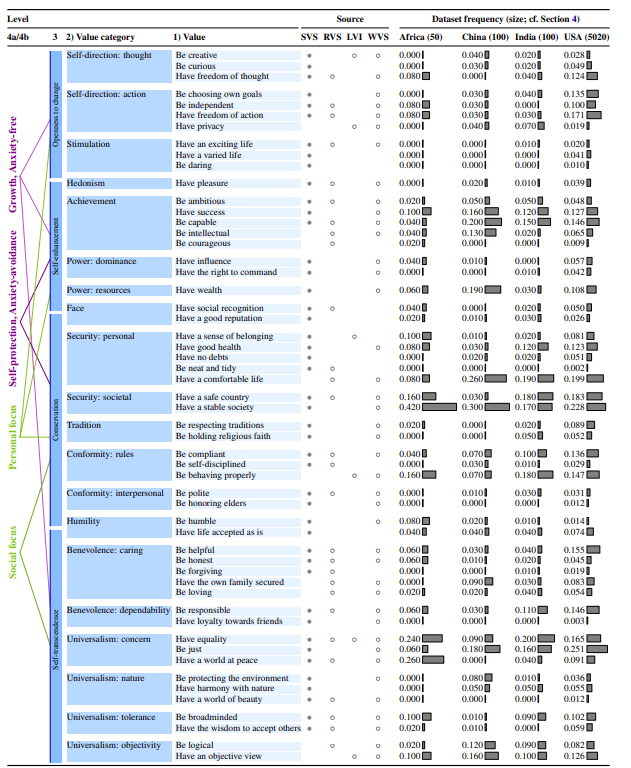.

The dataset is composed of four parts: Africa, China, India and USA. Each argument consists of one premise, one conclusion, and a stance attribute indicating whether the premise is in favor of (pro) or against (con) the conclusion. Due to the difficult of collecting datasets from various cultures, the number of the arguments taken from the non-USA regions (250) is small compared to the US part.

In [ ]:
from urllib import request
import zipfile


url = 'https://zenodo.org/record/6855004/files/webis-argvalues-22.zip'

dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

dataset_path = os.path.join(dataset_folder, "Argvalues")


def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")

def extract_dataset(download_path: str, extract_path: str):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
        print(loaded_tar)
    print("Extraction completed!")

In [ ]:
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

In [ ]:
# Download
download_dataset(dataset_path, url)

# Extraction
extract_dataset(dataset_path, dataset_folder)

Download complete!
Extracting dataset... (it may take a while...)
<zipfile.ZipFile filename='/content/Datasets/Argvalues' mode='r'>
Extraction completed!


In [ ]:
import traceback
import pandas as pd
import json

class MissingColumnError(AttributeError):
    """Error indicating that an imported DataFrame lacks necessary columns"""
    pass


def load_json_file(filepath):
    """Load content of json-file from `filepath`"""
    with open(filepath, 'r') as  json_file:
        return json.load(json_file)


def load_values_from_json(filepath):
    """Load values per level from json-file from `filepath`"""
    json_values = load_json_file(filepath)
    values = { "1":set(), "2":set(), "3":set(), "4a":set(), "4b":set() }
    for value in json_values["values"]:
        values["1"].add(value["name"])
        values["2"].add(value["level2"])
        for valueLevel3 in value["level3"]:
            values["3"].add(valueLevel3)
        for valueLevel4a in value["level4a"]:
            values["4a"].add(valueLevel4a)
        for valueLevel4b in value["level4b"]:
            values["4b"].add(valueLevel4b)
    values["1"] = sorted(values["1"])
    values["2"] = sorted(values["2"])
    values["3"] = sorted(values["3"])
    values["4a"] = sorted(values["4a"])
    values["4b"] = sorted(values["4b"])
    return values


def load_arguments_from_tsv(filepath, default_usage='test'):
    """
        Reads arguments from tsv file
        Parameters
        ----------
        filepath : str
            The path to the tsv file
        default_usage : str, optional
            The default value if the column "Usage" is missing
        Returns
        -------
        pd.DataFrame
            the DataFrame with all arguments
        Raises
        ------
        MissingColumnError
            if the required columns "Argument ID" or "Premise" are missing in the read data
        IOError
            if the file can't be read
        """
    try:
        dataframe = pd.read_csv(filepath, encoding='utf-8', sep='\t', header=0)
        if not {'Argument ID', 'Premise'}.issubset(set(dataframe.columns.values)):
            raise MissingColumnError('The argument "%s" file does not contain the minimum required columns [Argument ID, Premise].' % filepath)
        if 'Usage' not in dataframe.columns.values:
            dataframe['Usage'] = [default_usage] * len(dataframe)
        return dataframe
    except IOError:
        traceback.print_exc()
        raise


def load_labels_from_tsv(filepath, label_order):
    """
        Reads label annotations from tsv file
        Parameters
        ----------
        filepath : str
            The path to the tsv file
        label_order : list[str]
            The listing and order of the labels to use from the read data
        Returns
        -------
        pd.DataFrame
            the DataFrame with the annotations
        Raises
        ------
        MissingColumnError
            if the required columns "Argument ID" or names from `label_order` are missing in the read data
        IOError
            if the file can't be read
        """
    try:
        dataframe = pd.read_csv(filepath, encoding='utf-8', sep='\t', header=0)
        dataframe = dataframe[['Argument ID'] + label_order]
        return dataframe
    except IOError:
        traceback.print_exc()
        raise
    except KeyError:
        raise MissingColumnError('The file "%s" does not contain the required columns for its level.' % filepath)

In [ ]:
def combine_columns(df_arguments, df_labels):
    """Combines the two `DataFrames` on column `Argument ID`"""
    return pd.merge(df_arguments, df_labels, on='Argument ID')


def split_arguments(df_arguments):
    """Splits `DataFrame` by column `Usage` into `train`-, `validation`-, and `test`-arguments"""
    train_arguments = df_arguments.loc[df_arguments['Usage'] == 'train'].drop(['Usage'], axis=1).reset_index(drop=True)
    valid_arguments = df_arguments.loc[df_arguments['Usage'] == 'validation'].drop(['Usage'], axis=1).reset_index(drop=True)
    test_arguments = df_arguments.loc[df_arguments['Usage'] == 'test'].drop(['Usage'], axis=1).reset_index(drop=True)

    return train_arguments, valid_arguments, test_arguments


def create_dataframe_head(argument_ids, model_name):
    """
        Creates `DataFrame` usable to append predictions to it
        Parameters
        ----------
        argument_ids : list[str]
            First column of the resulting DataFrame
        model_name : str
            Second column of DataFrame will contain the given model name
        Returns
        -------
        pd.DataFrame
            prepared DataFrame
    """
    df_model_head = pd.DataFrame(argument_ids, columns=['Argument ID'])
    df_model_head['Method'] = [model_name] * len(argument_ids)

    return df_model_head

In [ ]:
import sys

levels = ["1", "2", "3", "4a", "4b"]
data_dir = '/content/Datasets/webis-argvalues-22'

argument_filepath = os.path.join(data_dir, 'arguments.tsv')
value_json_filepath = os.path.join(data_dir, 'values.json')


df_arguments = load_arguments_from_tsv(argument_filepath, default_usage='train')
values = load_values_from_json(value_json_filepath)
num_levels = len(levels)

for i in range(num_levels):
      if levels[i] not in values:
          print('Missing attribute "{}" in value.json'.format(levels[i]))
          sys.exit(2)

# format dataset
df_train_all = []
df_valid_all = []
df_test_all = []
df_full_levels = []
for i in range(num_levels):
    label_filepath = os.path.join(data_dir, 'labels-level{}.tsv'.format(levels[i]))
    if not os.path.isfile(label_filepath):
        print('The required file "labels-level{}.tsv" is not present in the data directory'.format(levels[i]))
        sys.exit(2)
    # read labels from .tsv file
    df_labels = load_labels_from_tsv(label_filepath, values[levels[i]])
    # join arguments and labelsum
    df_full_level = combine_columns(df_arguments, df_labels)
    df_full_levels.append(df_full_level)
    # split dataframe by usage
    train_arguments, valid_arguments, test_arguments = split_arguments(df_full_level)
    df_train_all.append(train_arguments)
    df_valid_all.append(valid_arguments)
    df_test_all.append(test_arguments)

In [ ]:
evaluation_filepath = os.path.join(data_dir, 'evaluation.tsv')
df_evaluation = pd.read_csv(evaluation_filepath, usecols= ['Method','Test dataset','Level','Label','Precision','Recall','F1','Accuracy'], sep = '\t')

In the next two cells we can see the structure of the dataset with and without the value categories. In fact, to each unique argument is linked one of the 20 value categories, with a 1 meaning that the argument resorts to that value category and a 0 if it does not.

In [ ]:
df_full_levels[1].head()

,Argument ID,Part,Usage,Conclusion,Stance,Premise,Achievement,Benevolence: caring,Benevolence: dependability,Conformity: interpersonal,...,Security: personal,Security: societal,Self-direction: action,Self-direction: thought,Stimulation,Tradition,Universalism: concern,Universalism: nature,Universalism: objectivity,Universalism: tolerance
0,A01001,usa,train,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,A01002,usa,train,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,A01003,usa,train,We should abandon marriage,against,marriage is the ultimate commitment to someone...,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,A01004,usa,train,We should ban naturopathy,against,it provides a useful income for some people,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,A01005,usa,train,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df_arguments.head()

,Argument ID,Part,Usage,Conclusion,Stance,Premise
0,A01001,usa,train,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...
1,A01002,usa,train,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
2,A01003,usa,train,We should abandon marriage,against,marriage is the ultimate commitment to someone...
3,A01004,usa,train,We should ban naturopathy,against,it provides a useful income for some people
4,A01005,usa,train,We should ban fast food,in favor of,fast food should be banned because it is reall...


In the following pie chart one can in fact notice how the dataset is strongly unbalanced in favour of USA, while the other four regions take a very small part of it, especially Africa.


<Axes: ylabel='Part'>

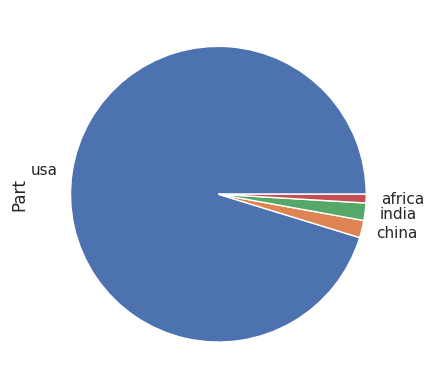

In [ ]:
sn.set_theme()
df_arguments['Part'].value_counts().plot.pie()

Specifically regarding the training set, only data from the USA has been gathered, as shown in the following plot.

<Axes: ylabel='Part'>

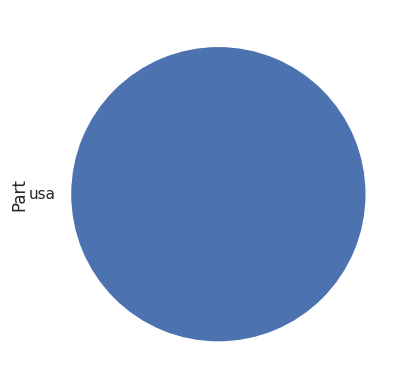

In [ ]:
df = df_arguments[df_arguments['Usage'] == 'train']
df['Part'].value_counts().plot.pie()

Instead, for the test part, the data is more diverse. USA still takes the vast majority of it, but roughly one-fourth of the whole dataset available is also occupied by other regions, a portion way bigger than the total one. This is obvious since the training set is made only from USA data, while here we are taking into account only the test set.

<Axes: ylabel='Part'>

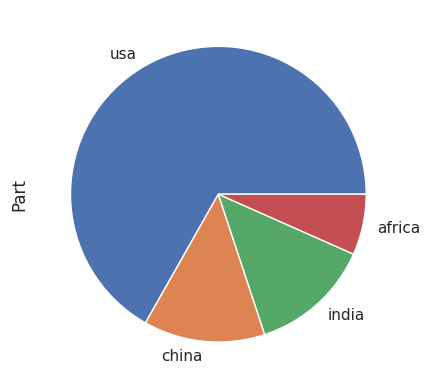

In [ ]:
df = df_arguments[df_arguments['Usage'] == 'test']
df['Part'].value_counts().plot.pie()

In the following part we are going to carry out some analysis regarding the different levels. In fact, as shows in the figure below, the paper's taxonomy of 54 values (represented as black dots) is divided in different levels of abstraction. Categories that tend to conflict are placed on opposite sides.
This project is going to take into account only the Values Categories inside Level 2, for the sake of information in this section we analyze the dataset for each Level.




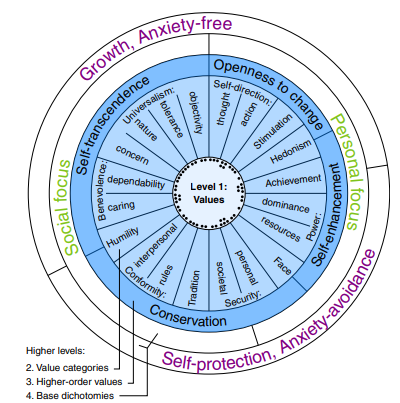




In [ ]:
def labels_data(levels):
  df_labels = []
  df_level = []
  for i in range(len(levels)):
    label_filepath = os.path.join(data_dir, 'labels-level{}.tsv'.format(levels[i]))
    df_labels.append(load_labels_from_tsv(label_filepath, values[levels[i]]))
    df_level.append(combine_columns(df_arguments, df_labels[i]))
  return df_level


In [ ]:
df_level = labels_data(levels)
for i in range(len(levels)):
  df_level[i]['value'] = (df_level[i].iloc[:, 1:] == 1).idxmax(1)

In [ ]:
df_level[0].drop(df_level[0].columns[[i for i in range(6,60)]], axis = 1, inplace=True)
df_level[1].drop(df_level[1].columns[[i for i in range(6, 26)]], axis = 1, inplace = True)
df_level[2].drop(df_level[2].columns[[i for i in range(6,10)]], axis = 1, inplace=True)
df_level[3].drop(df_level[3].columns[[i for i in range(6, 8)]], axis = 1, inplace = True)
df_level[4].drop(df_level[4].columns[[i for i in range(6, 8)]], axis = 1, inplace = True)

The following is a small view from the dataset given the first values level. One can notice how to each argument is associated a specific value, depending on the respective premise and conclusion.

In [ ]:
df_level[0].head()

,Argument ID,Part,Usage,Conclusion,Stance,Premise,value
0,A01001,usa,train,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,Have a safe country
1,A01002,usa,train,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,Have a stable society
2,A01003,usa,train,We should abandon marriage,against,marriage is the ultimate commitment to someone...,Be choosing own goals
3,A01004,usa,train,We should ban naturopathy,against,it provides a useful income for some people,Have a comfortable life
4,A01005,usa,train,We should ban fast food,in favor of,fast food should be banned because it is reall...,Have good health


In the next part we are going to plot four histograms to show the frequency of each category given the country of origin.
Each histogram is plotted with respect to one of the levels in the dataset, as briefly described above.
Once again, once can notice as the vast majority of values is contained in the USA dataset.

In [ ]:
def clean_df_country(level):
  countries = ['usa','africa','china','india']
  df = []
  df_values = df_level[level].groupby('Part').value.value_counts().reset_index(name = 'Values')
  for i in range(len(countries)):
    df.append(df_values[(df_values['Part'] == countries[i])])
    diff = set(df[i]['value']) ^ set(values[levels[level]])
    diff = list(diff)
    for j in range(len(diff)):
      new_row = {'Part':countries[i], 'value':diff[j], 'Values':0}
      df[i] = df[i].append(pd.Series(new_row, index=df[i].columns),ignore_index=True)

    df[i] = df[i].sort_values(by='value')
  return df[0],df[1],df[2],df[3]


df_usa = [None] * 5
df_africa = [None] * 5
df_china = [None] * 5
df_india = [None] * 5
for i in range(len(levels)):
  df_usa[i], df_africa[i], df_china[i], df_india[i] = clean_df_country(i)

<ipython-input-38-4aea8bb01709>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[i] = df[i].append(pd.Series(new_row, index=df[i].columns),ignore_index=True)
<ipython-input-38-4aea8bb01709>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[i] = df[i].append(pd.Series(new_row, index=df[i].columns),ignore_index=True)
<ipython-input-38-4aea8bb01709>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[i] = df[i].append(pd.Series(new_row, index=df[i].columns),ignore_index=True)
<ipython-input-38-4aea8bb01709>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[i] = df[i].append(pd.Series(new_row, index=df[i].columns),ignore_index=Tr

In [ ]:
def normalize_hist(df_usa, df_africa, df_china, df_india):
  df_usa_normalized = []
  df_africa_normalized = []
  df_china_normalized = []
  df_india_normalized = []
  usa_list = list(df_usa['Values'])
  africa_list = list(df_africa['Values'])
  china_list = list(df_china['Values'])
  india_list = list(df_india['Values'])
  for i in range((df_usa.shape[0])):

    summ = usa_list[i] + africa_list[i] + china_list[i] + india_list[i]
    try:
      df_usa_normalized.append(usa_list[i]/summ)
      df_africa_normalized.append(africa_list[i]/summ)
      df_china_normalized.append(china_list[i]/summ)
      df_india_normalized.append(india_list[i]/summ)
    except ZeroDivisionError:
      df_usa_normalized.append(0)
      df_africa_normalized.append(0)
      df_china_normalized.append(0)
      df_india_normalized.append(0)

  return df_usa_normalized, df_africa_normalized, df_china_normalized, df_india_normalized

In [ ]:
df_usa_normalized = [None] * 5
df_africa_normalized = [None] * 5
df_china_normalized = [None] * 5
df_india_normalized = [None] * 5
for i in range(len(levels)):
  df_usa_normalized[i], df_africa_normalized[i], df_china_normalized[i], df_india_normalized[i] = normalize_hist(df_usa[i], df_africa[i], df_china[i], df_india[i])

In [ ]:
def arguments_plot(level, df_usa, df_africa, df_china, df_india):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(30, 10.5)

    values_list = list(values[levels[level]])
    countries = {
        'usa': list(df_usa),
        'africa': list(df_africa),
        'china': list(df_china),
        'india': list(df_india)
    }

    x = np.arange(len(values_list))
    width = 0.2
    multiplier = 0


    for attribute, measurement in countries.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        multiplier += 1

    ax.set_xticks(x + width, values_list,rotation =  90)
    ax.legend(loc='upper right')
    ax.set_ylim(0, 1)

    plt.show()

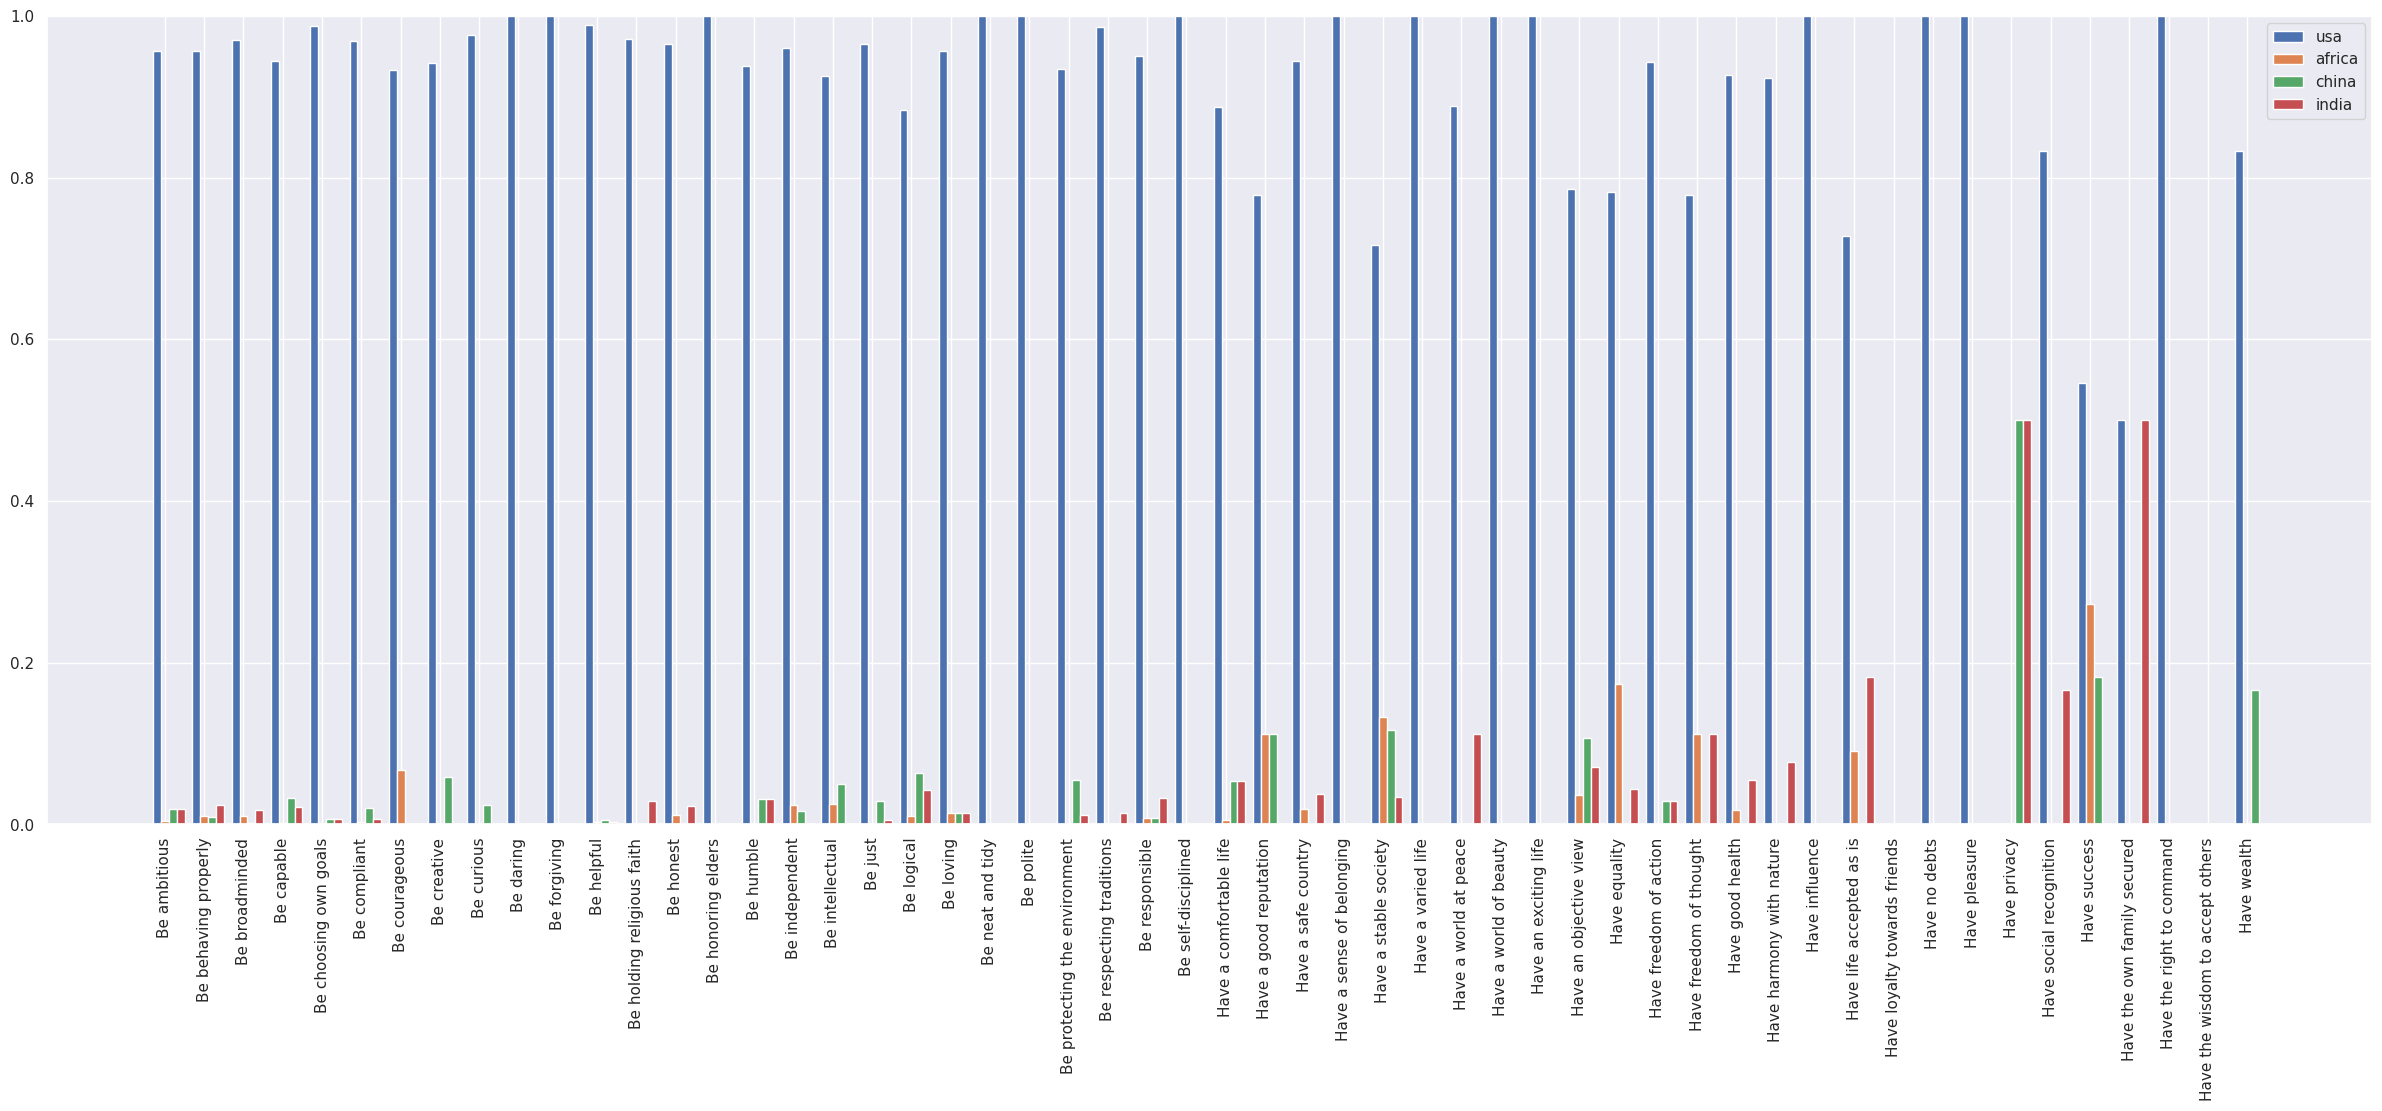

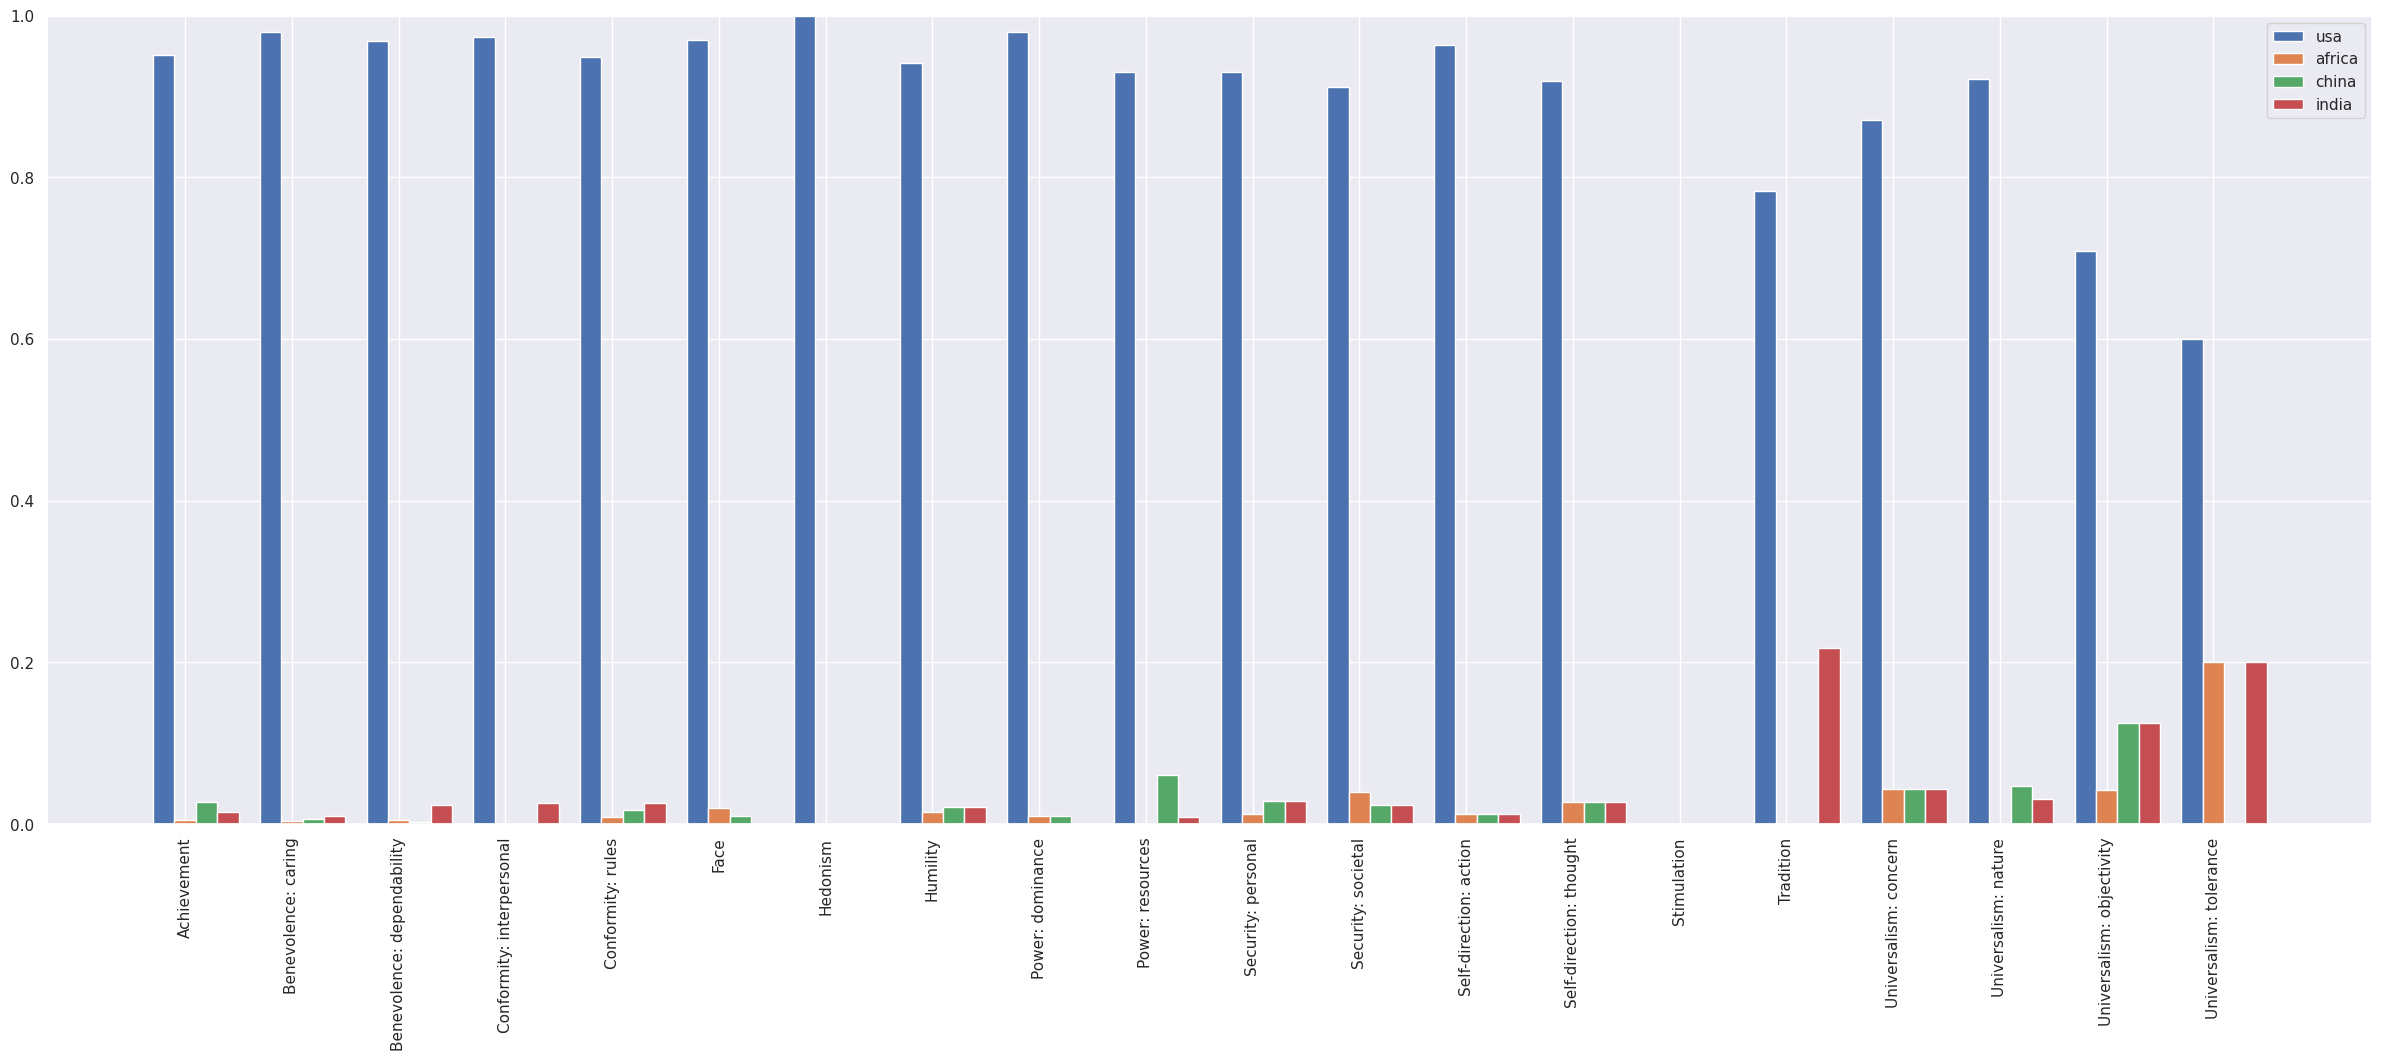

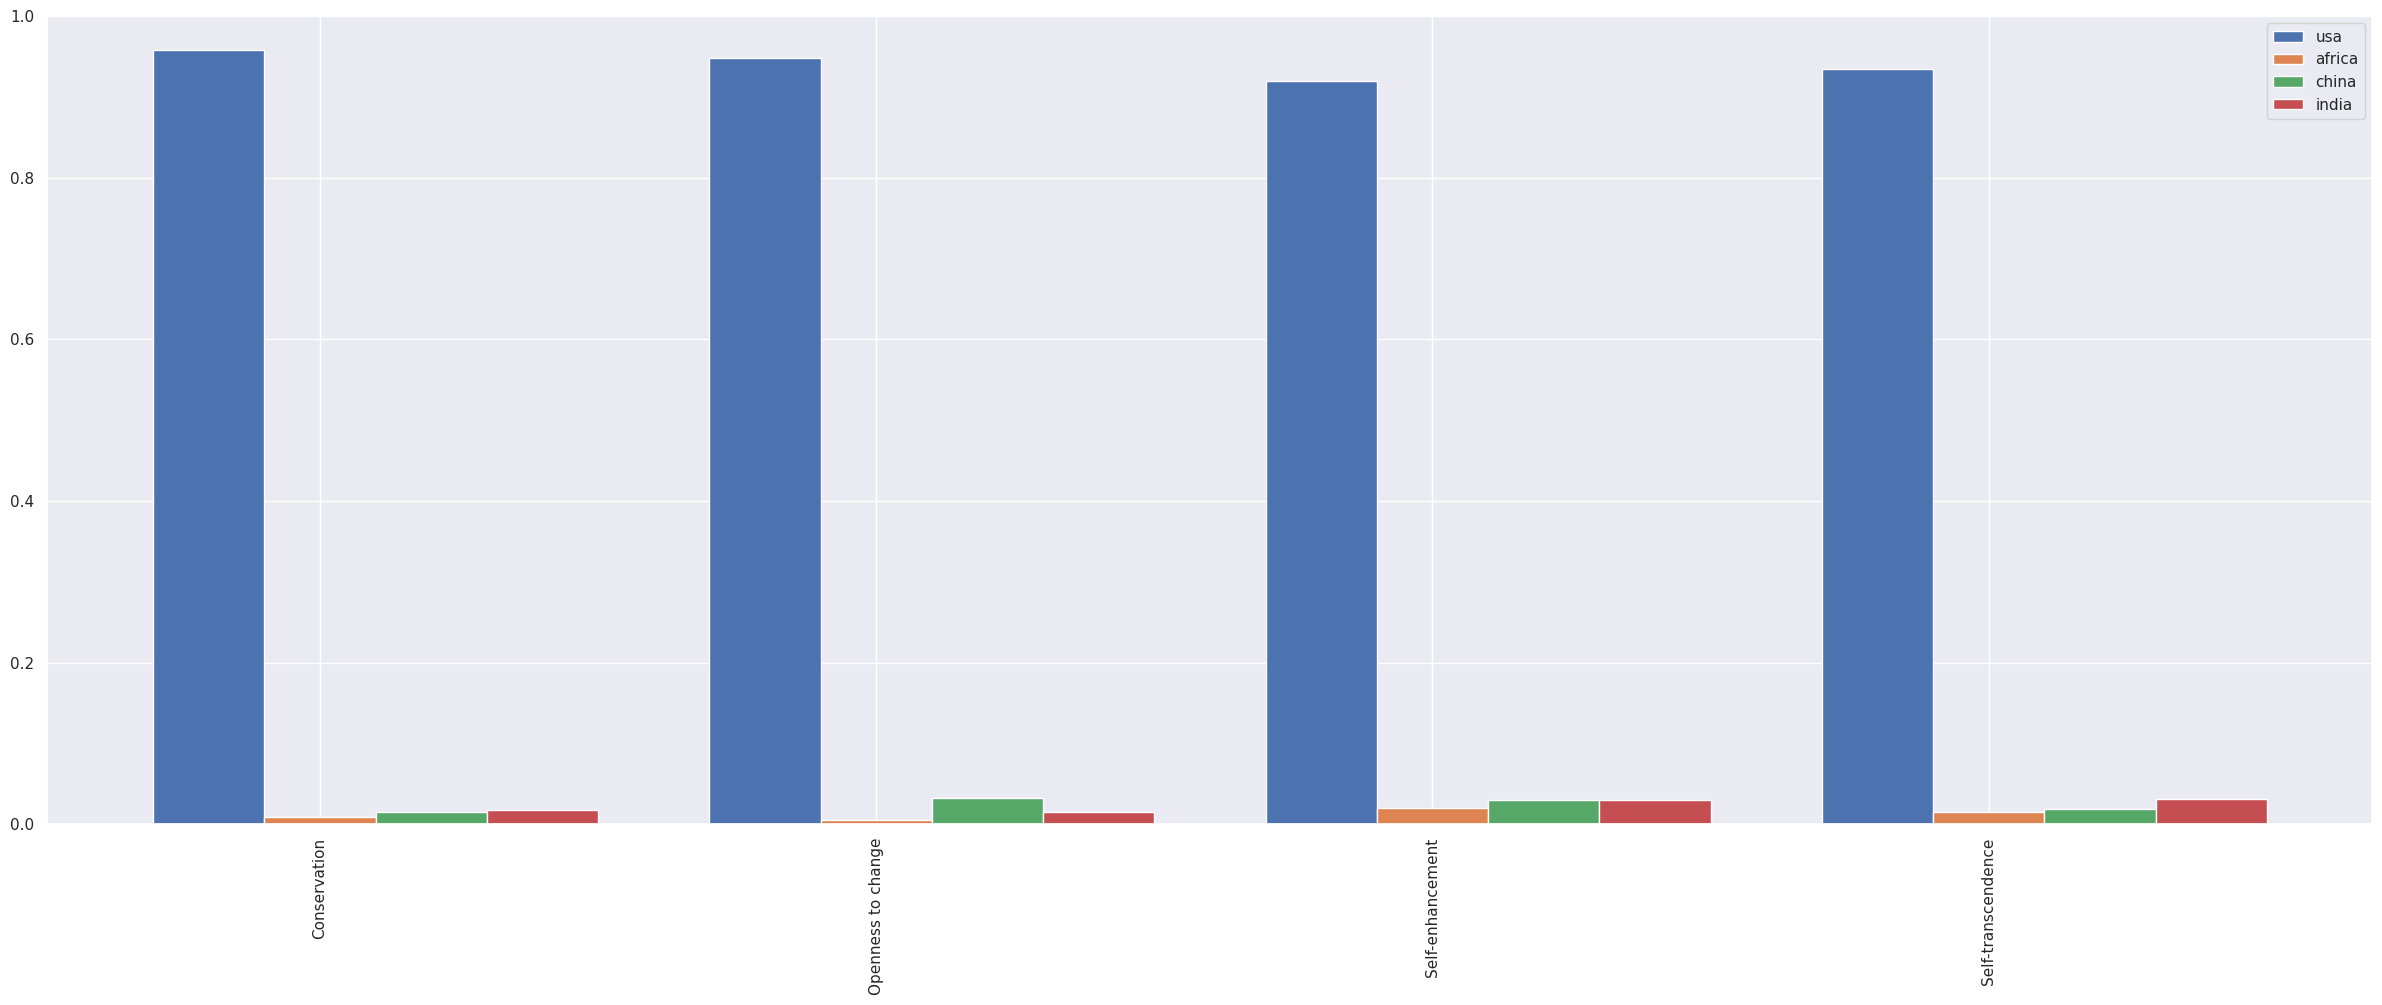

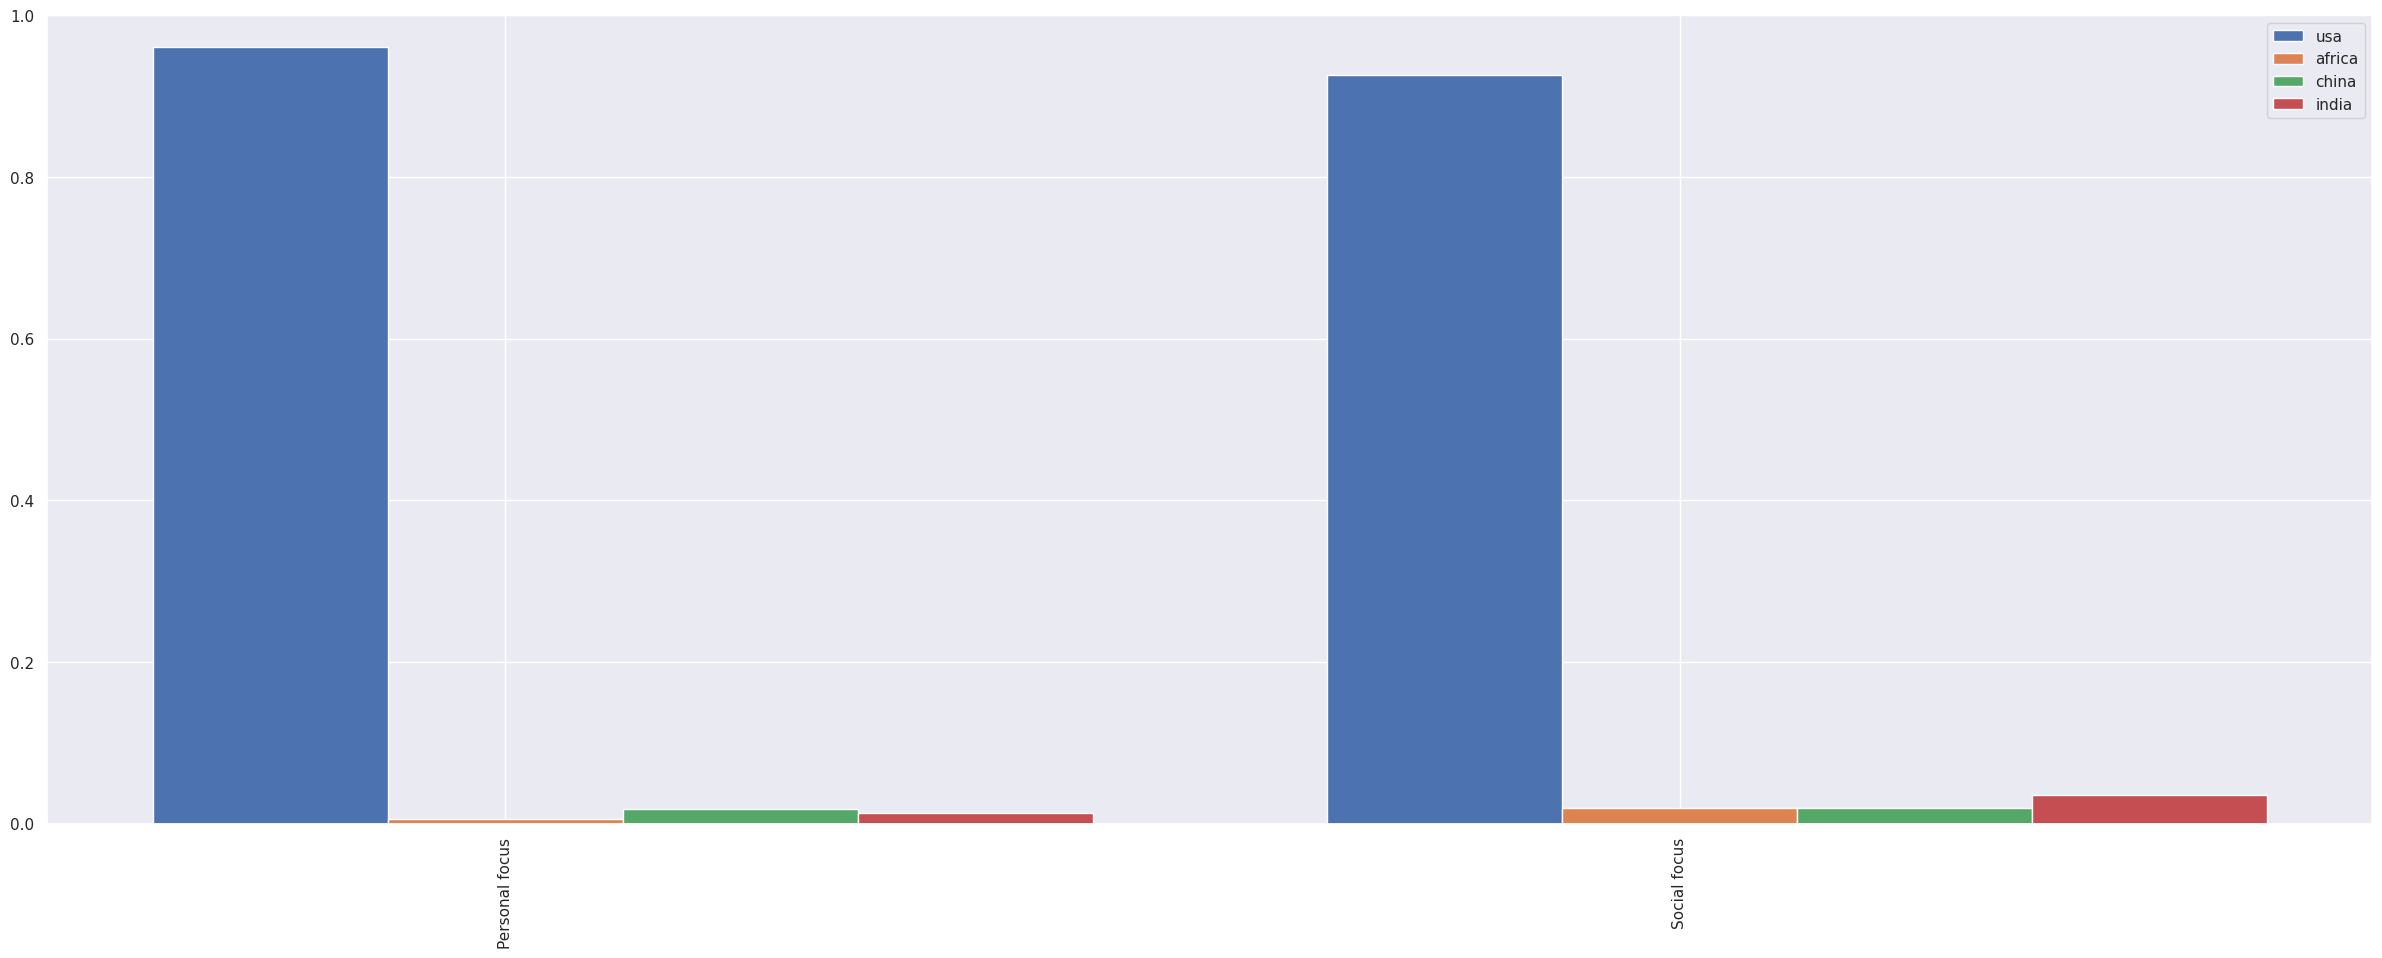

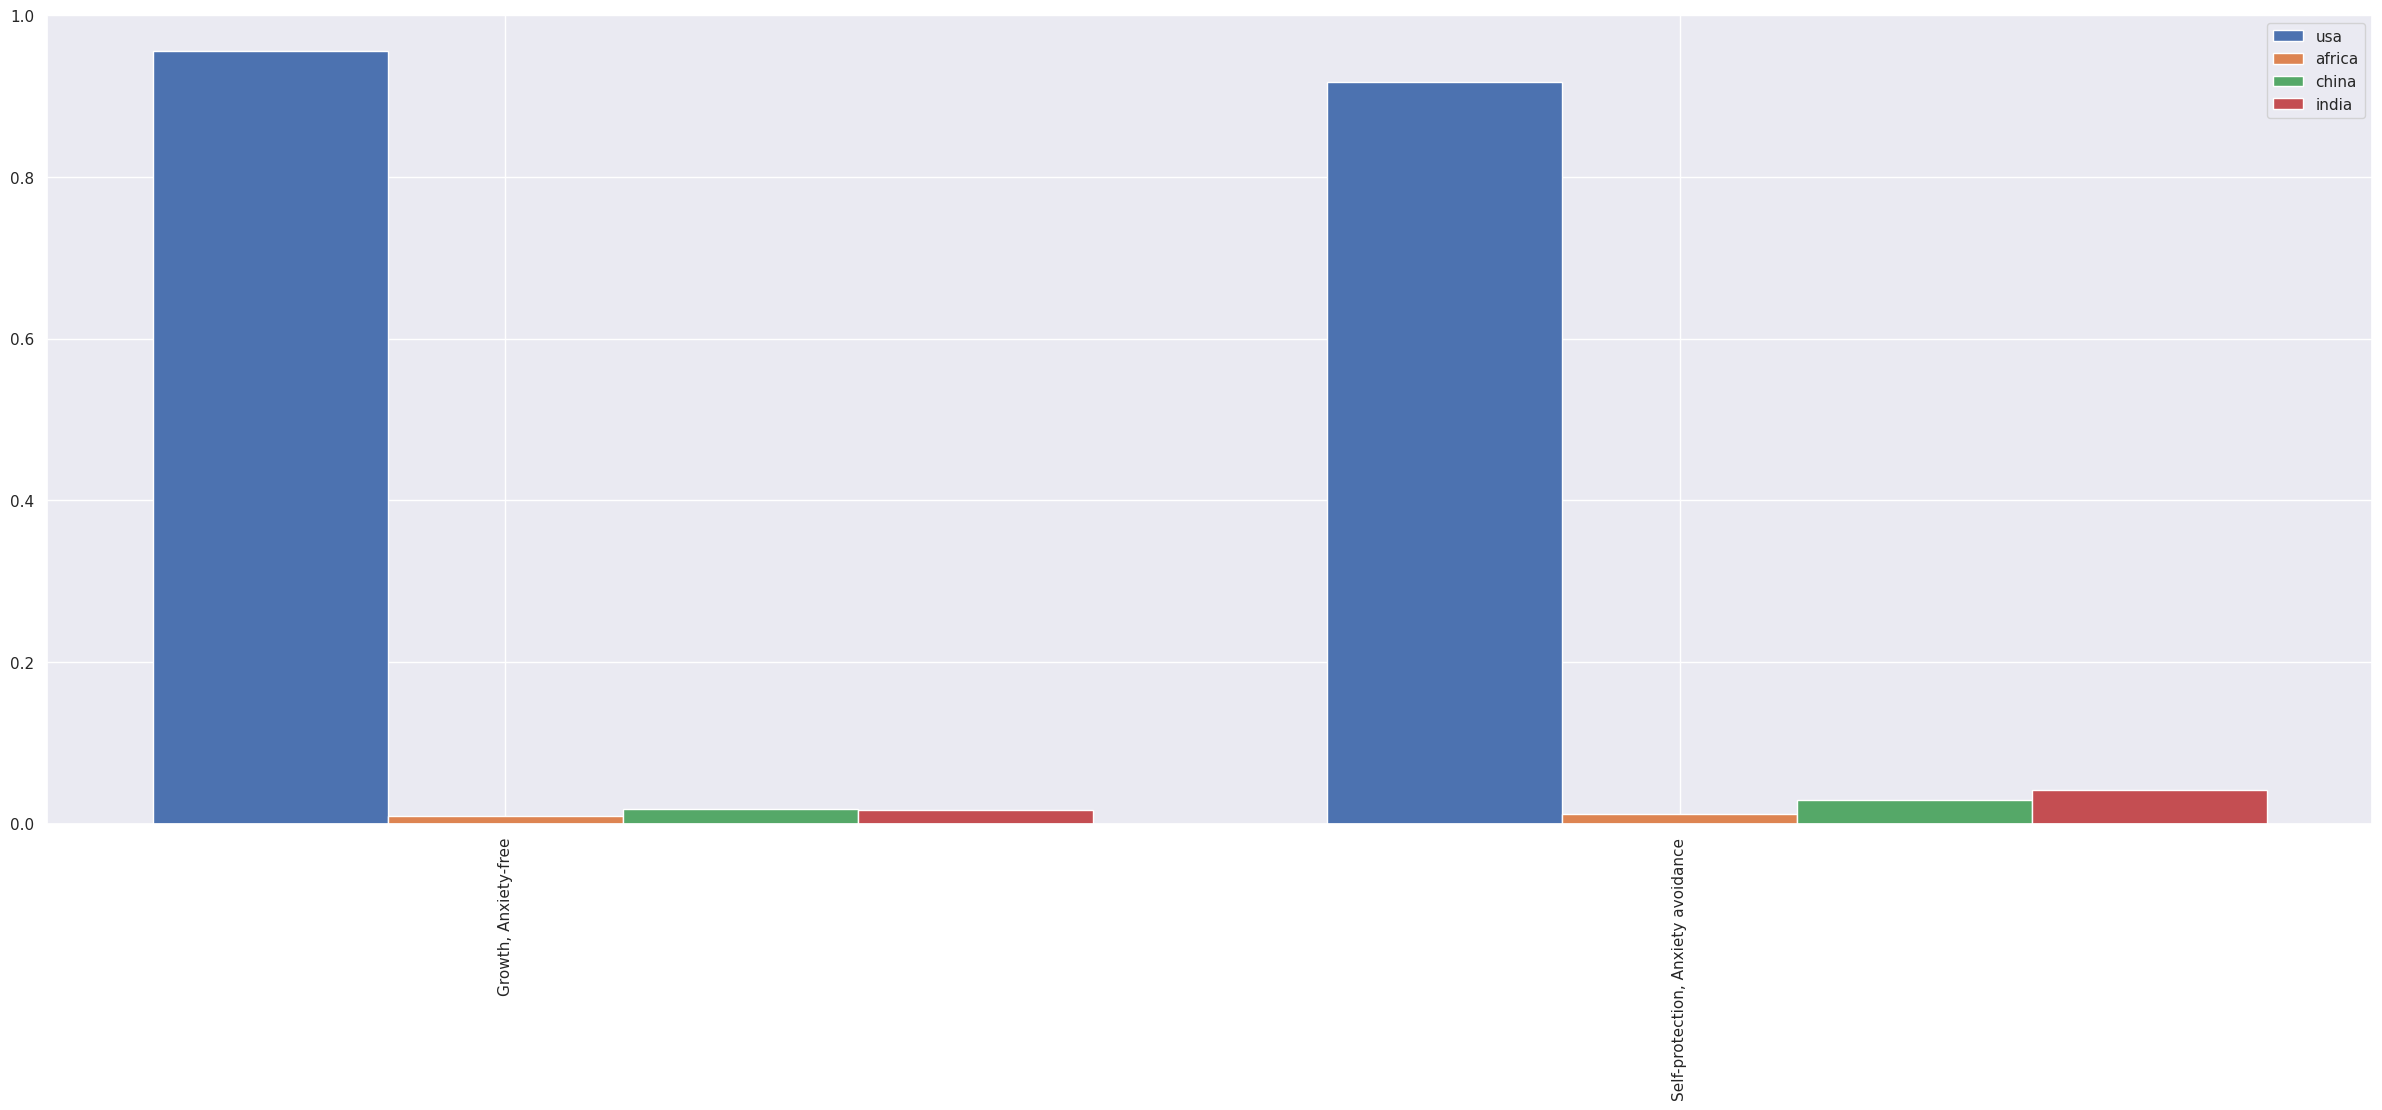

In [ ]:
for i in range(len(levels)):
  arguments_plot(i, df_usa_normalized[i], df_africa_normalized[i], df_china_normalized[i], df_india_normalized[i])

The researchers of the paper studied for this project provided some results they obtained with three different models: 1-Baseline, SVM and BERT. Here we show a comparison between the F1-score reached by those models with respect to Level 1. Overall, BERT seems to perform better tha the other models.

In [ ]:
def df_countries(countries):
  df_f1 = []

  for i in range(len(countries)):
    df_f1.append(df_evaluation[df_evaluation['Test dataset'] == countries[i]])
    df_f1[i] = df_f1[i][df_f1[i]['Level'] == '1']
    df_f1[i] = df_f1[i].drop(['Precision','Recall','Accuracy'],axis = 1)

  return df_f1[0], df_f1[1], df_f1[2], df_f1[3]

In [ ]:
countries = ['usa','africa','china','india']
df_f1_usa, df_f1_africa, df_f1_china, df_f1_india = df_countries(countries)

In [ ]:
df_f1_usa_base = df_f1_usa[df_f1_usa['Method'] == '1-Baseline']
df_f1_usa_svm = df_f1_usa[df_f1_usa['Method'] == 'SVM']
df_f1_usa_bert = df_f1_usa[df_f1_usa['Method'] == 'BERT' ]

<ipython-input-45-496d05dae337>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(values_list, rotation=90)


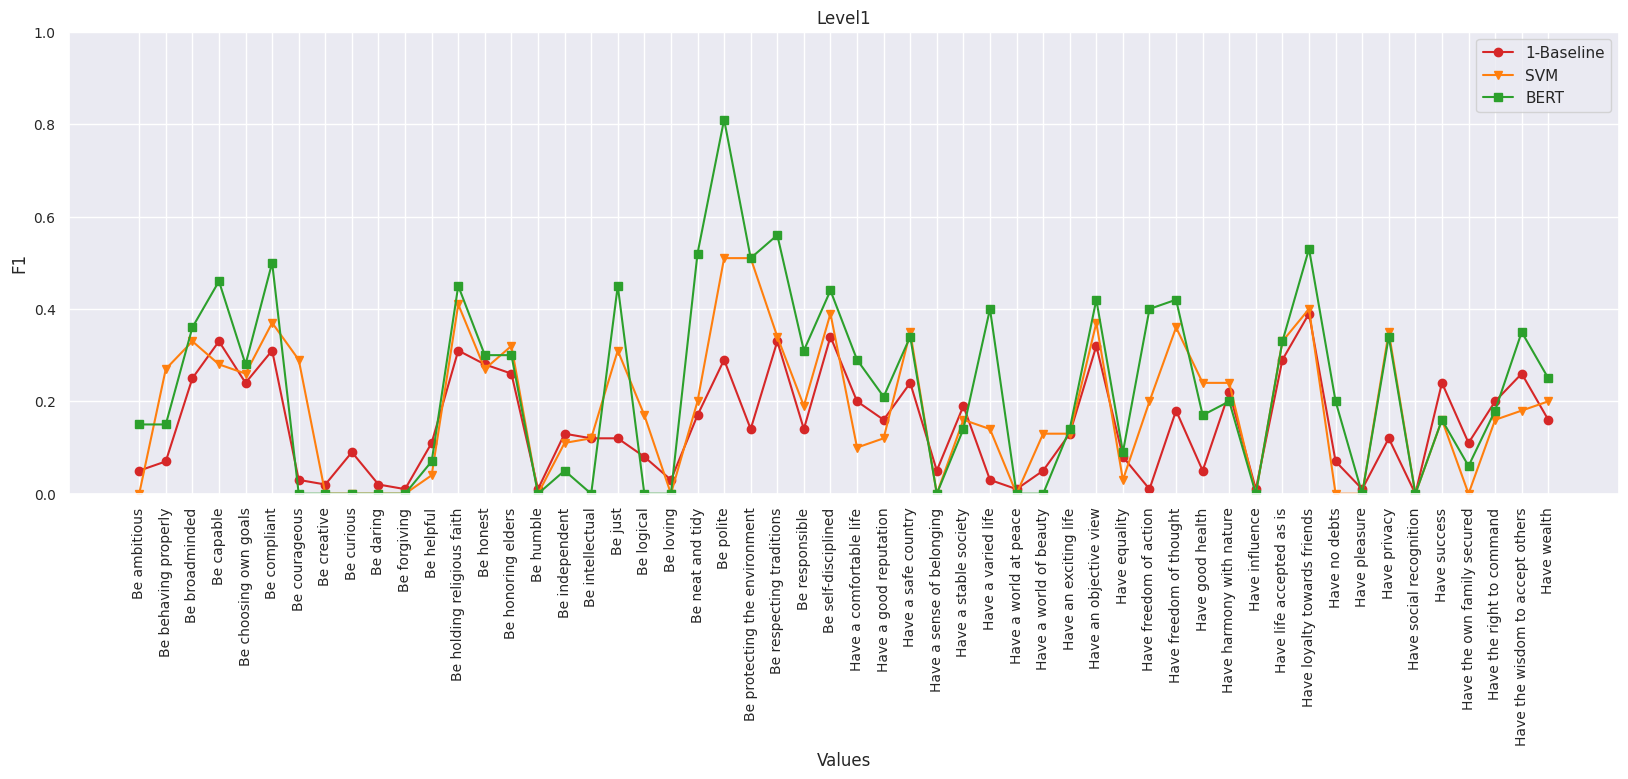

In [ ]:
values_list = list(values['1'])
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_f1_usa_base['Label'], df_f1_usa_base['F1'], marker = 'o', label = '1-Baseline', color = 'tab:red')
ax.plot(df_f1_usa_svm['Label'], df_f1_usa_svm['F1'], marker = 'v', label = 'SVM', color = 'tab:orange')
ax.plot(df_f1_usa_bert['Label'], df_f1_usa_bert['F1'], marker = 's', label = 'BERT', color = 'tab:green')
ax.set_xticklabels(values_list, rotation=90)
ax.set_xlabel('Values')
ax.set_ylabel('F1')
ax.set_ylim([0.0, 1.0])
ax.tick_params(labelsize = 10)
ax.set_title("Level1")
ax.legend()
plt.plot();
plt.show();

As last part of the analysis of the whole dataset, we show a table representing the numbers of unique conclusions and premises for each part of the dataset, as well as their mean number of space-separated tokens and stance distribution.

In [ ]:
def get_avg(list):
  summ = 0
  for i in list:
    summ += len(i)
  avg = summ/len(list)
  return round(avg,1)

def df_counter(country):
  frames = [df_train_all[0], df_valid_all[0], df_test_all[0]]
  df = pd.concat(frames)
  concs = 0
  premises = 0
  df_country = df[df['Part'] == country]
  df_conc = df_country['Conclusion'].unique()
  df_premises = df_country['Premise'].unique()
  conc_counter = ([list(df_conc)[i].split() for i in range(len(df_conc))])
  premises_counter = ([list(df_premises)[i].split() for i in range(len(df_premises))])
  stances_pro_counter = len(df_country[df_country['Stance'] == 'in favor of'])
  stances_con_counter = len(df_country[df_country['Stance'] == 'against'])
  avg_concs = get_avg(conc_counter)
  avg_premises = get_avg(premises_counter)
  concs = len(df_conc)
  premises = len(df_premises)

  return concs, premises, avg_concs, avg_premises, stances_pro_counter, stances_con_counter

In [ ]:
concs_usa, premises_usa, avg_concs_usa, avg_premises_usa, stances_pro_counter_usa, stances_con_counter_usa = df_counter('usa')
concs_africa, premises_africa, avg_concs_africa, avg_premises_africa, stances_pro_counter_africa, stances_con_counter_africa = df_counter('africa')
concs_china, premises_china, avg_concs_china, avg_premises_china, stances_pro_counter_china, stances_con_counter_china = df_counter('china')
concs_india, premises_india, avg_concs_india, avg_premises_india, stances_pro_counter_india, stances_con_counter_india = df_counter('india')

In [ ]:
table = [["USA",str(concs_usa)+'      '+str(avg_concs_usa),str(premises_usa)+'      '+str(avg_premises_usa), str(stances_pro_counter_usa)+'   '+str(stances_con_counter_usa)],["Africa",str(concs_africa)+'      '+str(avg_concs_africa),str(premises_africa)+'        '+str(avg_premises_africa), str(stances_pro_counter_africa)+'     '+str(stances_con_counter_africa)],
          ["China",str(concs_china)+'      '+str(avg_concs_china),str(premises_china)+'       '+str(avg_premises_china), str(stances_pro_counter_china)+'     '+str(stances_con_counter_china)],["India",str(concs_india)+'      '+str(avg_concs_india),str(premises_india)+'       '+str(avg_premises_india), str(stances_pro_counter_india)+'     '+str(stances_con_counter_india)]]
print(tabulate(table, headers=["Country","Conclusions\nNumber Avg tokens","Premises\nNumber  Avg tokens","Stances\nPros Cons"]))

Country    Conclusions          Premises              Stances
           Number Avg tokens    Number  Avg tokens    Pros Cons
---------  -------------------  --------------------  -----------
USA        71      5.6          5020      18.5        2619   2401
Africa     23      10.8         50        28.5        37     13
China      12      7.2          100       24.5        59     41
India      40      6.5          100       30.2        60     40


#### Without USA

In the last section of this Dataset Analysis part we show how the distribution of the arguments changes without taking into consideration the most dominant USA part. In this way we will be able to do some testing also between parts of the dataset equally represented.

In [ ]:
df_nousa = df_level[1][df_level[1]['Part'] != 'usa']
df_nousa.head()

,Argument ID,Part,Usage,Conclusion,Stance,Premise,value
5020,B28001,africa,test,Sudan must advance its industrialization (incl...,in favor of,Industrialization increases the number of 'goo...,Achievement
5021,B28002,africa,test,Sudan must advance its industrialization (incl...,in favor of,Industrialization accelerates labour productiv...,Achievement
5022,B28003,africa,test,Sudan must advance its industrialization (incl...,in favor of,Industrialization increases national technolog...,Benevolence: caring
5023,B28004,africa,test,Sudan must advance its industrialization (incl...,in favor of,"Industrialization adds value to exports, which...",Achievement
5024,B28005,africa,test,South Africa's COVID-19 lockdown was too strict,in favor of,The lockdown caused severe police brutality.,Conformity: rules


In the following pie chart we can in fact see how the three remaining regions share a more similar part of the dataset, with Africa being the less represented.

<Axes: ylabel='Part'>

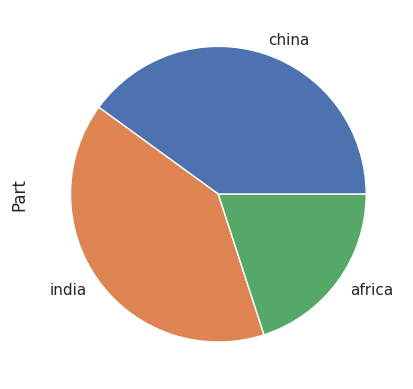

In [ ]:
df_nousa['Part'].value_counts().plot.pie()


A similar histogram analysis is being outlined here as before. One can notice how the dataset is more equally distributed.  

In [ ]:
from matplotlib.ticker import MaxNLocator




def arguments_plot(level, df_africa, df_china, df_india):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(30, 10.5)

    values_list = list(values[levels[level]])
    countries = {
        'africa': list(df_africa['Values']),
        'china': list(df_china['Values']),
        'india': list(df_india['Values'])
    }

    x = np.arange(len(values_list))
    width = 0.2
    multiplier = 0


    for attribute, measurement in countries.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        multiplier += 1

    ax.set_xticks(x + width, values_list,rotation =  90)
    ax.legend(loc='upper right', fontsize = 20)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()

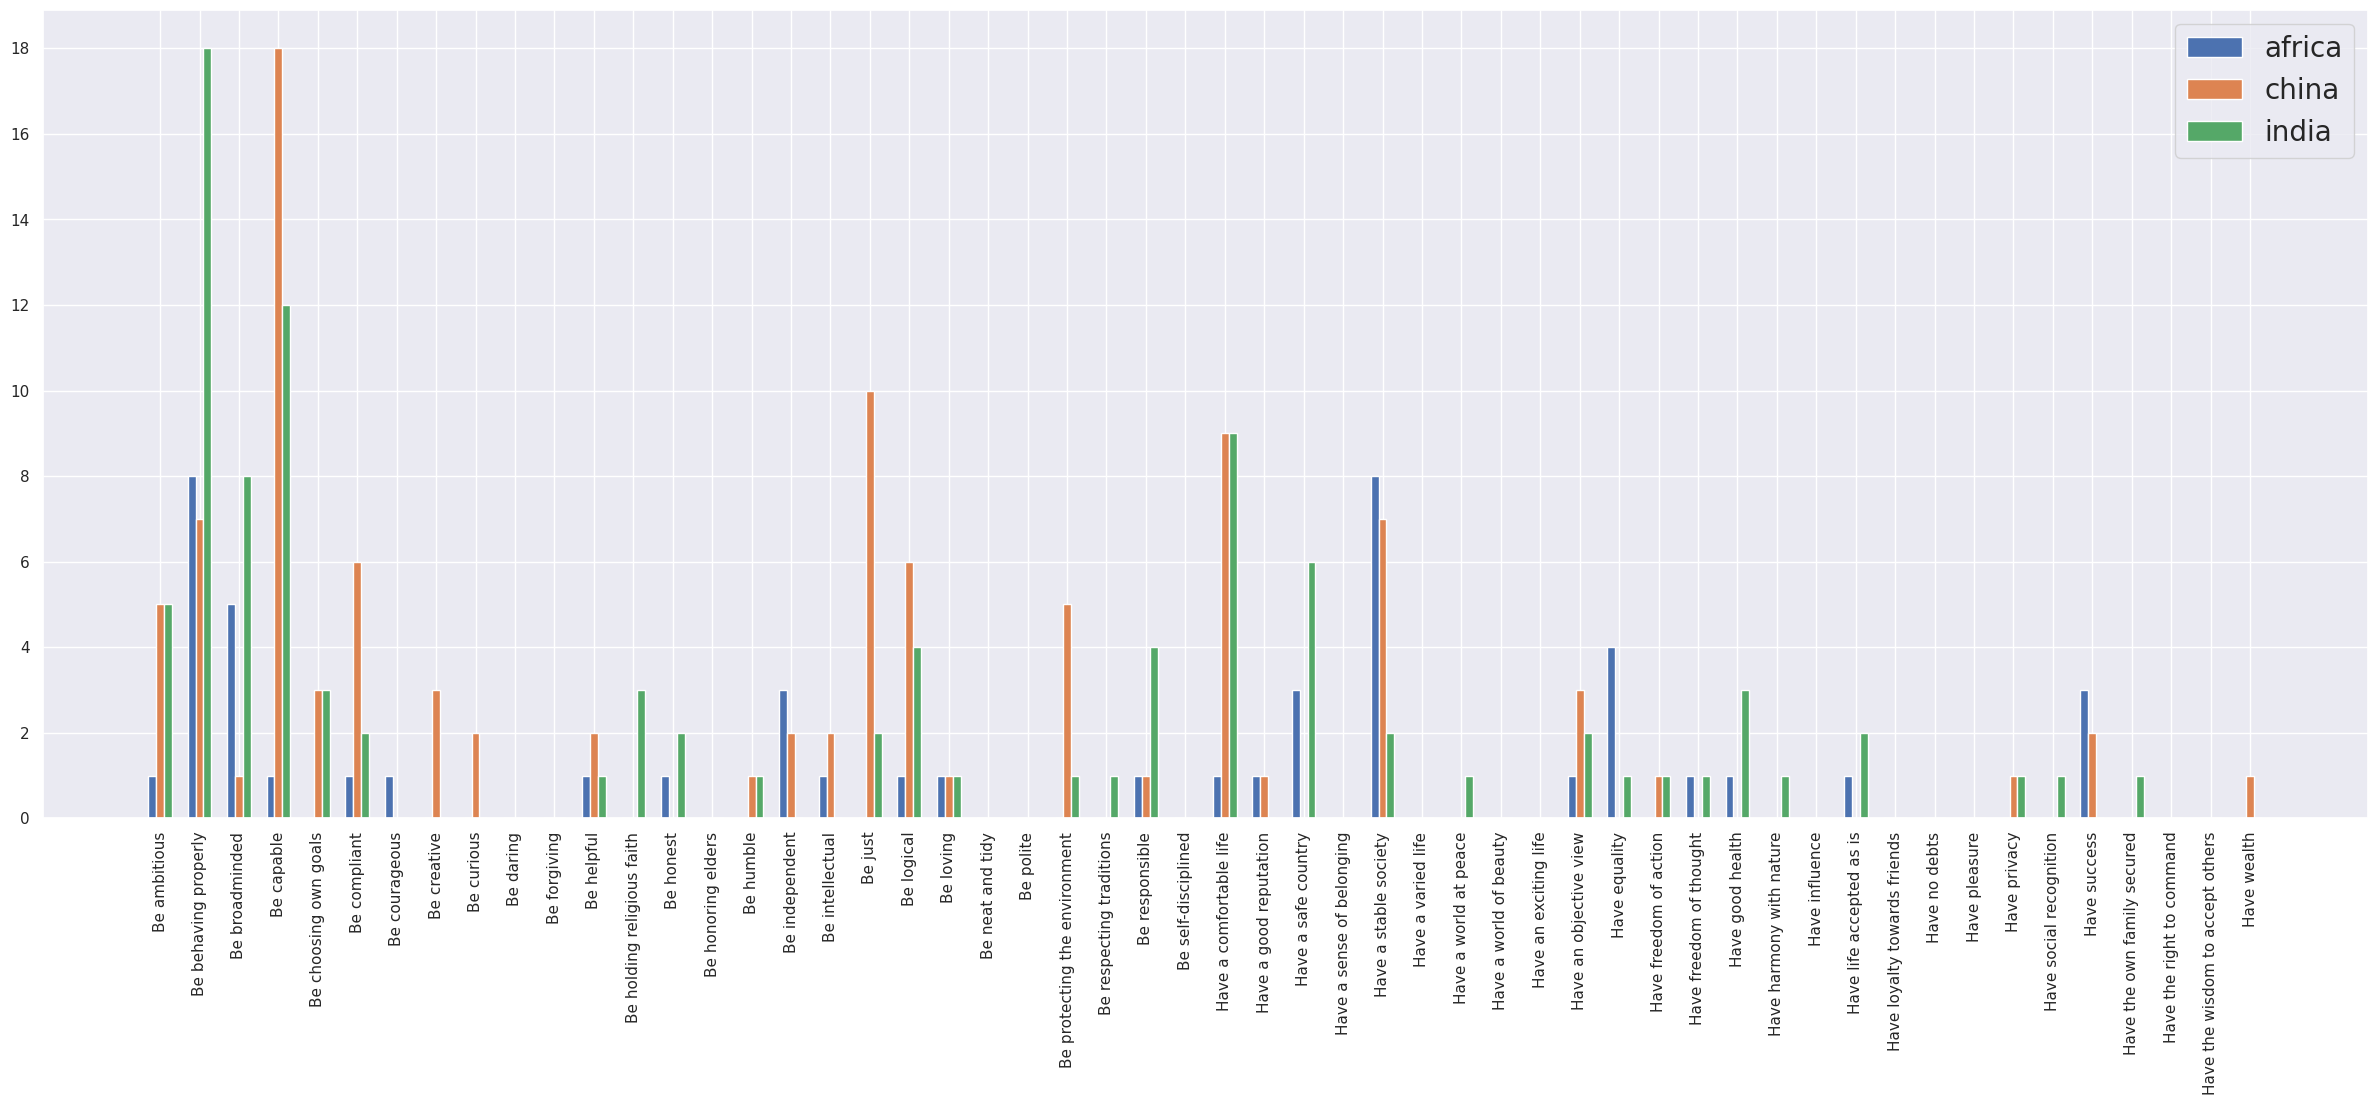

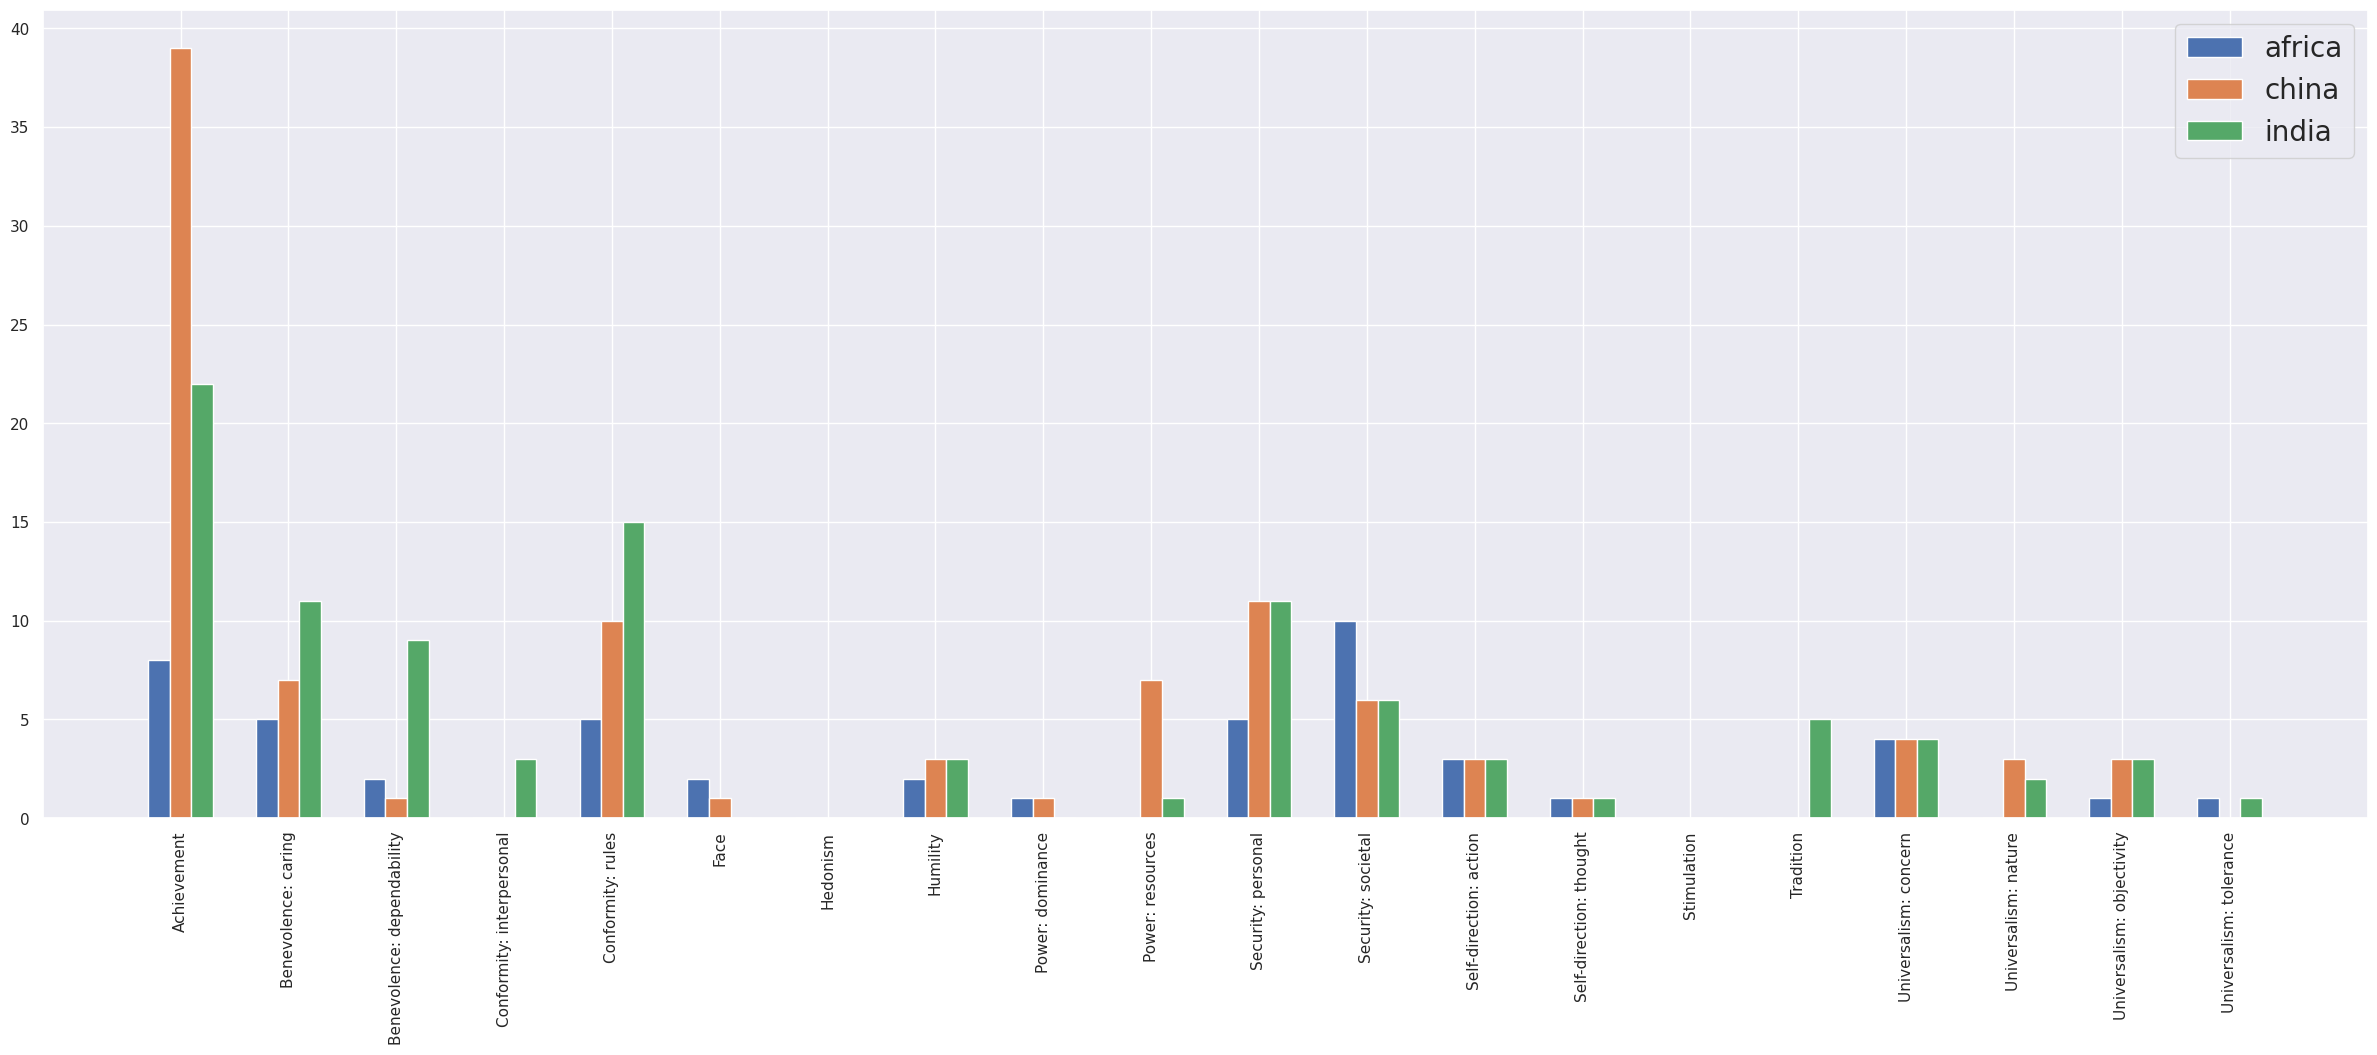

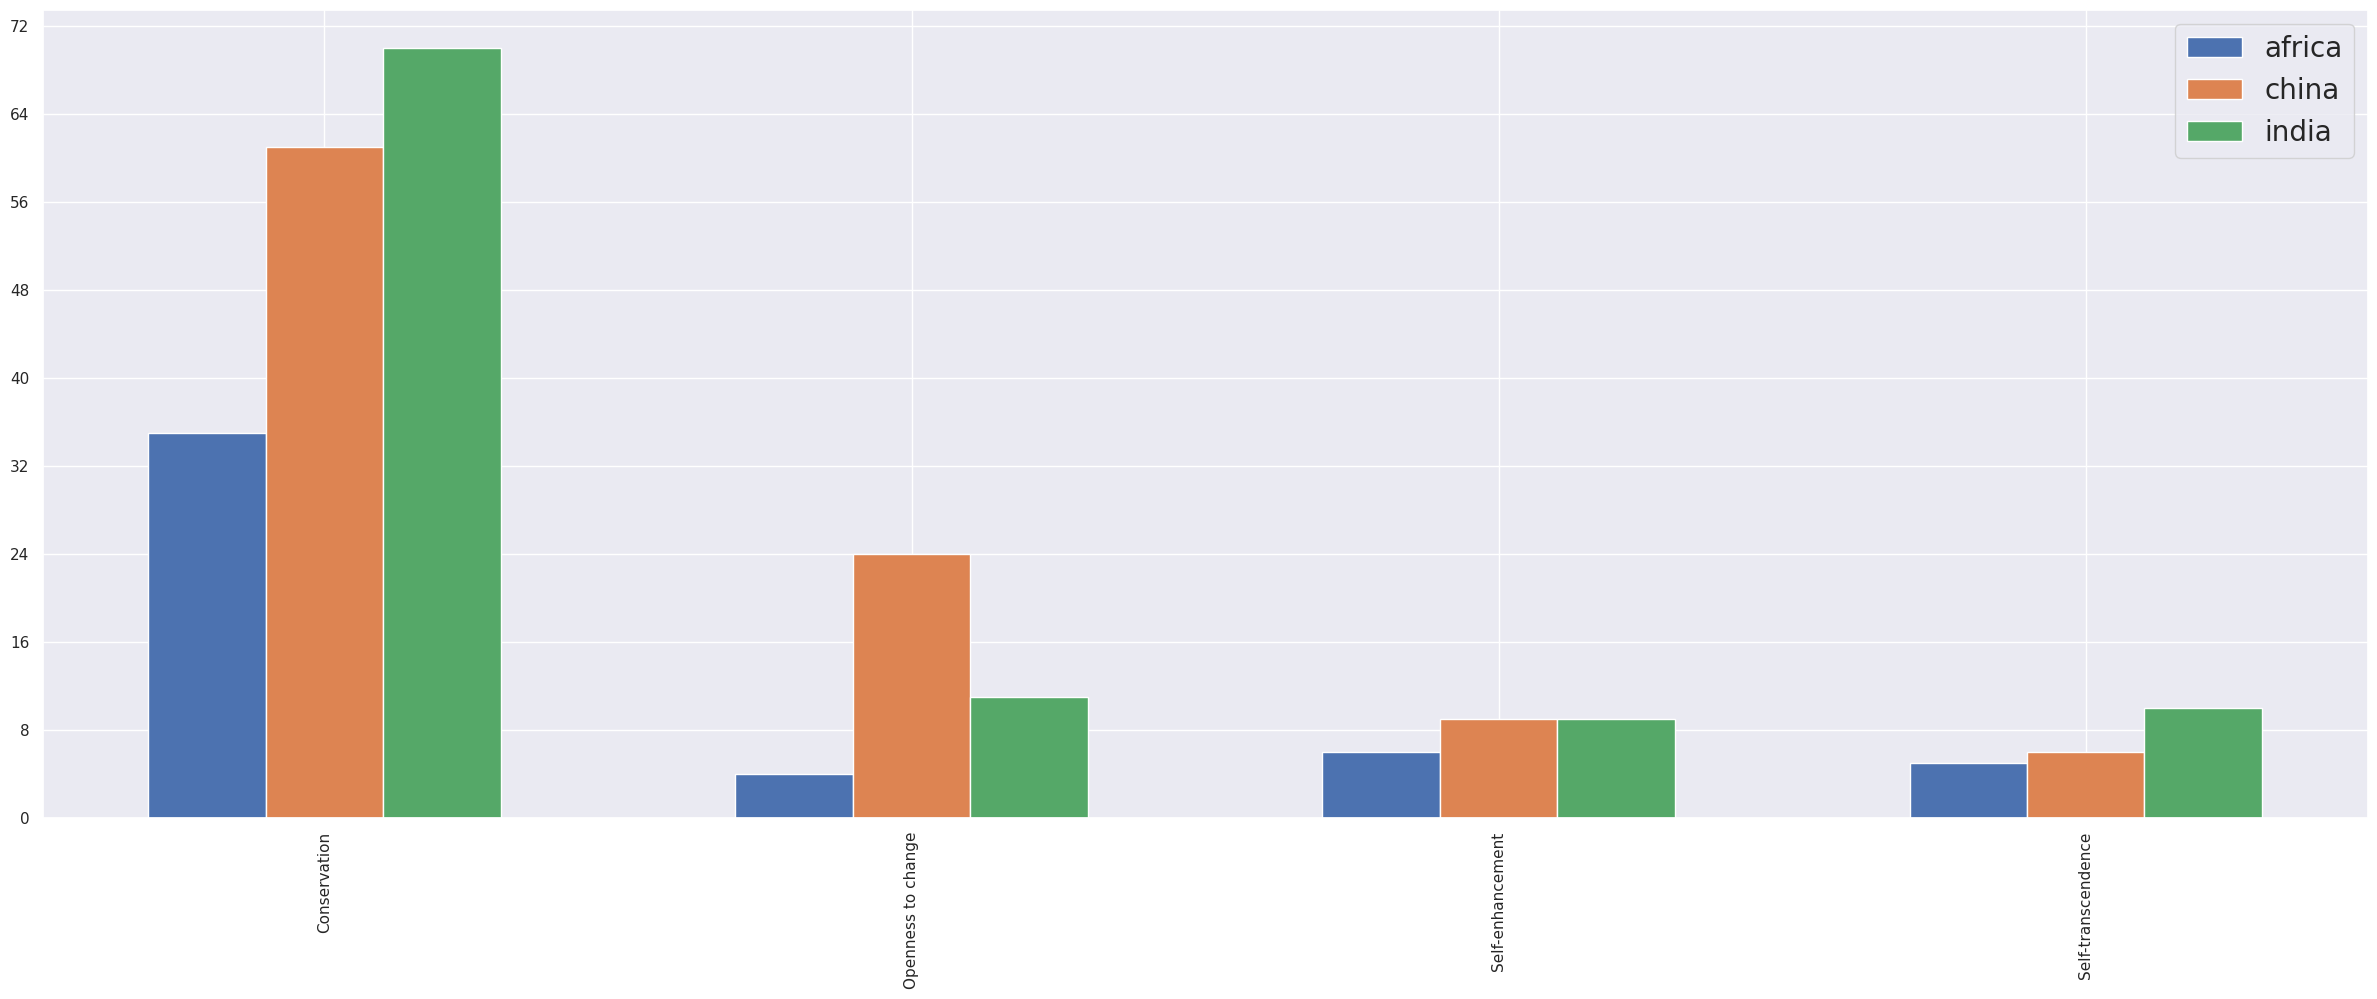

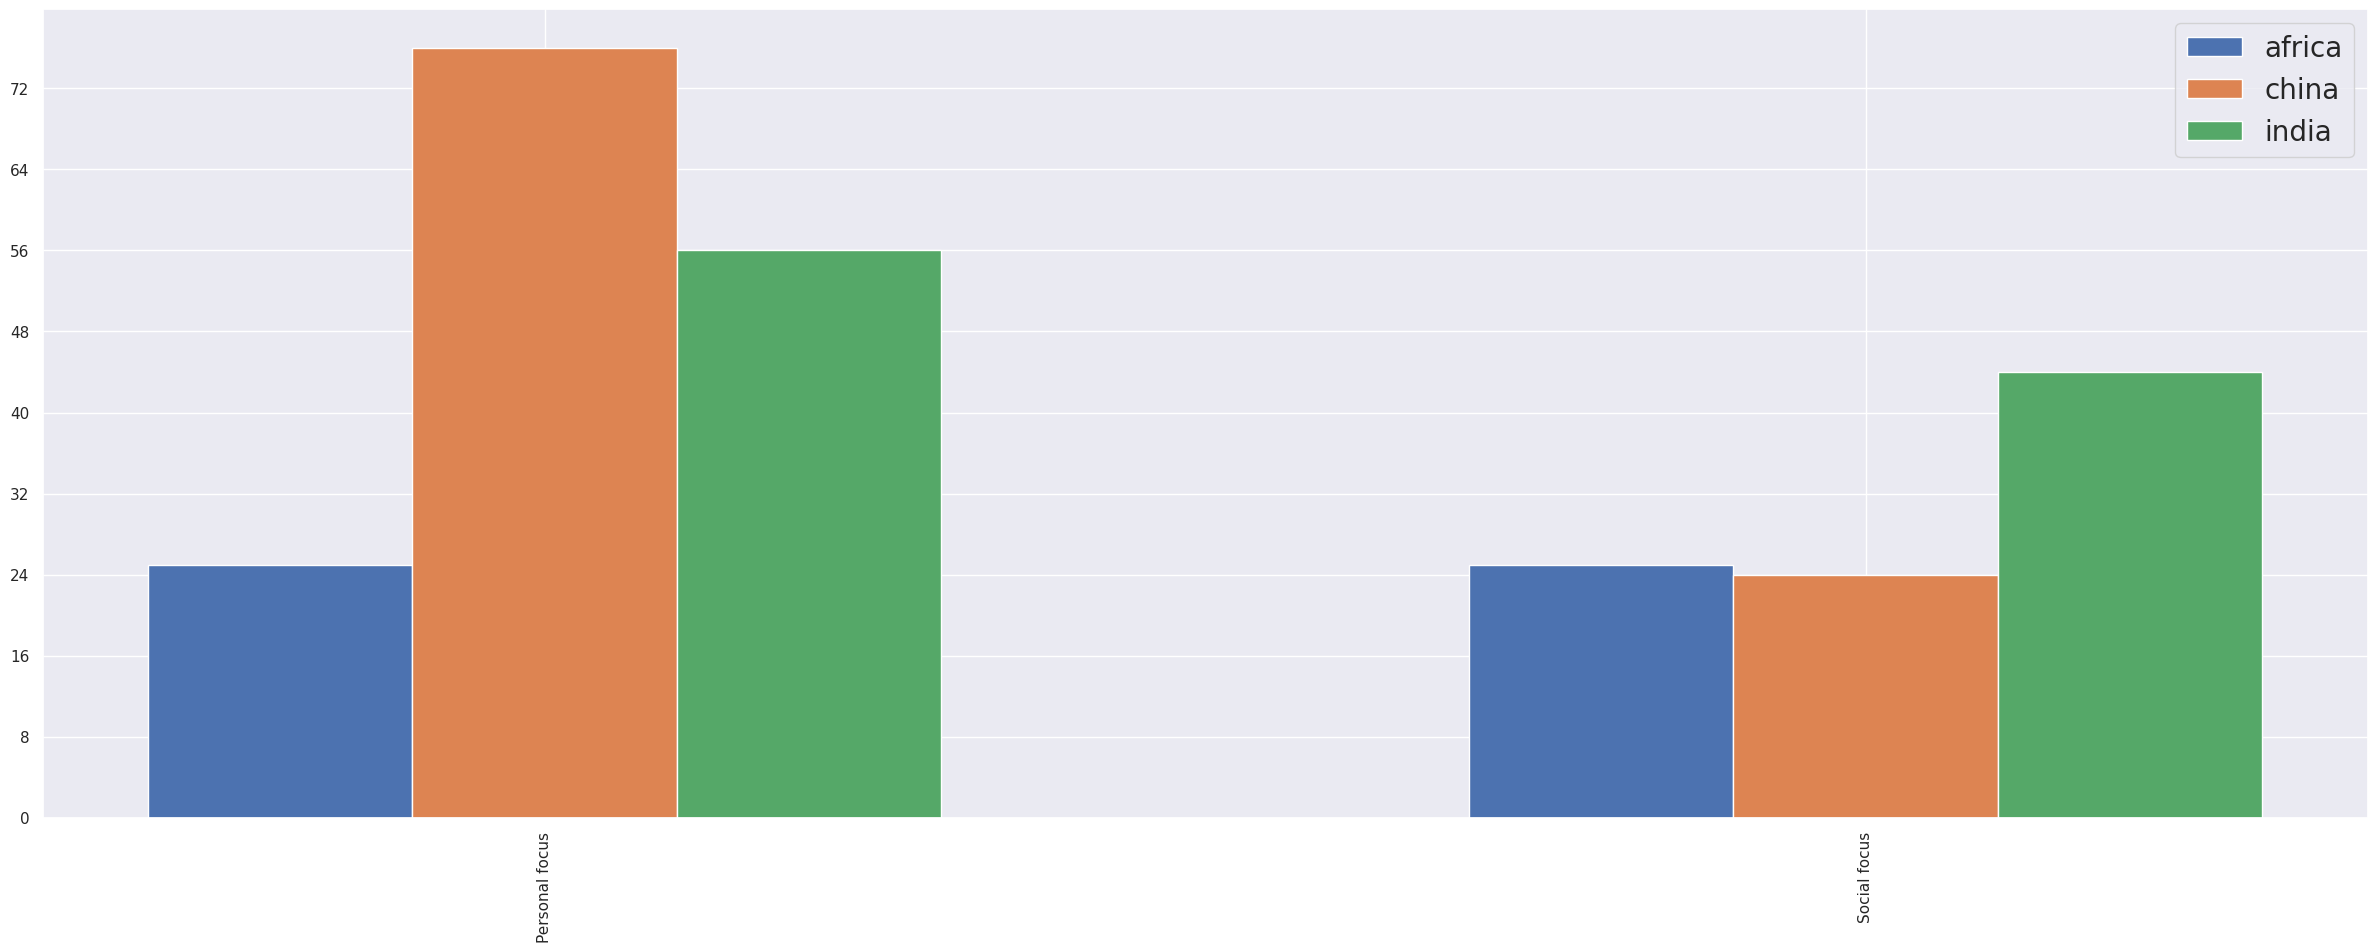

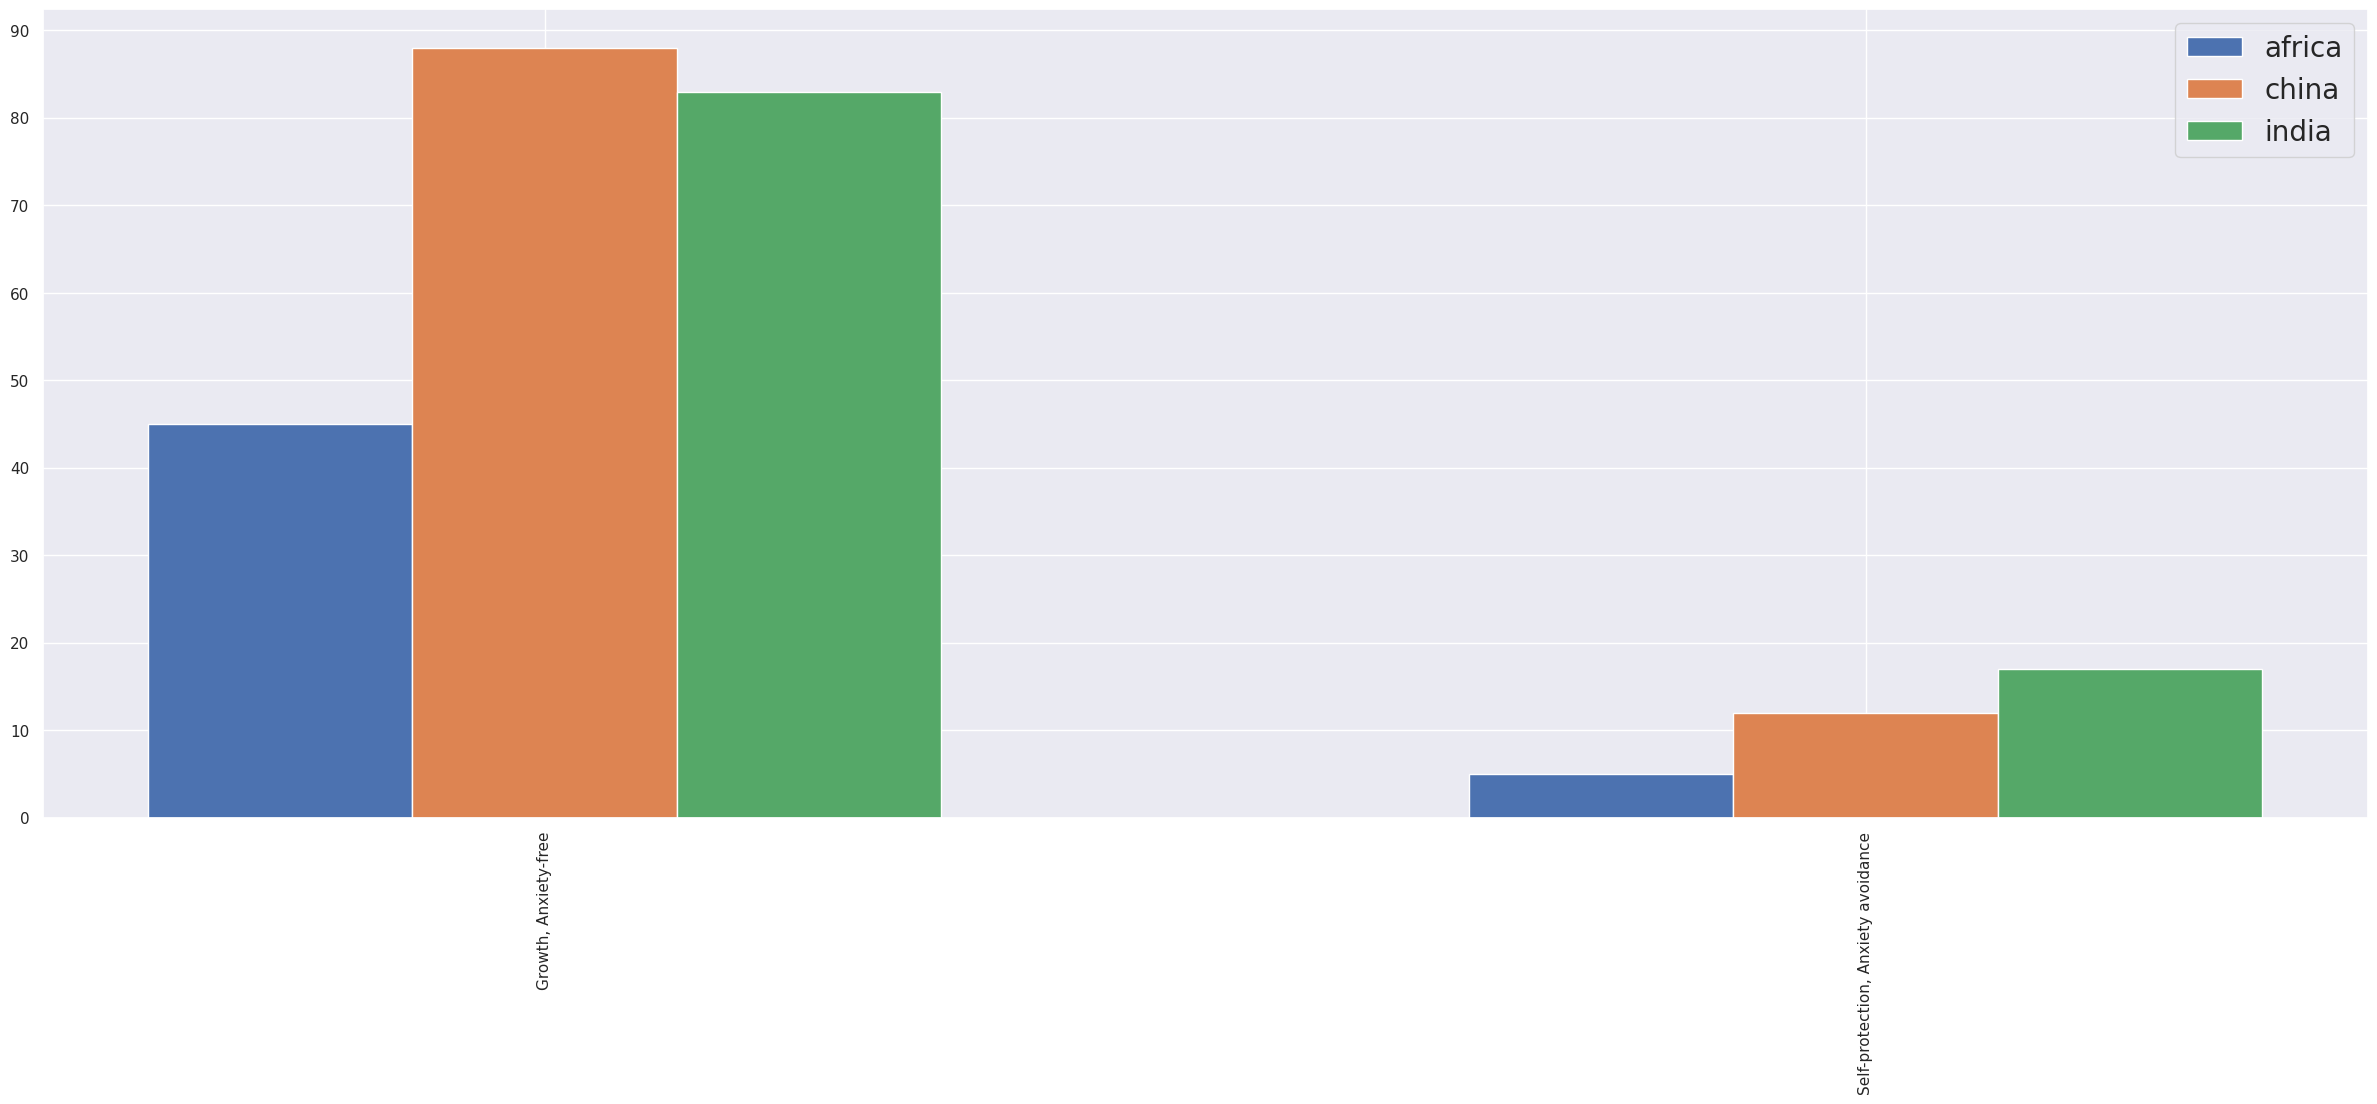

In [ ]:
for i in range(len(levels)):
  arguments_plot(i, df_africa[i], df_china[i], df_india[i])

## Dataset Preprocessing

In [ ]:
df = df_full_levels[1]
df.head()

,Argument ID,Part,Usage,Conclusion,Stance,Premise,Achievement,Benevolence: caring,Benevolence: dependability,Conformity: interpersonal,...,Security: personal,Security: societal,Self-direction: action,Self-direction: thought,Stimulation,Tradition,Universalism: concern,Universalism: nature,Universalism: objectivity,Universalism: tolerance
0,A01001,usa,train,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,A01002,usa,train,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,A01003,usa,train,We should abandon marriage,against,marriage is the ultimate commitment to someone...,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,A01004,usa,train,We should ban naturopathy,against,it provides a useful income for some people,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,A01005,usa,train,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [ ]:
df["Conclusion"] = df["Conclusion"].str.lower()
df["Premise"] = df["Premise"].str.lower()
df.head()

,Argument ID,Part,Usage,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,usa,train,entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01002,usa,train,we should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01003,usa,train,we should abandon marriage,against,marriage is the ultimate commitment to someone...,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01004,usa,train,we should ban naturopathy,against,it provides a useful income for some people,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A01005,usa,train,we should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(df.iloc[0])

Argument ID                                                              A01001
Part                                                                        usa
Usage                                                                     train
Conclusion                                       entrapment should be legalized
Stance                                                              in favor of
Premise                       if entrapment can serve to more easily capture...
Self-direction: thought                                                       0
Self-direction: action                                                        0
Stimulation                                                                   0
Hedonism                                                                      0
Achievement                                                                   0
Power: dominance                                                              0
Power: resources                        

In [ ]:
df.shape

(5270, 26)

In [ ]:
train_arguments, valid_arguments, test_arguments = split_arguments(df)
print(train_arguments.iloc[0])
labels_test = test_arguments.drop(columns=['Part', 'Conclusion','Stance', 'Premise'  ])
labels_test.head()

Argument ID                                                              A01001
Part                                                                        usa
Conclusion                                       entrapment should be legalized
Stance                                                              in favor of
Premise                       if entrapment can serve to more easily capture...
Self-direction: thought                                                       0
Self-direction: action                                                        0
Stimulation                                                                   0
Hedonism                                                                      0
Achievement                                                                   0
Power: dominance                                                              0
Power: resources                                                              0
Face                                    

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A05039,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,A05040,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A05041,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A05042,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A05044,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(f"DATASET DIMENSIONS:\n\t - train\t:\t {train_arguments.shape}\n\t - validation\t:\t {valid_arguments.shape}\n\t - test\t\t:\t {test_arguments.shape}")

DATASET DIMENSIONS:
	 - train	:	 (4240, 25)
	 - validation	:	 (277, 25)
	 - test		:	 (753, 25)


In [ ]:
def onehot2values(values : list,
                  onehot_vector):
  """
  Given one-hot encoded list of values, this function returns
  the corresponding list of arguments.
  """
  bool_mask = list(map(bool,onehot_vector))

  return " - ".join(np.array(values)[bool_mask].tolist())


def balance_dataset(unbalancd_dataset : pd.DataFrame,
                    unabalanced_labels : list = ['Part'],
                    even_distribution : bool = True,
                    max_threshold : int = 20,
                    reduction_fraction_labels : list = [0.1],
                    seed : int = 42) -> pd.DataFrame:
  """
  Balance the input dataset `unbalancd_dataset` by changing the distribution of
  data for the labels specified in `unabalanced_labels`.

  Depedning on the value of `even_distribution`, the balancing process changes:
  - `even_distribution` == True: the shape of each class is changed with respect
  to the maximum between the least numerous value and `max_threshold`;
  - `even_distribution` == False: each label is reduced by a fraction specified
  in `reduction_fraction_labels`.

  If label_i == 'Arguments' then the returned dataset will contain a balanced
  distribution of the one-hot encoded version of all the argument features.
  """
  sampled_list = []

  if even_distribution:
    # reduce everything wrt to
    for label in unabalanced_labels:
      if label != 'Arguments':

        vals = unbalancd_dataset[label].value_counts(normalize=False)
        lowest_stat = int(max(vals.min(),max_threshold))

        sampled_list.append(unbalancd_dataset.groupby(label).sample(n=lowest_stat,
                                                                    replace=False,
                                                                    random_state=seed))

      else:
        # columns [5->..] contains all the argument values
        one_hot_args = unbalancd_dataset[unbalancd_dataset.columns[5:]].values.tolist()
        balanced_df = unbalancd_dataset.drop(unbalancd_dataset.columns[5:], axis=1)
        balanced_df['args'] = one_hot_args

        # distribution for each combinations of arguments
        vc_dict = {}
        onehot2str = lambda x : str(x)
        onehot2perc = lambda x : vc_dict[x]

        balanced_df['args'] = balanced_df['args'].apply(onehot2str)
        vc = balanced_df['args'].value_counts(normalize=False)
        vc_dict = vc.to_dict()

        # '#' column indicates the number of instances sharing the argument values
        balanced_df['#'] = balanced_df['args'].apply(onehot2perc)

        # define the number of instances to sample
        vals = balanced_df['args'].value_counts(normalize=False)
        lowest_stat = int(max(vals.min(),max_threshold))

        good_candidates = balanced_df[balanced_df['#'] >= lowest_stat].groupby('args')
        samples = good_candidates.sample(n=lowest_stat,
                                         replace=False,
                                         random_state=seed)
        # drop #
        samples = samples.drop(columns=['#'])

        # Store the new samples and the those rows whose number was alrady
        # under the threshold
        sampled_list.append(samples)
        sampled_list.append(balanced_df[balanced_df['#'] < lowest_stat])
  else:

    for ids, label in enumerate(unabalanced_labels):
      classes = unabalanced_labels[label].unique().tolist()
      for cl in classes:
        n = len(unabalanced_labels[unabalanced_labels[label] == cl])
        perc = reduction_fraction_labels[ids]

        sampled_list.append(unabalanced_labels[unabalanced_labels[label] == cl]\
                            .sample(n=int(perc*n),
                                    replace=False,
                                    random_state=seed))


  balanced_df = pd.concat(sampled_list, axis=0)

  # restore format of 'args' to one_hot array
  str2onehot = lambda x : eval(x)
  balanced_df['args'] = balanced_df['args'].apply(lambda x : str2onehot(x))

  return balanced_df


In [ ]:
one_hot_args = train_arguments[train_arguments.columns[5:]].values.tolist()
unbalance_df = train_arguments.drop(train_arguments.columns[5:], axis=1)
unbalance_df['args'] = one_hot_args

args_values = train_arguments.columns[5:]
cards = unbalance_df['args'].apply(lambda x : onehot2values(args_values,x)).value_counts().values

Let's balance the distribution of value arguments by randomly drawing a subset of those instances sharing their argument values with more than `max_threshold` others. The remaining ones, that is those having a more rare combination of values, are left untouched.

After the balancing, we end up with a set of argument values that are shared at most by `max_threshold` individuals. Training the models on such data should help to prevent the presence of any bias in the predictions.

In [ ]:
balanced_train = balance_dataset(unbalancd_dataset=train_arguments,
                                 unabalanced_labels=['Arguments'],
                                 max_threshold = 10,
                                 even_distribution=True)

In [ ]:
print(tabulate([["Dataset","cardinality"],["Unbalanced",len(train_arguments)],["Balanced",len(balanced_train)]],
               headers="firstrow"))

Dataset       cardinality
----------  -------------
Unbalanced           4240
Balanced             3609


In [ ]:
value2count = balanced_train['args'].apply(lambda x : onehot2values(args_values,x)).value_counts()
cards_balanced = value2count.values

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(value2count)

Universalism: objectivity                                                                                                                                      10
Achievement - Power: resources                                                                                                                                 10
Security: personal - Security: societal                                                                                                                        10
Security: personal - Security: societal - Universalism: concern                                                                                                10
Security: personal - Security: societal - Benevolence: caring                                                                                                  10
                                                                                                                                                               ..
Self-direction: action - Hed

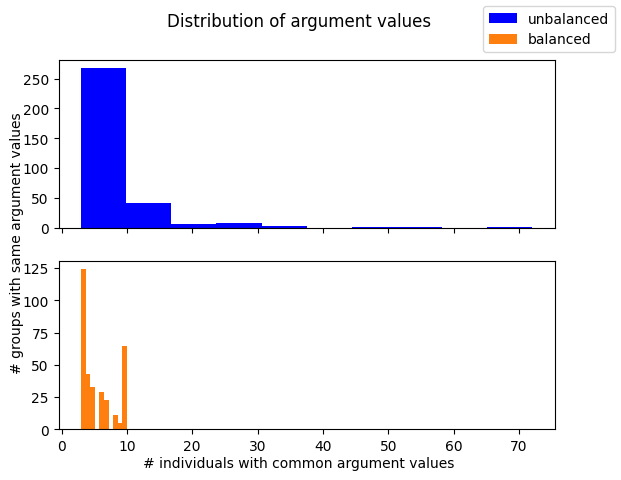

In [ ]:
# exclude combinations appearing only once or twice
cards = list(filter(lambda x: not x in [1,2], cards))
cards_balanced = list(filter(lambda x: not x in [1,2], cards_balanced))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Distribution of argument values')
ax1.hist(cards, color='b', label='unbalanced')
ax2.hist(cards_balanced, color='C1', label='balanced')

fig.text(0.5, 0.04, '# individuals with common argument values', ha='center', va='center')
fig.text(0.06, 0.5, '# groups with same argument values', ha='center', va='center', rotation='vertical')

fig.legend()
fig.show()

The dataset has now a more homogeneous distribution as we've balanced the sets of values occurring more than 10 times which were introducing a bias. By doing so, as the training dataset contains only instances from the USA, we expect to achieve better performances at testing time for data from Eastern countries, too.

## 1.Models Evaluation

<a id='section01'></a>

### Preparing the Dataset and Dataloader for models evaluation

1. Creation of CustomDataset class - This defines how the text is pre-processed before sending it to the neural network.
2. Definiition of the Dataloader that will feed  the data in batches to the neural network for suitable training and processing.

#### *CustomDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT/ROBERTA/DISTILBERT model for training.
- We are using the BERT/ROBERTA/DISTILBERT tokenizer to tokenize the data in the `text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids` (*the latter is not generated by DISTILBERT tokenizer*)

- `targets` is the list of categories labled as `0` or `1` in the dataframe.
- The *CustomDataset* class is used to create 3 datasets, for training, for validation and for test.

In [ ]:
train_arguments['labels'] = train_arguments[train_arguments.columns[5:]].values.tolist()
train_arguments['text'] = train_arguments.Conclusion+" [SEP] "+train_arguments.Stance+" [SEP] "+train_arguments.Premise+" [SEP] "
df_train = train_arguments[['text', 'labels']].copy()
df_train.head()

,text,labels
0,entrapment should be legalized [CLS] in favor ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,we should ban human cloning [CLS] in favor of ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,we should abandon marriage [CLS] against [SEP]...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,we should ban naturopathy [CLS] against [SEP] ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,we should ban fast food [CLS] in favor of [SEP...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
print(df_train.iloc[0][0])
print(df_train.iloc[0][1])
print(len(df_train.iloc[0][1]))

entrapment should be legalized [CLS] in favor of [SEP] if entrapment can serve to more easily capture wanted criminals, then why shouldn't it be legal? [SEP] 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
20


In [ ]:
test_arguments['labels'] = test_arguments[test_arguments.columns[5:]].values.tolist()
test_arguments['text'] = test_arguments.Conclusion+" [SEP] "+test_arguments.Stance+" [SEP] "+test_arguments.Premise+" [SEP]"
df_test = test_arguments[['text', 'labels']].copy()
df_test.head()

,text,labels
0,we should subsidize student loans [CLS] in fav...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
1,we should legalize sex selection [CLS] against...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,we should oppose collectivism [CLS] in favor o...,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,we should ban missionary work [CLS] in favor o...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,we should limit judicial activism [CLS] in fav...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
print(df_test.iloc[0][0])
print(df_test.iloc[0][1])

we should subsidize student loans [CLS] in favor of [SEP] student loans set children up to be valuable citizens and the state should support this [SEP]
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
valid_arguments['labels'] = valid_arguments[valid_arguments.columns[5:]].values.tolist()
valid_arguments['text'] = valid_arguments.Conclusion+"[SEP]"+valid_arguments.Stance+"[SEP] "+valid_arguments.Premise+"[SEP]"
df_val = valid_arguments[['text', 'labels']].copy()
print(df_val.iloc[0][0])
print(df_val.iloc[0][1])
df_val.head()

we should subsidize vocational education[CLS]in favor of[SEP] we should subsidize vocational education to encourage more trade schools to open.[SEP]
[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]


,text,labels
0,we should subsidize vocational education[CLS]i...,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, ..."
1,we should abandon television[CLS]in favor of[S...,"[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,we should ban targeted killing[CLS]against[SEP...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,we should adopt atheism[CLS]in favor of[SEP] w...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,we should abandon television[CLS]in favor of[S...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#finding suitable maxlength

from scipy.stats import percentileofscore

lens = []
for s in df_test['text']:
  lens.append(len(s.split(' ')))
max_length=max(lens)
print(max_length)

147


In [ ]:
# Definition of global variables
MODEL_NAMES=['bert-base-uncased','bert-large-uncased','roberta-base','roberta-large', 'distilbert-base-uncased'  ]


MAX_LEN = 143
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 2e-05


In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }


### Creating the Neural Network for Fine Tuning (both for the Models evaluation and the Input evaluations)

We will create two neural networks for fine-tuning: one with the BERT model and the other with the DistilBERT model. Each network will consist of a pre-trained language model, a Dropout layer for regularization, and a linear layer for classification.

The BERTClass network will use the BERT model followed by a Dropout and a linear layer. The DistilBERTClass network will use the DistilBERT model, followed by a Dropout and a linear layer. Both networks will have the same output dimensionality of 20.

Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is used to update the weights of the neural network to improve its performance.


In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(OUT_CHANNELS, 20)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [ ]:
class DistilbertClass(torch.nn.Module):
    def __init__(self,model):
        super(DistilbertClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(OUT_CHANNELS, 20)

    def forward(self, ids, mask, token_type_ids):
        output_1 = self.l1(input_ids=ids, attention_mask=mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)

        return output

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

Defining the Training Function


In [ ]:
def train():
    size = len(training_loader.dataset)
    #print(size)
    model.train()

    for batch,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch%100==0:
            current =  batch * len(data['ids'])
            with open('/content/drive/MyDrive/NLP assignments/out.txt', 'w') as f:
              print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]", file=f)
              print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

Defining the Validation Function

In [ ]:
def validation(epoch, val_loss_min_input):
    MODEL_NAME_pt=str(MODEL_NAME+".pth")
    size = len(testing_loader.dataset)
    num_batches = len(testing_loader)
    model.eval()
    val_loss = 0
    #fin_targets=[]
    #fin_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            val_loss += loss_fn(outputs, targets).item()

        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        with open('/content/drive/MyDrive/NLP assignments/out.txt', 'w') as f:
          print(f"\nValidation loss: {val_loss:>8f}.", file=f)
          ## TODO: save the model if validation loss has decreased
          if val_loss <= val_loss_min_input:
              #create checkpoint variable and add important data
              if epoch > 0:
                  print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss), file=f)
                  print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))

              else:
                print('Saving model ...', file=f)
                print('Saving model ...')

              # save best moel
              torch.save(model.state_dict(), MODEL_NAME_pt)
              print("Saved PyTorch Model State to [MODEL_NAME].pth\n", file=f)
              print("Saved PyTorch Model State to [MODEL_NAME].pth\n")
              val_loss_min_input = val_loss

    return val_loss_min_input


Defining the Testing Function

In [ ]:
def test():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

### Fine-tuning, Validating and Testing the models

In [ ]:
path = '/content/'
#MODEL_NAMES=['bert-base-uncased','bert-large-uncased','roberta-base','roberta-large', 'distilbert-base-uncased'  ]
best_weights_bert_base = path + 'bert-base-uncased.pth'
best_weights_bert_large = path + 'bert-large-uncased.pth'
best_weights_roberta_base = path + 'roberta-base.pth'
best_weights_roberta_large = path + 'roberta-large.pth'
best_weights_distilbert = path + 'distilbert-base-uncased.pth'
weights = [best_weights_bert_base,best_weights_bert_large, best_weights_roberta_base, best_weights_roberta_large, best_weights_distilbert]

In [ ]:
#filename='out.txt'
i=0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TRAIN Dataset: (4240, 2)
TEST Dataset: (753, 2)
__________________________________________________________________________________
=================================bert-base-uncased===================================
Epoch 1
-------------------------------
Train loss: 0.674017  [    0/ 4240]
Train loss: 0.422506  [  800/ 4240]
Train loss: 0.419454  [ 1600/ 4240]
Train loss: 0.373462  [ 2400/ 4240]
Train loss: 0.347045  [ 3200/ 4240]
Train loss: 0.327979  [ 4000/ 4240]
Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 2
-------------------------------
Train loss: 0.212356  [    0/ 4240]
Train loss: 0.311676  [  800/ 4240]
Train loss: 0.318041  [ 1600/ 4240]
Train loss: 0.329551  [ 2400/ 4240]
Train loss: 0.300051  [ 3200/ 4240]
Train loss: 0.295508  [ 4000/ 4240]
Validation loss decreased (0.35507072 --> 0.33888319).  Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 3
-------------------------------
Train loss: 0.201048  [    0/ 4240]
Train loss:

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


THRESHOLD: 0.10  F1 score: 0.336
THRESHOLD: 0.15  F1 score: 0.333
THRESHOLD: 0.20  F1 score: 0.321
THRESHOLD: 0.25  F1 score: 0.310
THRESHOLD: 0.30  F1 score: 0.279
THRESHOLD: 0.35  F1 score: 0.268
THRESHOLD: 0.40  F1 score: 0.258
THRESHOLD: 0.45  F1 score: 0.237
THRESHOLD: 0.50  F1 score: 0.212
THRESHOLD: 0.55  F1 score: 0.178
THRESHOLD: 0.60  F1 score: 0.148
THRESHOLD: 0.65  F1 score: 0.121
THRESHOLD: 0.70  F1 score: 0.098
THRESHOLD: 0.75  F1 score: 0.068
THRESHOLD: 0.80  F1 score: 0.033
THRESHOLD: 0.85  F1 score: 0.013
BEST THRESHOLD: 0.1 with F1 score: 0.34
_Classification Report_
_______________________
                            precision    recall  f1-score   support

   Self-direction: thought       0.25      0.80      0.38       110
    Self-direction: action       0.28      0.95      0.44       184
               Stimulation       0.14      0.33      0.19        30
                  Hedonism       0.08      0.17      0.11         6
               Achievement       0.37      

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TRAIN Dataset: (4240, 2)
TEST Dataset: (753, 2)
__________________________________________________________________________________
=================================bert-large-uncased===================================
Epoch 1
-------------------------------
Train loss: 0.584604  [    0/ 4240]
Train loss: 0.409407  [  800/ 4240]
Train loss: 0.409273  [ 1600/ 4240]
Train loss: 0.372976  [ 2400/ 4240]
Train loss: 0.338399  [ 3200/ 4240]
Train loss: 0.309125  [ 4000/ 4240]
Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 2
-------------------------------
Train loss: 0.193993  [    0/ 4240]
Train loss: 0.289674  [  800/ 4240]
Train loss: 0.312253  [ 1600/ 4240]
Train loss: 0.292966  [ 2400/ 4240]
Train loss: 0.261458  [ 3200/ 4240]
Train loss: 0.264756  [ 4000/ 4240]
Validation loss decreased (0.34449356 --> 0.33125012).  Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 3
-------------------------------
Train loss: 0.177007  [    0/ 4240]
Train loss

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


THRESHOLD: 0.10  F1 score: 0.339
THRESHOLD: 0.15  F1 score: 0.344
THRESHOLD: 0.20  F1 score: 0.337
THRESHOLD: 0.25  F1 score: 0.316
THRESHOLD: 0.30  F1 score: 0.307
THRESHOLD: 0.35  F1 score: 0.284
THRESHOLD: 0.40  F1 score: 0.266
THRESHOLD: 0.45  F1 score: 0.247
THRESHOLD: 0.50  F1 score: 0.225
THRESHOLD: 0.55  F1 score: 0.205
THRESHOLD: 0.60  F1 score: 0.177
THRESHOLD: 0.65  F1 score: 0.153
THRESHOLD: 0.70  F1 score: 0.121
THRESHOLD: 0.75  F1 score: 0.086
THRESHOLD: 0.80  F1 score: 0.062
THRESHOLD: 0.85  F1 score: 0.037
BEST THRESHOLD: 0.15 with F1 score: 0.34
_Classification Report_
_______________________
                            precision    recall  f1-score   support

   Self-direction: thought       0.27      0.65      0.38       110
    Self-direction: action       0.45      0.81      0.58       184
               Stimulation       0.40      0.07      0.11        30
                  Hedonism       1.00      0.00      0.00         6
               Achievement       0.40     

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TRAIN Dataset: (4240, 2)
TEST Dataset: (753, 2)
__________________________________________________________________________________
=================================roberta-base===================================
Epoch 1
-------------------------------
Train loss: 0.724804  [    0/ 4240]
Train loss: 0.387614  [  800/ 4240]
Train loss: 0.408010  [ 1600/ 4240]
Train loss: 0.377973  [ 2400/ 4240]
Train loss: 0.336399  [ 3200/ 4240]
Train loss: 0.310020  [ 4000/ 4240]
Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 2
-------------------------------
Train loss: 0.206946  [    0/ 4240]
Train loss: 0.275952  [  800/ 4240]
Train loss: 0.304128  [ 1600/ 4240]
Train loss: 0.309871  [ 2400/ 4240]
Train loss: 0.262115  [ 3200/ 4240]
Train loss: 0.282989  [ 4000/ 4240]
Validation loss decreased (0.34409076 --> 0.33073850).  Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 3
-------------------------------
Train loss: 0.183571  [    0/ 4240]
Train loss: 0.25

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


THRESHOLD: 0.10  F1 score: 0.341
THRESHOLD: 0.15  F1 score: 0.352
THRESHOLD: 0.20  F1 score: 0.357
THRESHOLD: 0.25  F1 score: 0.346
THRESHOLD: 0.30  F1 score: 0.335
THRESHOLD: 0.35  F1 score: 0.307
THRESHOLD: 0.40  F1 score: 0.292
THRESHOLD: 0.45  F1 score: 0.279
THRESHOLD: 0.50  F1 score: 0.258
THRESHOLD: 0.55  F1 score: 0.243
THRESHOLD: 0.60  F1 score: 0.218
THRESHOLD: 0.65  F1 score: 0.192
THRESHOLD: 0.70  F1 score: 0.165
THRESHOLD: 0.75  F1 score: 0.136
THRESHOLD: 0.80  F1 score: 0.097
THRESHOLD: 0.85  F1 score: 0.057
BEST THRESHOLD: 0.2 with F1 score: 0.36
_Classification Report_
_______________________
                            precision    recall  f1-score   support

   Self-direction: thought       0.28      0.66      0.39       110
    Self-direction: action       0.43      0.80      0.56       184
               Stimulation       0.40      0.07      0.11        30
                  Hedonism       0.00      0.00      0.00         6
               Achievement       0.52      

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TRAIN Dataset: (4240, 2)
TEST Dataset: (753, 2)
__________________________________________________________________________________
=================================roberta-large===================================
Epoch 1
-------------------------------
Train loss: 0.733198  [    0/ 4240]
Train loss: 0.392930  [  800/ 4240]
Train loss: 0.417985  [ 1600/ 4240]
Train loss: 0.348570  [ 2400/ 4240]
Train loss: 0.312889  [ 3200/ 4240]
Train loss: 0.274668  [ 4000/ 4240]
Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 2
-------------------------------
Train loss: 0.185412  [    0/ 4240]
Train loss: 0.272449  [  800/ 4240]
Train loss: 0.293086  [ 1600/ 4240]
Train loss: 0.290391  [ 2400/ 4240]
Train loss: 0.236644  [ 3200/ 4240]
Train loss: 0.220650  [ 4000/ 4240]
Validation loss decreased (0.32477343 --> 0.31507922).  Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 3
-------------------------------
Train loss: 0.151964  [    0/ 4240]
Train loss: 0.2

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


THRESHOLD: 0.10  F1 score: 0.392
THRESHOLD: 0.15  F1 score: 0.407
THRESHOLD: 0.20  F1 score: 0.397
THRESHOLD: 0.25  F1 score: 0.395
THRESHOLD: 0.30  F1 score: 0.387
THRESHOLD: 0.35  F1 score: 0.374
THRESHOLD: 0.40  F1 score: 0.359
THRESHOLD: 0.45  F1 score: 0.342
THRESHOLD: 0.50  F1 score: 0.318
THRESHOLD: 0.55  F1 score: 0.302
THRESHOLD: 0.60  F1 score: 0.276
THRESHOLD: 0.65  F1 score: 0.249
THRESHOLD: 0.70  F1 score: 0.232
THRESHOLD: 0.75  F1 score: 0.204
THRESHOLD: 0.80  F1 score: 0.160
THRESHOLD: 0.85  F1 score: 0.115
BEST THRESHOLD: 0.15 with F1 score: 0.41
_Classification Report_
_______________________
                            precision    recall  f1-score   support

   Self-direction: thought       0.30      0.72      0.42       110
    Self-direction: action       0.47      0.88      0.61       184
               Stimulation       0.24      0.13      0.17        30
                  Hedonism       0.25      0.17      0.20         6
               Achievement       0.48     

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TRAIN Dataset: (4240, 2)
TEST Dataset: (753, 2)
__________________________________________________________________________________
=================================distilbert-base-uncased===================================
Epoch 1
-------------------------------
Train loss: 0.725295  [    0/ 4240]
Train loss: 0.388965  [  800/ 4240]
Train loss: 0.364511  [ 1600/ 4240]
Train loss: 0.329844  [ 2400/ 4240]
Train loss: 0.333464  [ 3200/ 4240]
Train loss: 0.307153  [ 4000/ 4240]
Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 2
-------------------------------
Train loss: 0.200074  [    0/ 4240]
Train loss: 0.293923  [  800/ 4240]
Train loss: 0.303213  [ 1600/ 4240]
Train loss: 0.294471  [ 2400/ 4240]
Train loss: 0.270504  [ 3200/ 4240]
Train loss: 0.286607  [ 4000/ 4240]
Validation loss decreased (0.34800573 --> 0.33687042).  Saving model ...
Saved PyTorch Model State to [MODEL_NAME].pth

Epoch 3
-------------------------------
Train loss: 0.185271  [    0/ 4240]
Train

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


THRESHOLD: 0.10  F1 score: 0.344
THRESHOLD: 0.15  F1 score: 0.348
THRESHOLD: 0.20  F1 score: 0.339
THRESHOLD: 0.25  F1 score: 0.321
THRESHOLD: 0.30  F1 score: 0.308
THRESHOLD: 0.35  F1 score: 0.292
THRESHOLD: 0.40  F1 score: 0.277
THRESHOLD: 0.45  F1 score: 0.260
THRESHOLD: 0.50  F1 score: 0.242
THRESHOLD: 0.55  F1 score: 0.220
THRESHOLD: 0.60  F1 score: 0.192
THRESHOLD: 0.65  F1 score: 0.166
THRESHOLD: 0.70  F1 score: 0.133
THRESHOLD: 0.75  F1 score: 0.097
THRESHOLD: 0.80  F1 score: 0.071
THRESHOLD: 0.85  F1 score: 0.039
BEST THRESHOLD: 0.15 with F1 score: 0.35
_Classification Report_
_______________________
                            precision    recall  f1-score   support

   Self-direction: thought       0.28      0.70      0.40       110
    Self-direction: action       0.35      0.83      0.50       184
               Stimulation       0.11      0.07      0.08        30
                  Hedonism       0.00      0.00      0.00         6
               Achievement       0.43     

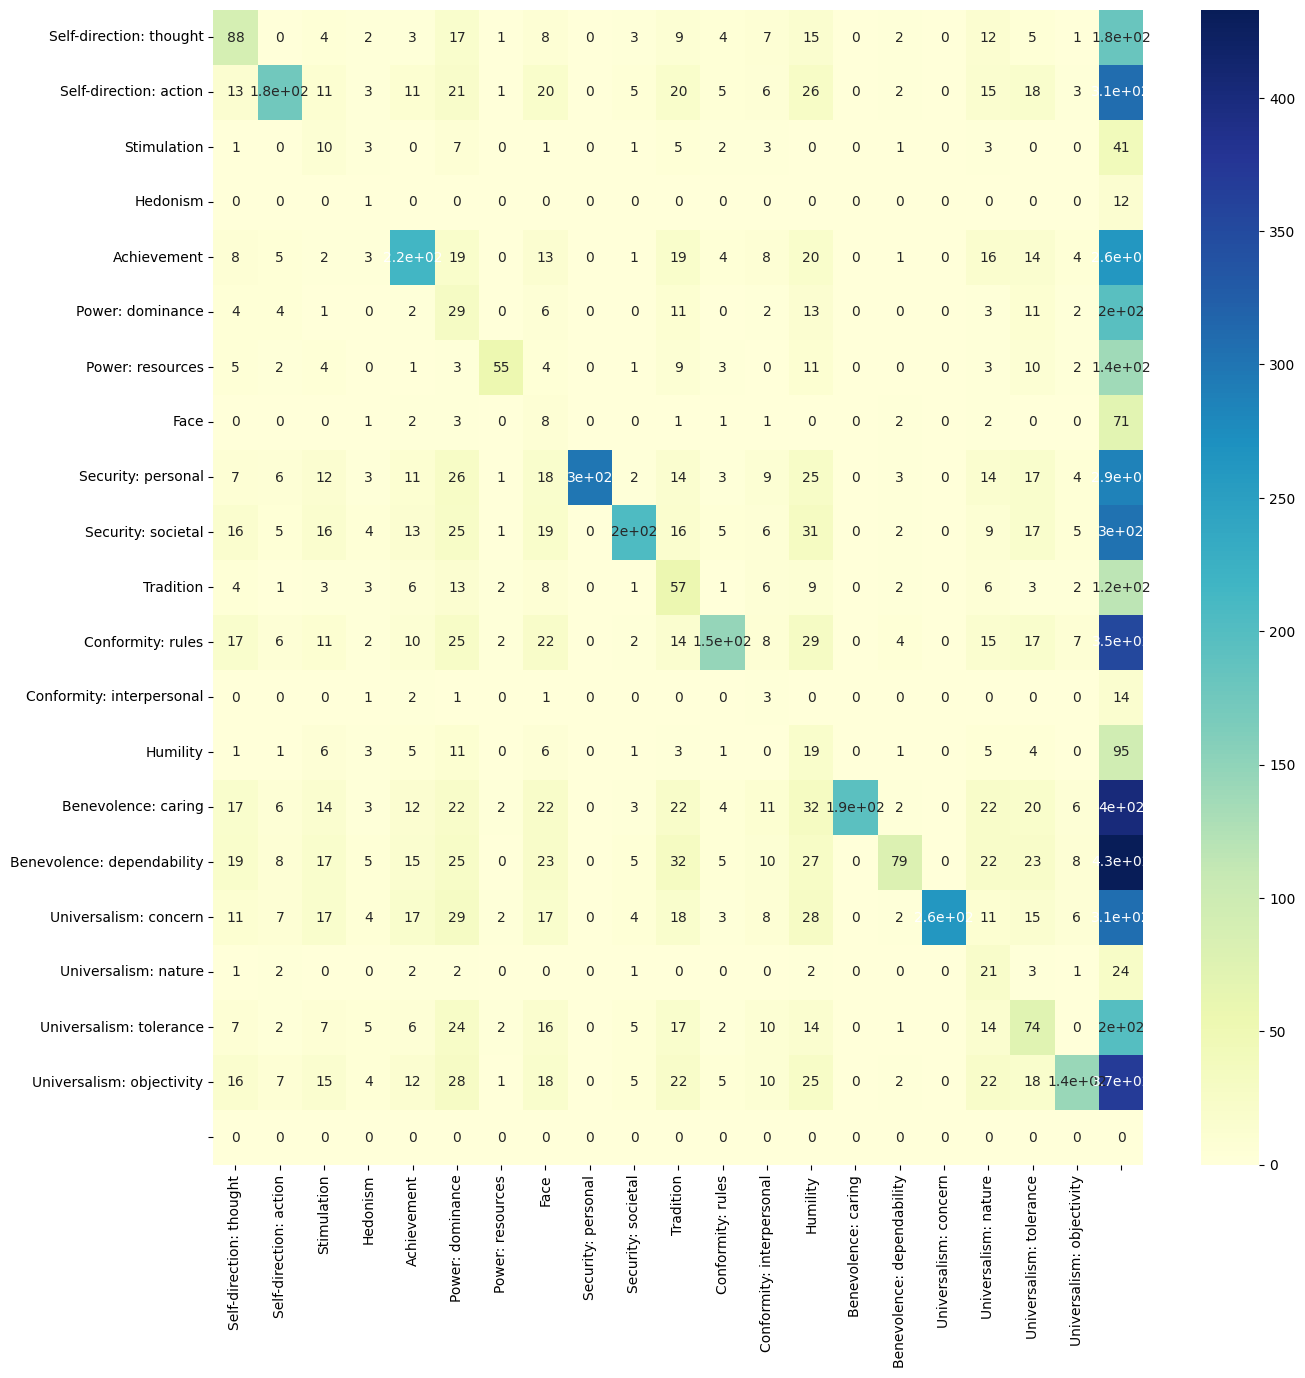

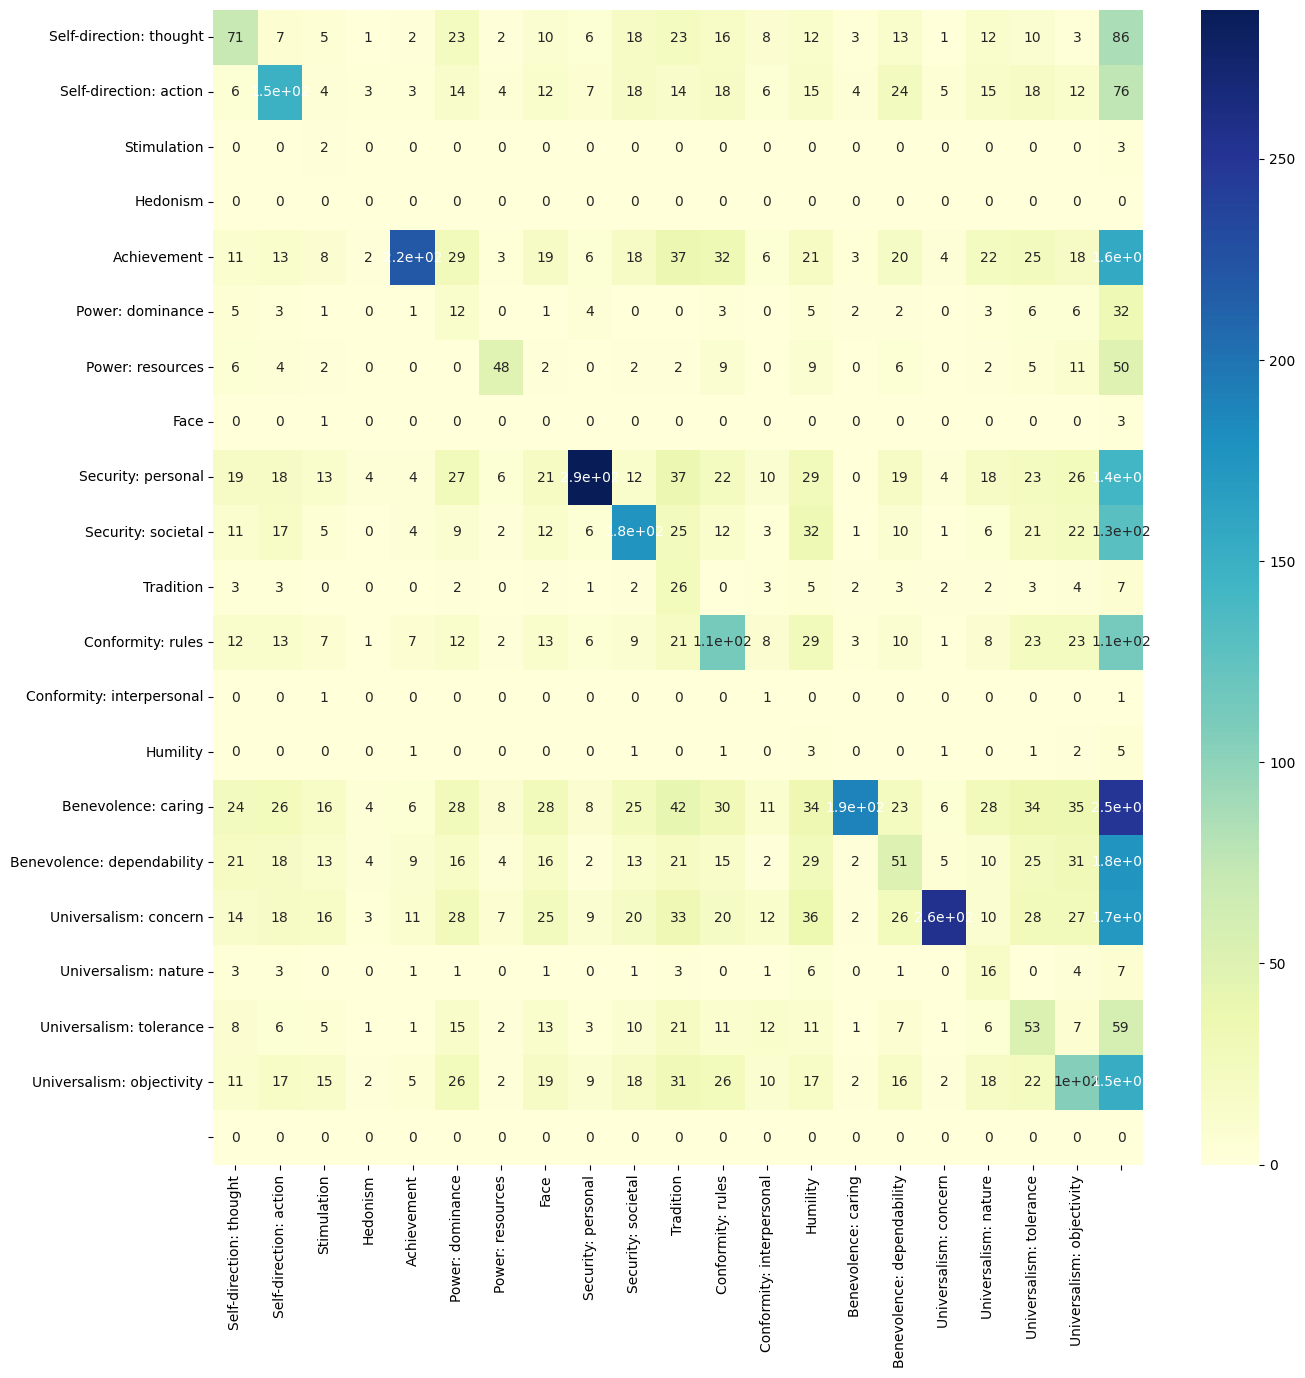

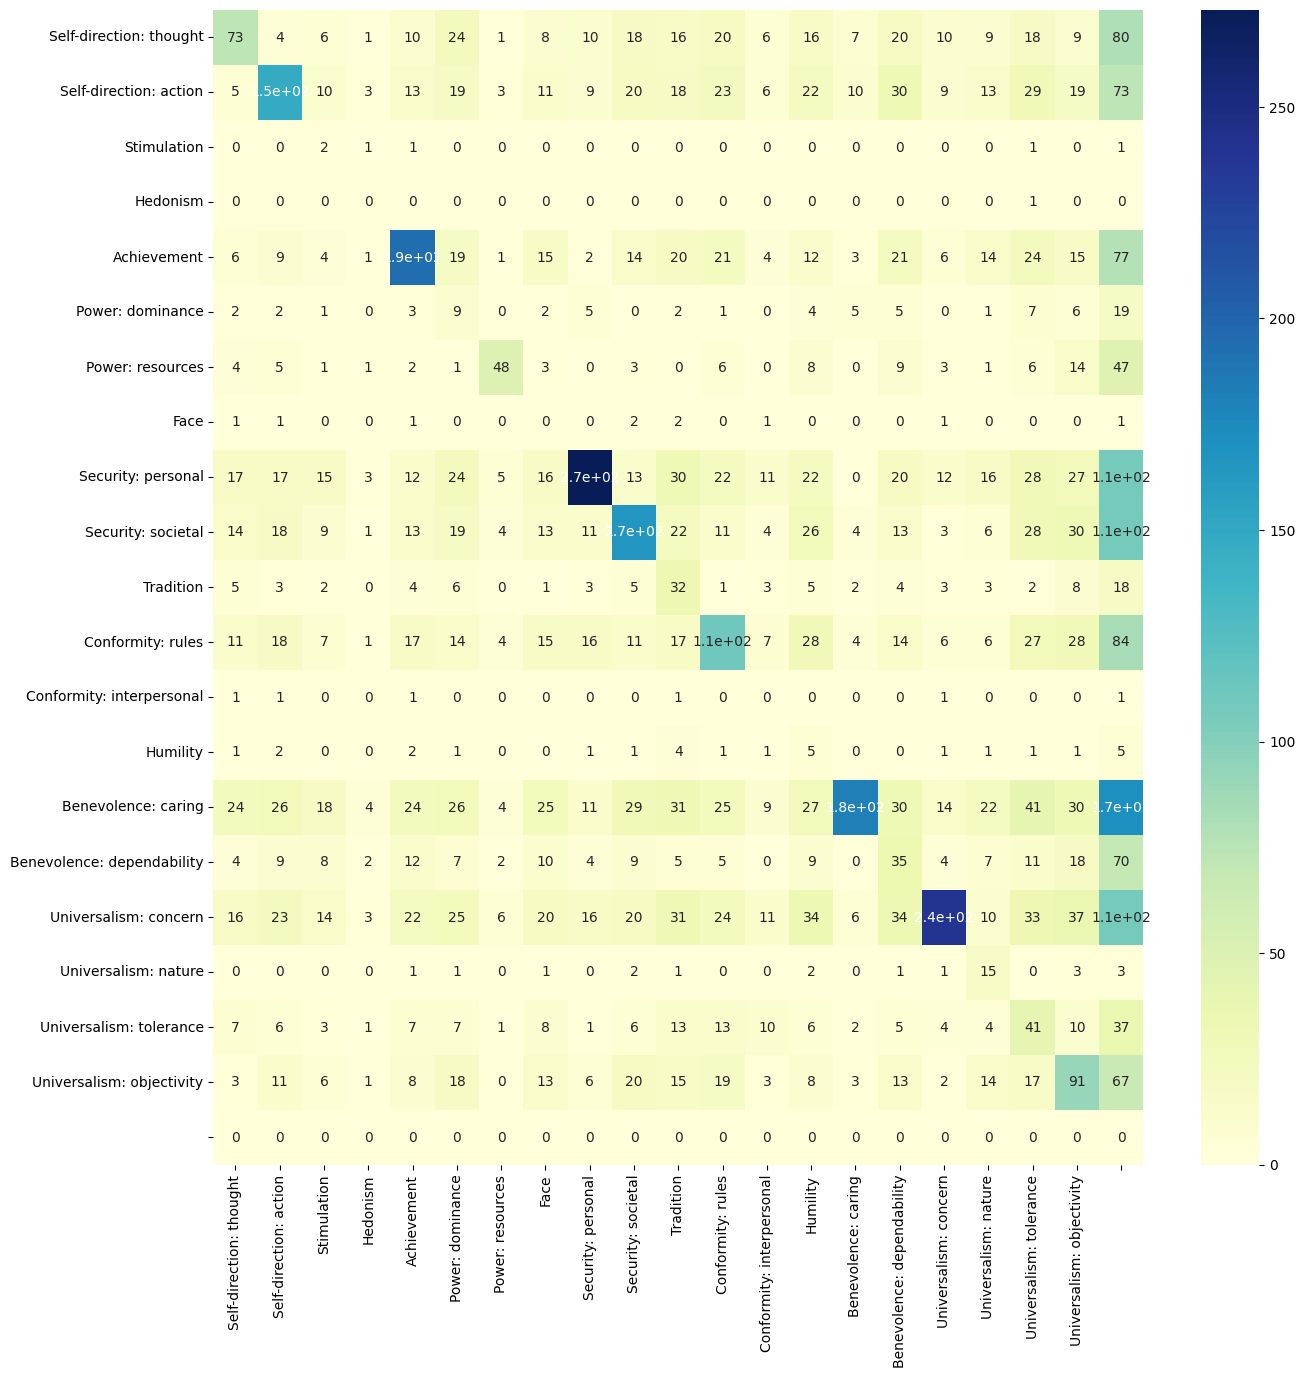

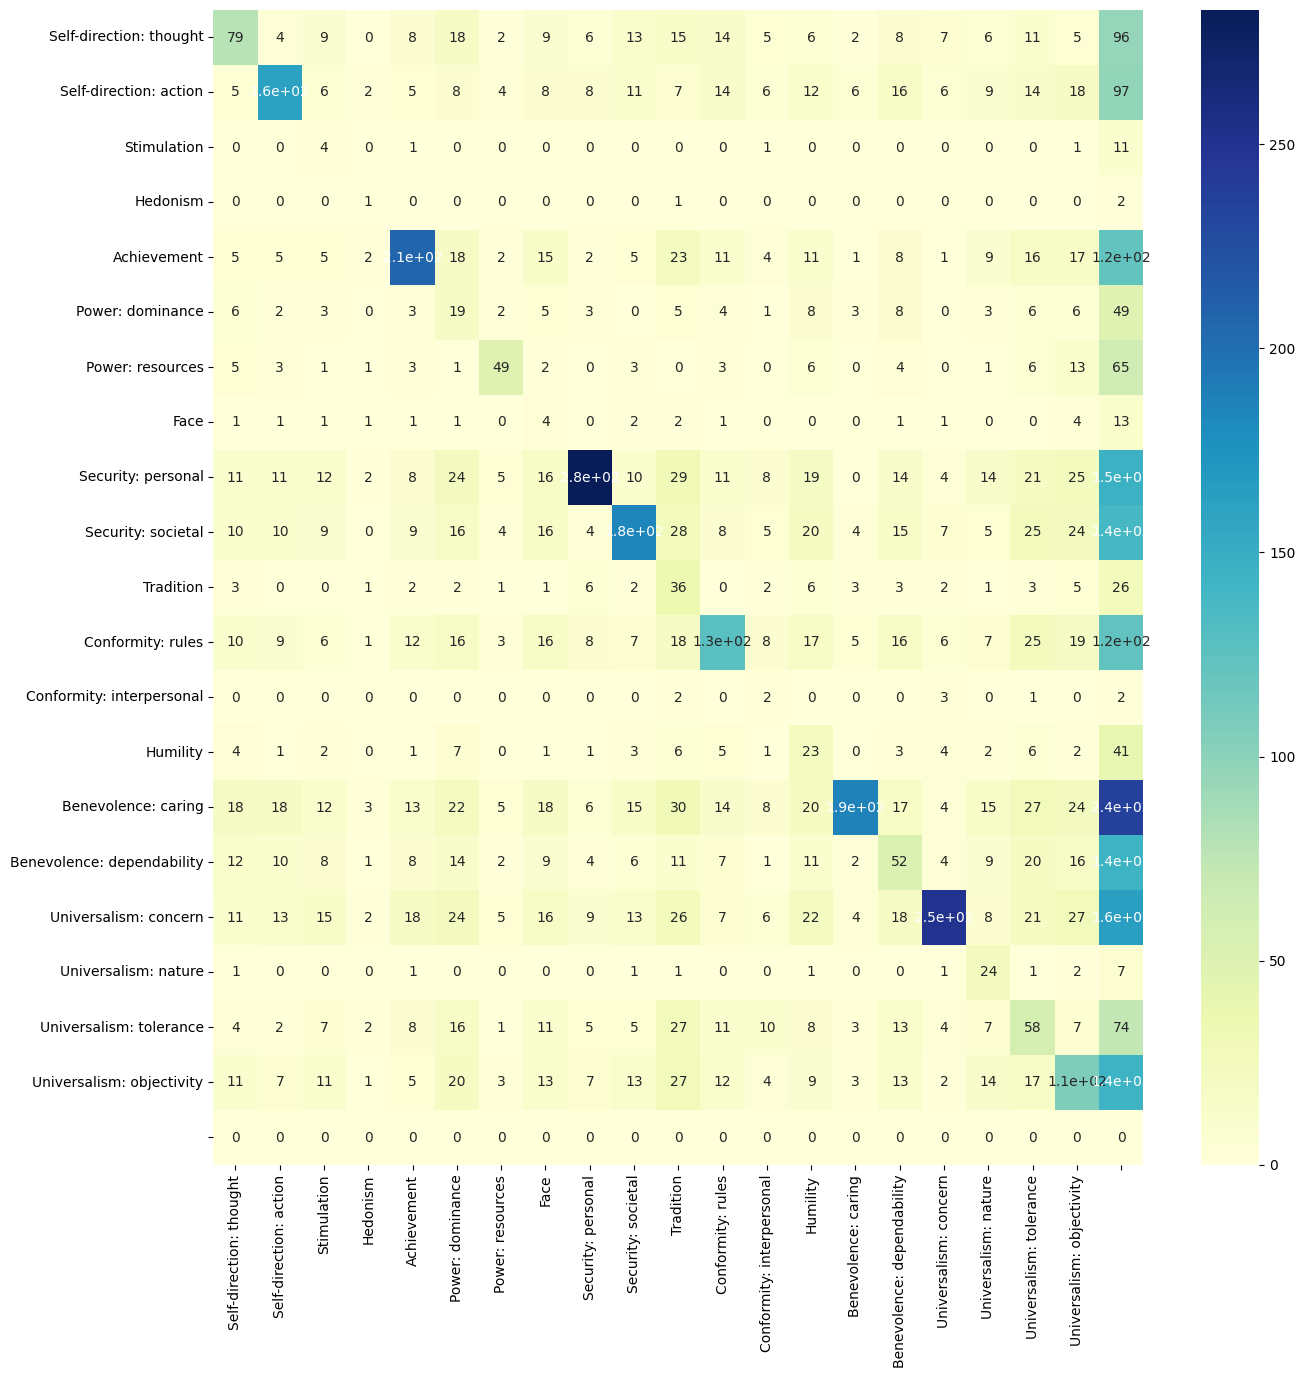

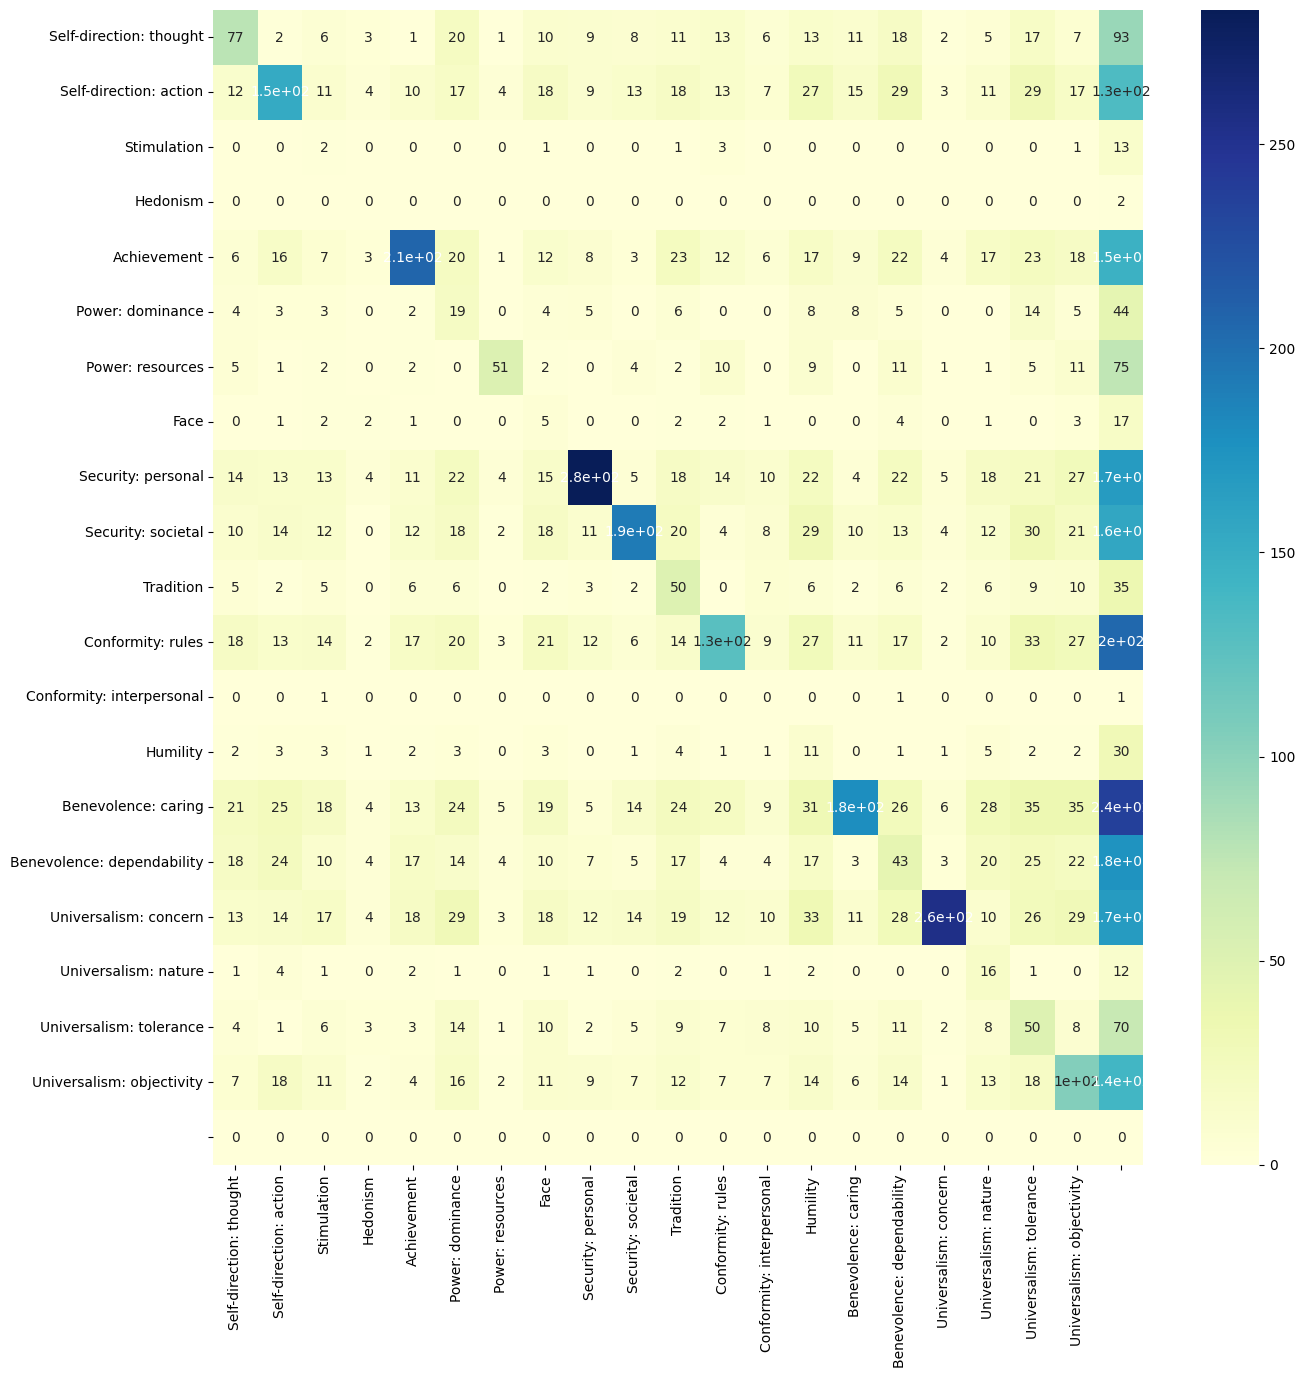

In [ ]:
# training and testing BERT and DistilBERT models
for MODEL_NAME in MODEL_NAMES:
        with open('/content/drive/MyDrive/NLP assignments/out.txt', 'w') as f:
          gc.collect()
          torch.cuda.empty_cache()
          OUT_CHANNELS = 768 if "base" in  MODEL_NAME else 1024
          model = BERTClass(MODEL_NAME) if "distilbert" not in MODEL_NAME else DistilbertClass(MODEL_NAME)
          model.to(device)
          tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
          # Creating the dataset and dataloader for the neural network
          print("TRAIN Dataset: {}".format(df_train.shape))
          print("TEST Dataset: {}".format(df_test.shape))
          training_set = CustomDataset(df_train, tokenizer, MAX_LEN)
          Validation_set = CustomDataset(df_val, tokenizer, MAX_LEN)
          testing_set = CustomDataset(df_test, tokenizer, MAX_LEN)
          training_loader = DataLoader(training_set, batch_size = BATCH_SIZE)
          testing_loader = DataLoader(testing_set, batch_size = BATCH_SIZE)
          optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
          scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(training_loader)*EPOCHS)
          w=weights[i]
          print('__________________________________________________________________________________',file=f)
          print('================================='+MODEL_NAME+'===================================',file=f)
          print('__________________________________________________________________________________')
          print('================================='+MODEL_NAME+'===================================')
          val_loss_min = np.inf
          for epoch in range(EPOCHS):
              print(f"Epoch {epoch+1}\n-------------------------------", file=f)
              print(f"Epoch {epoch+1}\n-------------------------------")
              train()
              val_loss_min = validation(epoch, val_loss_min)
          model = BERTClass(MODEL_NAME) if "distilbert" not in MODEL_NAME else DistilbertClass(MODEL_NAME)
          model.load_state_dict(torch.load(w))
          model = model.to(device)
          outputs, targets = test()
          results = {}
          for tr in np.arange(0.1, 0.9, 0.05):
              tr = round(tr,2)
              predictions = np.array(outputs) >= tr
              f1 = f1_score(targets, predictions, average = "macro", zero_division = 1)
              results[tr] = f1
          for k,v in results.items():
              print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v),file=f)
              print("THRESHOLD: {:.2f} ".format(k), "F1 score: {:.3f}".format(v))
          THRESHOLD = max(results, key = results.get)
          print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())),file=f)
          print("BEST THRESHOLD:", THRESHOLD , "with F1 score: {:.2f}".format(max(results.values())))
          predictions = np.array(outputs) >= THRESHOLD
          labels = labels_test.columns[1:]
          print("_Classification Report_",file=f)
          print("_______________________",file=f)
          print("_Classification Report_")
          print("_______________________")
          print(classification_report(targets,predictions, target_names = labels, zero_division=1))
          conf_mat,normal_conf_mat = mlcm.cm(predictions,targets, print_note=False)
          df_cm = pd.DataFrame(conf_mat, index = [i for i in labels.append(pd.Index([' ']))],
                          columns = [i for i in labels.append(pd.Index([' ']))])
          plt.figure(figsize = (15,15))
          sn.heatmap(df_cm,cmap="YlGnBu", annot=True)
          plt.savefig(MODEL_NAME+'.png')
          i=i+1


## 2.Input Format Evaluation  

<a id='section02'></a>

In [ ]:
# Defining some key variables
MAX_LEN = 143
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 2e-05
OUT_CHANNELS = 768
MODEL_NAME_pt = str('bert-base-uncased'+".pth")

In [ ]:
# initiating an instance BERT-based neural network model
model = BERTClass('bert-base-uncased')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
# Initializing Adam optimizer with the learning rate specified
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

Defining the Training Function

In [ ]:
def train():
    model.train()
    fin_targets=[]
    fin_outputs=[]
    train_loss = 0
    avg_f1_score = 0
    size = len(training_loader.dataset)

    for batch, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    tresh = 0.5
    predictions = np.array(fin_outputs) >= tresh
    f1 = f1_score(fin_targets, predictions, average="macro", zero_division=1)
    avg_f1_score = f1

    train_loss /= size
    print(f"Train Loss: {train_loss:>7f}, Epoch F1 Score: {avg_f1_score:>7f}")

Defining the Validation Function

In [ ]:
def validation(epoch, val_loss_min_input):
    size = len(validation_loader.dataset)
    num_batches = len(validation_loader)
    model.eval()
    val_loss = 0
    fin_targets=[]
    fin_outputs=[]
    avg_f1_score = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            val_loss += loss_fn(outputs, targets).item()
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        val_loss /= num_batches

        tresh = 0.5
        predictions = np.array(fin_outputs) >= tresh
        f1 = f1_score(fin_targets, predictions, average="macro", zero_division=1)
        avg_f1_score += f1

        print(f"Validation Loss: {val_loss:>7f}, Epoch F1 Score: {avg_f1_score:>7f}")

        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            # save best model
            torch.save(model.state_dict(), MODEL_NAME_pt)
            val_loss_min_input = val_loss

    return val_loss_min_input


In [ ]:
# Instantiating the tokenizer that corresponds to the model architecture we are using
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)

Defining the Test Function

In [ ]:
def test():
  model.eval()
  fin_targets=[]
  fin_outputs=[]
  with torch.no_grad():
      for _, data in enumerate(testing_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          outputs = model(ids, mask, token_type_ids)
          fin_targets.extend(targets.cpu().detach().numpy().tolist())
          fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      tresh = 0.5
      predictions = np.array(fin_outputs) >= tresh
      f1 = f1_score(fin_targets, predictions, average = "macro", zero_division = 1)

      print("F1 score: {:.3f}".format(f1))

### INPUT 1: Conclusion + Stance


Preparing the dataset and dataloader

In [ ]:
train_arguments, valid_arguments, test_arguments = split_arguments(df)
print(train_arguments.iloc[0])
labels_test = test_arguments.drop(columns=['Part', 'Conclusion','Stance', 'Premise'  ])
labels_test.head()

Argument ID                                                              A01001
Part                                                                        usa
Conclusion                                       entrapment should be legalized
Stance                                                              in favor of
Premise                       if entrapment can serve to more easily capture...
Self-direction: thought                                                       0
Self-direction: action                                                        0
Stimulation                                                                   0
Hedonism                                                                      0
Achievement                                                                   0
Power: dominance                                                              0
Power: resources                                                              0
Face                                    

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A05039,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,A05040,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A05041,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A05042,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A05044,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_arguments['labels'] = train_arguments[train_arguments.columns[5:]].values.tolist()
train_arguments['text'] = train_arguments.Conclusion+" [SEP] "+train_arguments.Stance
df_train = train_arguments[['text', 'labels']].copy()
print(df_train.iloc[0])

valid_arguments['labels'] = valid_arguments[valid_arguments.columns[5:]].values.tolist()
valid_arguments['text'] = valid_arguments.Conclusion+"[SEP]"+valid_arguments.Stance
df_val = valid_arguments[['text', 'labels']].copy()
#print(df_val.head())
print(df_val.iloc[0])

test_arguments['labels'] = test_arguments[test_arguments.columns[5:]].values.tolist()
test_arguments['text'] = test_arguments.Conclusion+" [SEP] "+test_arguments.Stance
df_test = test_arguments[['text', 'labels']].copy()
#print(df_test.head())
print(df_test.iloc[0])

text       entrapment should be legalized [SEP] in favor of
labels    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object
text      we should subsidize vocational education[SEP]i...
labels    [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, ...
Name: 0, dtype: object
text      we should subsidize student loans [SEP] in fav...
labels    [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object


In [ ]:
print(df_test.iloc[0][0])
print(df_test.iloc[0][1])

we should subsidize student loans [SEP] in favor of
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Creating the dataset and dataloader for the neural network

training_set = CustomDataset(df_train, tokenizer, MAX_LEN)
validation_set = CustomDataset(df_val, tokenizer, MAX_LEN)
testing_set = CustomDataset(df_test, tokenizer, MAX_LEN)

training_loader = DataLoader(training_set, batch_size = BATCH_SIZE)
validation_loader = DataLoader(validation_set, batch_size = BATCH_SIZE)
testing_loader = DataLoader(testing_set, batch_size = BATCH_SIZE)

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(training_loader)*EPOCHS)

In [ ]:
#finding suitable maxlength

lens = []
for s in df_test['text']:
  #print(s)
  lens.append(len(s.split(' ')))
max_length=max(lens)
print(max_length)

21


#### Fine-tuning, Validating and Testing the model




In [ ]:
#Training loop for the BERT base model, calling the train and validation functions for each epoch to optimize the model's parameters and track its progress
val_loss_min = np.inf
for epoch in range(EPOCHS):
  print(f"\nEpoch {epoch+1}\n-------------------------------")
  train()
  val_loss_min = validation(epoch, val_loss_min)


Epoch 1
-------------------------------
Train Loss: 0.052774, Epoch F1 Score: 0.082225
Validation Loss: 0.408487, Epoch F1 Score: 0.010345

Epoch 2
-------------------------------
Train Loss: 0.045807, Epoch F1 Score: 0.202707
Validation Loss: 0.411238, Epoch F1 Score: 0.042662

Epoch 3
-------------------------------
Train Loss: 0.042704, Epoch F1 Score: 0.304547
Validation Loss: 0.412138, Epoch F1 Score: 0.042662

Epoch 4
-------------------------------
Train Loss: 0.041126, Epoch F1 Score: 0.350086
Validation Loss: 0.412038, Epoch F1 Score: 0.010345

Epoch 5
-------------------------------
Train Loss: 0.040230, Epoch F1 Score: 0.366754
Validation Loss: 0.417432, Epoch F1 Score: 0.041788

Epoch 6
-------------------------------
Train Loss: 0.039681, Epoch F1 Score: 0.384798
Validation Loss: 0.419202, Epoch F1 Score: 0.042341

Epoch 7
-------------------------------
Train Loss: 0.039294, Epoch F1 Score: 0.392799
Validation Loss: 0.425025, Epoch F1 Score: 0.064805

Epoch 8
-----------

Loading of the best saved model and calling of the test function to evaluate its performance on the test dataset

In [ ]:
model.load_state_dict(torch.load(MODEL_NAME_pt))
model = model.to(device)
test()

F1 score: 0.035


### INPUT 2: Conclusion + Stance + Premise

Preparing the dataset and dataloader

In [ ]:
train_arguments, valid_arguments, test_arguments = split_arguments(df)
print(train_arguments.iloc[0])
labels_test = test_arguments.drop(columns=['Part', 'Conclusion','Stance', 'Premise'  ])
labels_test.head()

Argument ID                                                              A01001
Part                                                                        usa
Conclusion                                       entrapment should be legalized
Stance                                                              in favor of
Premise                       if entrapment can serve to more easily capture...
Self-direction: thought                                                       0
Self-direction: action                                                        0
Stimulation                                                                   0
Hedonism                                                                      0
Achievement                                                                   0
Power: dominance                                                              0
Power: resources                                                              0
Face                                    

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A05039,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,A05040,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A05041,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A05042,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A05044,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_arguments['labels'] = train_arguments[train_arguments.columns[5:]].values.tolist()
train_arguments['text'] = "Given the premises " +train_arguments.Premise+" and given that I'm "+train_arguments.Stance+" with "+train_arguments.Premise
df_train = train_arguments[['text', 'labels']].copy()
df_train.head()

valid_arguments['labels'] = valid_arguments[valid_arguments.columns[5:]].values.tolist()
valid_arguments['text'] = "Given the premises " +valid_arguments.Premise+" and given that I'm "+valid_arguments.Stance+" with "+valid_arguments.Premise
df_val = valid_arguments[['text', 'labels']].copy()
df_val.head()

test_arguments['labels'] = test_arguments[test_arguments.columns[5:]].values.tolist()
test_arguments['text'] = "Given the premises " +test_arguments.Conclusion+" and given that I'm "+test_arguments.Stance+" with "+test_arguments.Premise
df_test = test_arguments[['text', 'labels']].copy()
df_test.head()

,text,labels
0,Given the premises we should subsidize student...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
1,Given the premises we should legalize sex sele...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,Given the premises we should oppose collectivi...,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Given the premises we should ban missionary wo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,Given the premises we should limit judicial ac...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
print(df_test.iloc[0][0])
print(df_test.iloc[0][1])

Given the premises we should subsidize student loans and given that I'm in favor of with student loans set children up to be valuable citizens and the state should support this
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Creating the dataset and dataloader for the neural network

training_set = CustomDataset(df_train, tokenizer, MAX_LEN)
validation_set = CustomDataset(df_val, tokenizer, MAX_LEN)
testing_set = CustomDataset(df_test, tokenizer, MAX_LEN)

training_loader = DataLoader(training_set, batch_size = BATCH_SIZE)
validation_loader = DataLoader(validation_set, batch_size = BATCH_SIZE)
testing_loader = DataLoader(testing_set, batch_size = BATCH_SIZE)

In [ ]:
#finding suitable maxlength

lens = []
for s in df_test['text']:
  #print(s)
  lens.append(len(s.split(' ')))
max_length=max(lens)
print(max_length)

152


#### Fine-tuning, Validating and Testing the model

In [ ]:
#Training loop for the BERT base model, calling the train and validation functions for each epoch to optimize the model's parameters and track its progress
val_loss_min = np.inf
for epoch in range(EPOCHS):
  print(f"\nEpoch {epoch+1}\n-------------------------------")
  train()
  val_loss_min = validation(epoch, val_loss_min)


Epoch 1
-------------------------------
Train Loss: 0.050760, Epoch F1 Score: 0.054464
Validation Loss: 0.414290, Epoch F1 Score: 0.035945

Epoch 2
-------------------------------
Train Loss: 0.050745, Epoch F1 Score: 0.056092
Validation Loss: 0.414290, Epoch F1 Score: 0.035945

Epoch 3
-------------------------------
Train Loss: 0.050758, Epoch F1 Score: 0.056486
Validation Loss: 0.414290, Epoch F1 Score: 0.035945

Epoch 4
-------------------------------
Train Loss: 0.050794, Epoch F1 Score: 0.051860
Validation Loss: 0.414290, Epoch F1 Score: 0.035945

Epoch 5
-------------------------------
Train Loss: 0.050777, Epoch F1 Score: 0.052918
Validation Loss: 0.414290, Epoch F1 Score: 0.035945

Epoch 6
-------------------------------
Train Loss: 0.050790, Epoch F1 Score: 0.053812
Validation Loss: 0.414290, Epoch F1 Score: 0.035945

Epoch 7
-------------------------------
Train Loss: 0.050725, Epoch F1 Score: 0.057050
Validation Loss: 0.414290, Epoch F1 Score: 0.035945

Epoch 8
-----------

Loading of the best model and calling of the test function to evaluate its performance on the test dataset

In [ ]:
model.load_state_dict(torch.load(MODEL_NAME_pt))
model = model.to(device)
test()

F1 score: 0.034


## 3.Stance Prediction (with Countries analysis)
<a id='section03'></a>

We now propose a stance prediction task:
- first, let's try to determine "in favor"/"against" solely based on premise + conclusion:
just use tokenize(premise, conclusion) --> dense + softmax
- then, let's group in the model the premises of all instance that share the same origin conuntry and features - this should simulate the echo-chambers and we may be able to gain some performances
POS prediction style with prompting

In addition to this, to assess the impact of data from different geographical regions on the model's performance, we divided the test dataset into 2 part: USA vs the rest of the countries (China, Africa, and India).

In [ ]:
from datasets import Dataset

In [ ]:
class StanceTrainer(Trainer):
  """
    A transformers `Trainer` with custom loss computation
    Methods
    -------
    compute_loss(model, inputs, return_outputs=False):
        Overrides loss computation from Trainer class
  """
  def __init__(self,
               **kwargs):
    super(StanceTrainer, self).__init__(**kwargs)


  def compute_loss(self,
                   model,
                   inputs,
                   return_outputs=False):

    """Custom loss computation"""

    labels = inputs.pop("labels")

    in_ids = torch.tensor(inputs['input_ids']).to(self.device)
    in_att = torch.tensor(inputs['attention_mask']).to(self.device)

    outputs = model(input_ids = in_ids, attention_mask = in_att)
    logits = outputs
    loss_fct = torch.nn.CrossEntropyLoss()

    loss = loss_fct(logits.view(-1, model.num_labels),
                    labels.float().view(-1, model.num_labels))

    return (loss, outputs) if return_outputs else loss

class SP_Trainer():

  def __init__(self,
               model2train : torch.nn.Module,
               tokenizer_name : str = "distilbert-base-uncased"):

    self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    self.model2train = model2train

    self.model2train.bert_encoder.config.pad_token_id = self.tokenizer.pad_token_id

    self.id2stance = {
        0: "against",
        1: "in favor of"
    }

    self.stance2id = {
        "against" : 0,
        "in favor of" : 1
    }
    self.num_labels = len(self.stance2id)


    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  def tokenize_data(self,
                    data,
                    max_length : int = 256,
                    prompting : bool = False):

    if prompting:
      cls_tok = self.tokenizer.cls_token
      data = [f"Given that {x['Premise']}, I'm {cls_tok} {x['Conclusion']}" for _, x in data.iterrows()]

      tok_data = self.tokenizer(data, max_length=max_length,
                                padding="max_length",
                                truncation=True,
                                return_tensors="pt")
    else:
      tok_data = self.tokenizer([[x['Premise'], x['Conclusion']] for _, x in data.iterrows()],
                                max_length=max_length,
                                padding="max_length",
                                truncation=True,
                                return_tensors="pt")


    return tok_data


  def preprocess_data(self,
                      input_data,
                      max_sequence_length,
                      prompting : bool = False):
    """
      Transform pandas DataFrames according to the model specifics.

      Parameters
      ----------
      input_data : pd.DataFrame
          Dataset to convert
      prompting : bool
          Whether to use prompting
      Returns
      -------
      tuple(DatasetDict, list[str])
          a `DatasetDict` with attributes "train" and "test" for the listed arguments,
          a `list` with the contained labels
    """

    ds_dict = {
        'input_ids' : [],
        'attention_mask' : [],
        'labels' : []
    }

    tok_data = self.tokenize_data(input_data,
                                  max_length=max_sequence_length,
                                  prompting=prompting)

    ds_dict['input_ids'] = tok_data.input_ids
    ds_dict['attention_mask'] = tok_data.attention_mask

    stance_labels = input_data['Stance'].map(lambda x : self.stance2id[x])
    stance_labels = torch.as_tensor(stance_labels).view(len(stance_labels),1)
    ds_dict['labels'] = torch.nn.functional.one_hot(stance_labels, len(self.id2stance.keys()))

    hg_dataset = Dataset.from_dict(ds_dict)

    return hg_dataset

  def compute_metrics(self,
                      preds,
                      target):
    f1 = BinaryF1Score().cuda() if torch.cuda.is_available() else BinaryF1Score()
    f1scores = f1(preds, target)
    return f1scores

  def compute_loss(self,
                   model,
                   inputs,
                   return_outputs=False):

    """Custom loss computation"""

    labels = torch.tensor(inputs.pop("labels")).to(self.device)

    in_ids = torch.tensor(inputs['input_ids']).to(self.device)
    in_att = torch.tensor(inputs['attention_mask']).to(self.device)

    outputs = model(input_ids = in_ids, attention_mask = in_att)

    logits = outputs
    loss_fct = torch.nn.CrossEntropyLoss()

    loss = loss_fct(logits.view(-1, model.num_labels),
                    labels.float().view(-1, model.num_labels))

    return (loss, outputs) if return_outputs else loss

  def test_model(self,
                 test_data,
                 batch_size : int = 64):
    self.model2train.training = False

    bs_val = [batch_size] * (len(test_data) // batch_size)
    if (rest := len(test_data) % batch_size) > 0: bs_val += [rest]

    print("\n[TRAINER] Start evaluation...\n")
    for ids, bs in enumerate(pbar := tqdm(bs_val, position=0, leave=True)):

        start = ids * batch_size
        end =  start + bs
        inputs = test_data[start:end]

        labels = torch.tensor(inputs['labels'])\
                        .view(bs, -1,1)\
                        .squeeze(-1)\
                        .to(self.device)

        loss, pred = self.compute_loss(self.model2train,
                                       inputs=inputs,
                                       return_outputs=True)
        f1_score = self.compute_metrics(pred, labels)

        pbar.set_description("Loss: {:.4f} F1-Score: {:.4f} >> ".format(loss, f1_score))

    print("\n[TRAINER] Done!\n")

  def train_model(self,
                  train_data,
                  validation_data,
                  batch_size : int = 64,
                  num_epochs : int = 3,
                  learning_rate : float = 1e-3,
                  seed : int = 42):

    self.model2train.training = True
    self.model2train.to(self.device)
    optimizer = torch.optim.Adam(self.model2train.parameters(),
                                lr=learning_rate)

    bs_train = [batch_size] * (len(train_data) // batch_size)
    if (rest := len(train_data) % batch_size) > 0: bs_train += [rest]

    bs_val = [batch_size] * (len(validation_data) // batch_size)
    if (rest := len(validation_data) % batch_size) > 0: bs_val += [rest]

    print("\n[TRAINER] Start training...\n")
    for ep in range(num_epochs):
      print("\n\n------------")
      print(f"EPOCH: {ep+1}/{num_epochs}")
      print("------------")


      print("[TRAINER] Training set:")
      for ids, bs in enumerate(pbar := tqdm(bs_train, position=0, leave=True)):
        optimizer.zero_grad()

        start = ids * batch_size
        end =  start + bs
        inputs = train_data[start:end]

        labels = torch.tensor(inputs['labels'])\
                        .view(bs, -1,1)\
                        .squeeze(-1)\
                        .to(self.device)

        loss, pred = self.compute_loss(self.model2train,
                                       inputs=inputs,
                                       return_outputs=True)

        loss.backward()
        optimizer.step()

        f1_score = self.compute_metrics(pred, labels)

        pbar.set_description("Loss: {:.4f} F1-Score: {:.4f} >> ".format(loss, f1_score))

      print("[TRAINER] Validation set:")
      # evaluation
      for ids, bs in enumerate(pbar := tqdm(bs_val, position=0, leave=True)):

        start = ids * batch_size
        end =  start + bs
        inputs = validation_data[start:end]

        labels = torch.tensor(inputs['labels'])\
                        .view(bs, -1,1)\
                        .squeeze(-1)\
                        .to(self.device)

        loss, pred = self.compute_loss(self.model2train,
                                      inputs=inputs,
                                      return_outputs=True)
        f1_score = self.compute_metrics(pred, labels)

        pbar.set_description("Loss: {:.4f} F1-Score: {:.4f} >> ".format(loss, f1_score))


    print("\n[TRAINER] Done!\n")




In [ ]:
class StancePredictor(torch.nn.Module):

    def __init__(self,
                 bert_configs :  dict = {'hidden_size' : 768, 'attention_heads' : 12},
                 bert_encoder_name : str = "roberta-base",
                 hidden_shape : int = 64):
        """
        StancePredictor is a BERT-based model for span prediction
        """

        super(StancePredictor, self).__init__()


        bert_out = bert_configs['hidden_size']

        self.num_labels = 2
        self.id2stance = {
            0: "against",
            1: "in favor of"
        }

        bert_config = BertConfig(**bert_configs)
        self.bert_encoder = AutoModel.from_pretrained(bert_encoder_name, config=bert_config)

        for param in self.bert_encoder.parameters():
          param.requires_grad = False
        self.bert_encoder.training = False

        self.dense = torch.nn.Linear(bert_out,hidden_shape)
        self.output = torch.nn.Linear(hidden_shape, self.num_labels)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self,
                input_ids,
                attention_mask):

        x = self.bert_encoder(input_ids = input_ids, attention_mask = attention_mask).pooler_output
        x = x.relu()
        x = self.dense(x)
        x = x.relu()
        x = self.output(x)
        x = self.softmax(x)

        return x

In [ ]:
class SentimentAnalysis_Model(torch.nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_matrix,
                 hidden_size,
                 max_sequence_length,
                 embedding_dim):

        super(SentimentAnalysis_Model, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.gru = torch.nn.GRU(embedding_dim,
                                hidden_size,
                                batch_first=True)
        self.out = torch.nn.Linear(hidden_size*max_sequence_length, 2)  # return positive/negative

        self.softmax = torch.nn.Softmax(dim=1)

        # load embedding matrix
        self.__load_pretrained_e_matrix(embedding_matrix,
                                        non_trainable=True)


    def __load_pretrained_e_matrix(self,
                                   embedding_matrix,
                                   non_trainable=False):

        num_embeddings, embedding_dim = embedding_matrix.shape

        self.embedding.load_state_dict({'weight': embedding_matrix})
        if non_trainable:
            self.embedding.weight.requires_grad = False

    def forward(self,
                inputs,
                hidden):

        bs = inputs.shape[0]

        output = self.embedding(inputs)
        output = F.relu(output)
        output, h_gru = self.gru(output, hidden) # set memory

        # output [bs, seq_len, hidden]
        x = output.contiguous().view(bs,-1,1)
        x = x.squeeze(-1)
        x = self.out(x)

        x = self.softmax(x)
        return x, h_gru

    def initHidden(self,
                   device):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class Caesar(torch.nn.Module):
    """
    ....
    While the sentiment pretrained model is kept freezed during training, the
    bert encoder is finetuned. This is because to get good performances with the
    sentiment model we must use its tokenizer. Therefore the bert model must
    be finetuned to adapt to this different representation.
    """

    def __init__(self,
                 embedding_dimension,
                 embedding_matrix,
                 vocab_size,
                 max_sequence_length = 512,
                 hidden_shape : int = 64,
                 sentiment_weight : float = 0.1,
                 bert_configs : dict = {'hidden_size' : 768, 'attention_heads' : 12},
                 bert_encoder_name : str = 'roberta-base',
                 sentiment_model_name : str = 'siebert/sentiment-roberta-large-english'):

        super(Caesar, self).__init__()

        self.num_labels = 2
        self.id2stance = {
            0: "against",
            1: "in favor of"
        }

        self.hidden_size = bert_configs['hidden_size']


        bert_config = BertConfig(**bert_configs)
        self.bert_encoder = AutoModel.from_pretrained(bert_encoder_name, config=bert_config)
        self.sentiment_classifier = SentimentAnalysis_Model(embedding_matrix=embedding_matrix,
                                                            hidden_size=self.hidden_size,
                                                            vocab_size=vocab_size,
                                                            embedding_dim=embedding_dimension,
                                                            max_sequence_length=max_sequence_length)

        self.sentiment_weight_factor = sentiment_weight

        half_dim = max_sequence_length // 2
        self.sent2emb = torch.nn.Linear(self.hidden_size, half_dim)
        self.enc2emb = torch.nn.Linear(self.hidden_size*max_sequence_length, half_dim)

        self.dense = torch.nn.Linear(max_sequence_length,hidden_shape)
        self.output = torch.nn.Linear(hidden_shape, self.num_labels)
        self.softmax = torch.nn.Softmax(dim=-1)

    def __set_learnable_params(self):
        """
        Freeze the pretrained models.
        """

        for param in self.bert_encoder.parameters():
          param.requires_grad = False
        self.bert_encoder.training = False

        for param in self.sentiment_classifier.parameters():
          param.requires_grad = True
        self.sentiment_classifier.training = True


    def forward(self,
                input_ids,
                attention_mask):

        bs = input_ids.shape[0]

        out = self.bert_encoder(input_ids = input_ids,
                                attention_mask = attention_mask)
        enc_out, enc_hidden = out.pooler_output, out.last_hidden_state
        sent_logits, sent_last_hidden_state = self.sentiment_classifier(inputs = input_ids,
                                                                        hidden = enc_out.unsqueeze(dim=0))


        # enc_hidden                  [bs, seq_len, hidden]
        # sent_last_hidden_state      [bs, 1, hidden]
        # reshape
        enc_h = enc_hidden.view(bs,-1,1).squeeze(dim=-1)
        sent_h = sent_last_hidden_state.view(bs,-1,1).squeeze(dim=-1)

        enc_h = self.enc2emb(enc_h)
        sent_h = self.sent2emb(sent_h)

        x = torch.cat((enc_h,sent_h), dim=-1).relu()
        x = self.dense(x).relu()                        # (max_sequence_length -> hidden_shape)
        x = self.output(x)                              # (hidden_shape -> 2)

        # weight the logit prediction with
        x = self.sentiment_weight_factor * sent_logits + (1-self.sentiment_weight_factor) * x
        x = self.softmax(x)

        return x


In [ ]:
def get_embedding_matrix(vocab_size,
                        vocabulary,
                        embedding_dim):
      """
      Define an embedding matrix starting from pretrained GloVe.
      """

      word_index = dict(zip(vocabulary, range(vocab_size)))

      path_to_glove_file = os.path.join(
          'glove_emb', "glove.6B.50d.txt"
      )

      embeddings_index = {}
      with open(path_to_glove_file) as f:
          for line in f:
              word, coefs = line.split(maxsplit=1)
              coefs = np.fromstring(coefs, "f", sep=" ")
              embeddings_index[word] = coefs

      num_tokens = vocab_size
      embedding_dim = embedding_dim
      hits = 0
      misses = 0

      # Prepare embedding matrix
      embedding_matrix = np.zeros((num_tokens, embedding_dim))
      for word, i in word_index.items():
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              # Words not found in embedding index will be all-zeros.
              # This includes the representation for "padding" and "OOV"
              embedding_matrix[i] = embedding_vector
              hits += 1
          else:
              misses += 1

      return embedding_matrix

In [ ]:
# LOAD GLoVE
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
VOCAB_SIZE = tokenizer.vocab_size
VOCAB = tokenizer.vocab


EMBEDDING_DIM = 50
emb_matrix = get_embedding_matrix(vocab_size=VOCAB_SIZE, vocabulary=VOCAB, embedding_dim=EMBEDDING_DIM)

In [ ]:
MAX_SEQUENCE_LENGTH = 64
HIDDEN_SIZE = 360

bert_configs = {
    "max_position_embeddings" : MAX_SEQUENCE_LENGTH,
    "hidden_size" : HIDDEN_SIZE,         # default 768 --> hidden size must be a multiple of the number of attention heads
    "num_hidden_layers" : 12,    # defaul 12
    "num_attention_heads" : 12   # default 12
}

In [ ]:
usa_arguments = test_arguments.loc[test_arguments['Part'] == 'usa'].reset_index(drop=True)
usa_arguments

,Argument ID,Part,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A05039,usa,we should subsidize student loans,in favor of,student loans set children up to be valuable c...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,A05040,usa,we should legalize sex selection,against,we should not do this because other countries ...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A05041,usa,we should oppose collectivism,in favor of,collectivism prevents original thoughts and di...,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A05042,usa,we should ban missionary work,in favor of,missionary work plays on the ignorance of loca...,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A05044,usa,we should limit judicial activism,in favor of,activists judges aren't the ones shaping the l...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,A25476,usa,we should oppose collectivism,in favor of,opposing collectivism is the right thing to do...,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499,A25480,usa,we should limit judicial activism,against,activist judges are an important part of bring...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
500,A25486,usa,we should subsidize student loans,in favor of,graduates should not have to start their caree...,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
501,A25493,usa,we should oppose collectivism,against,collectivism is society working for the benefi...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
other_arguments = test_arguments.loc[test_arguments['Part'] != 'usa'].reset_index(drop=True)
other_arguments

,Argument ID,Part,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,B28001,africa,sudan must advance its industrialization (incl...,in favor of,industrialization increases the number of 'goo...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,B28002,africa,sudan must advance its industrialization (incl...,in favor of,industrialization accelerates labour productiv...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,B28003,africa,sudan must advance its industrialization (incl...,in favor of,industrialization increases national technolog...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,B28004,africa,sudan must advance its industrialization (incl...,in favor of,"industrialization adds value to exports, which...",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,B28005,africa,south africa's covid-19 lockdown was too strict,in favor of,the lockdown caused severe police brutality.,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,D27096,india,nepotism exists in bollywood,against,star kids also have an upbringing which is sur...,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
246,D27097,india,nepotism exists in bollywood,in favor of,movie stars of bollywood often launch their ch...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
247,D27098,india,india is safe for women,in favor of,evil historic practices on women in the pre an...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
248,D27099,india,india is safe for women,in favor of,women of our country have been and are achievi...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# BASELINE
baseline_model = StancePredictor()
trainer_model = SP_Trainer(model2train=baseline_model)

Some weights of the model checkpoint at roberta-base were not used when initializing BertModel: ['roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.key.weight', 'roberta.encoder.layer.3.attention.self.value.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.intermediate.dense.bias', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.1.output.dense.bias', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.5.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.7.output.LayerNorm.weight', 'roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encod

In [ ]:
train_ds = trainer_model.preprocess_data(train_arguments, max_sequence_length=MAX_SEQUENCE_LENGTH)
val_ds = trainer_model.preprocess_data(valid_arguments, max_sequence_length=MAX_SEQUENCE_LENGTH)
test_ds = trainer_model.preprocess_data(test_arguments, max_sequence_length=MAX_SEQUENCE_LENGTH)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 753
})

In [ ]:
test_ds_usa = trainer_model.preprocess_data(usa_arguments, max_sequence_length=MAX_SEQUENCE_LENGTH)
test_ds_other = trainer_model.preprocess_data(other_arguments, max_sequence_length=MAX_SEQUENCE_LENGTH)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 503
})

In [ ]:
training_config = {
  "train_data" : train_ds,
  "validation_data" : val_ds,
  "batch_size" : 32,
  "num_epochs" : 15,
  "learning_rate" : 1e-3,
  "seed" : 42
}


trainer_model.train_model(**training_config)


[TRAINER] Start training...



------------
EPOCH: 1/15
------------
[TRAINER] Training set:


Loss: 0.6868 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.24it/s]


[TRAINER] Validation set:


Loss: 0.6960 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.47it/s]




------------
EPOCH: 2/15
------------
[TRAINER] Training set:


Loss: 0.6862 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  6.00it/s]


[TRAINER] Validation set:


Loss: 0.6963 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.38it/s]




------------
EPOCH: 3/15
------------
[TRAINER] Training set:


Loss: 0.6857 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.23it/s]


[TRAINER] Validation set:


Loss: 0.6965 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.98it/s]




------------
EPOCH: 4/15
------------
[TRAINER] Training set:


Loss: 0.6854 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.33it/s]


[TRAINER] Validation set:


Loss: 0.6966 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.89it/s]




------------
EPOCH: 5/15
------------
[TRAINER] Training set:


Loss: 0.6851 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.19it/s]


[TRAINER] Validation set:


Loss: 0.6967 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.35it/s]




------------
EPOCH: 6/15
------------
[TRAINER] Training set:


Loss: 0.6849 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.17it/s]


[TRAINER] Validation set:


Loss: 0.6968 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.69it/s]




------------
EPOCH: 7/15
------------
[TRAINER] Training set:


Loss: 0.6846 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.22it/s]


[TRAINER] Validation set:


Loss: 0.6969 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.09it/s]




------------
EPOCH: 8/15
------------
[TRAINER] Training set:


Loss: 0.6844 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.25it/s]


[TRAINER] Validation set:


Loss: 0.6970 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.82it/s]




------------
EPOCH: 9/15
------------
[TRAINER] Training set:


Loss: 0.6843 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.22it/s]


[TRAINER] Validation set:


Loss: 0.6971 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.74it/s]




------------
EPOCH: 10/15
------------
[TRAINER] Training set:


Loss: 0.6841 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.21it/s]


[TRAINER] Validation set:


Loss: 0.6971 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.67it/s]




------------
EPOCH: 11/15
------------
[TRAINER] Training set:


Loss: 0.6840 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.24it/s]


[TRAINER] Validation set:


Loss: 0.6972 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.61it/s]




------------
EPOCH: 12/15
------------
[TRAINER] Training set:


Loss: 0.6843 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.22it/s]


[TRAINER] Validation set:


Loss: 0.6971 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.96it/s]




------------
EPOCH: 13/15
------------
[TRAINER] Training set:


Loss: 0.6839 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.28it/s]


[TRAINER] Validation set:


Loss: 0.6973 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.66it/s]




------------
EPOCH: 14/15
------------
[TRAINER] Training set:


Loss: 0.6838 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.30it/s]


[TRAINER] Validation set:


Loss: 0.6973 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.72it/s]




------------
EPOCH: 15/15
------------
[TRAINER] Training set:


Loss: 0.6836 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:21<00:00,  6.26it/s]


[TRAINER] Validation set:


Loss: 0.6974 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.71it/s]


[TRAINER] Done!



In [ ]:
#evaluation
trainer_model.test_model(test_ds)


[TRAINER] Start evaluation...



Loss: 0.6912 F1-Score: 0.5510 >> : 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


[TRAINER] Done!



In [ ]:
print('\nUSA results')
eval_results_usa = trainer_model.test_model(test_ds_usa)

print('Africa - India - China results')
eval_results_other = trainer_model.test_model(test_ds_other)


USA results

[TRAINER] Start evaluation...



Loss: 0.6921 F1-Score: 0.4364 >> : 100%|██████████| 8/8 [00:01<00:00,  4.23it/s]



[TRAINER] Done!

Africa - India - China results

[TRAINER] Start evaluation...



Loss: 0.6921 F1-Score: 0.5345 >> : 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


[TRAINER] Done!



In [ ]:
# CAESAR
caesar = Caesar(embedding_dimension=EMBEDDING_DIM,
                embedding_matrix=torch.from_numpy(emb_matrix),
                max_sequence_length=MAX_SEQUENCE_LENGTH,
                vocab_size=VOCAB_SIZE,
                hidden_shape=HIDDEN_SIZE,
                sentiment_weight=0.2,
                bert_encoder_name='roberta-base',
                bert_configs=bert_configs
                )
trainer_model = SP_Trainer(model2train=caesar)


training_config = {
  "train_data" : train_ds,
  "validation_data" : val_ds,
  "batch_size" : 32,
  "num_epochs" : 15,
  "learning_rate" : 1e-3,
  "seed" : 42
}


trainer_model.train_model(**training_config)

Some weights of the model checkpoint at roberta-base were not used when initializing BertModel: ['roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.key.weight', 'roberta.encoder.layer.3.attention.self.value.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.intermediate.dense.bias', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.1.output.dense.bias', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.5.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.7.output.LayerNorm.weight', 'roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encod


[TRAINER] Start training...



------------
EPOCH: 1/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:23<00:00,  5.78it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.05it/s]




------------
EPOCH: 2/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.88it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.75it/s]




------------
EPOCH: 3/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  6.02it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.84it/s]




------------
EPOCH: 4/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  6.03it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.58it/s]




------------
EPOCH: 5/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.94it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.47it/s]




------------
EPOCH: 6/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.98it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.68it/s]




------------
EPOCH: 7/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.99it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.02it/s]




------------
EPOCH: 8/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  6.03it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.67it/s]




------------
EPOCH: 9/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.99it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.68it/s]




------------
EPOCH: 10/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.99it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.78it/s]




------------
EPOCH: 11/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.98it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.11it/s]




------------
EPOCH: 12/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.97it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.51it/s]




------------
EPOCH: 13/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.97it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.77it/s]




------------
EPOCH: 14/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.98it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.87it/s]




------------
EPOCH: 15/15
------------
[TRAINER] Training set:


Loss: 0.6258 F1-Score: 0.6875 >> : 100%|██████████| 133/133 [00:22<00:00,  5.98it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.68it/s]


[TRAINER] Done!



In [ ]:
#evaluation
trainer_model.test_model(test_ds)


[TRAINER] Start evaluation...



Loss: 0.7622 F1-Score: 0.5510 >> : 100%|██████████| 12/12 [00:01<00:00,  9.55it/s]


[TRAINER] Done!



In [ ]:
print('USA results')
eval_results_usa = trainer_model.test_model(test_ds_usa)

print('Africa - India - China results')
eval_results_other = trainer_model.test_model(test_ds_other)

USA results

[TRAINER] Start evaluation...



Loss: 0.7314 F1-Score: 0.5818 >> : 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]



[TRAINER] Done!

Africa - India - China results

[TRAINER] Start evaluation...



Loss: 0.7271 F1-Score: 0.5862 >> : 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


[TRAINER] Done!



#### Train on balanced dataset

In [ ]:
balanced_train = balance_dataset(unbalancd_dataset=train_arguments,
                                 unabalanced_labels=['Arguments'],
                                 max_threshold = 10,
                                 even_distribution=True)
balanced_train = balanced_train.drop(columns=['args', '#'])
balanced_train = balanced_train.reset_index()

In [ ]:
train_ds_balanced = trainer_model.preprocess_data(balanced_train, max_sequence_length=MAX_SEQUENCE_LENGTH)

In [ ]:
# BASELINE
baseline_model_balanced = StancePredictor()
trainer_model = SP_Trainer(model2train=baseline_model_balanced)


training_config = {
  "train_data" : train_ds_balanced,
  "validation_data" : val_ds,
  "batch_size" : 32,
  "num_epochs" : 15,
  "learning_rate" : 1e-3,
  "seed" : 42
}


trainer_model.train_model(**training_config)

Some weights of the model checkpoint at roberta-base were not used when initializing BertModel: ['roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.key.weight', 'roberta.encoder.layer.3.attention.self.value.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.intermediate.dense.bias', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.1.output.dense.bias', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.5.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.7.output.LayerNorm.weight', 'roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encod


[TRAINER] Start training...



------------
EPOCH: 1/15
------------
[TRAINER] Training set:


Loss: 0.6886 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:13<00:00,  8.25it/s]


[TRAINER] Validation set:


Loss: 0.6955 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.47it/s]




------------
EPOCH: 2/15
------------
[TRAINER] Training set:


Loss: 0.6824 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:14<00:00,  7.81it/s]


[TRAINER] Validation set:


Loss: 0.6971 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.06it/s]




------------
EPOCH: 3/15
------------
[TRAINER] Training set:


Loss: 0.6809 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:14<00:00,  7.99it/s]


[TRAINER] Validation set:


Loss: 0.6974 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]




------------
EPOCH: 4/15
------------
[TRAINER] Training set:


Loss: 0.6804 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:13<00:00,  8.25it/s]


[TRAINER] Validation set:


Loss: 0.6972 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.69it/s]




------------
EPOCH: 5/15
------------
[TRAINER] Training set:


Loss: 0.6803 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:13<00:00,  8.29it/s]


[TRAINER] Validation set:


Loss: 0.6970 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.74it/s]




------------
EPOCH: 6/15
------------
[TRAINER] Training set:


Loss: 0.6803 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:13<00:00,  8.27it/s]


[TRAINER] Validation set:


Loss: 0.6967 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]




------------
EPOCH: 7/15
------------
[TRAINER] Training set:


Loss: 0.6805 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:13<00:00,  8.19it/s]


[TRAINER] Validation set:


Loss: 0.6963 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.40it/s]




------------
EPOCH: 8/15
------------
[TRAINER] Training set:


Loss: 0.6808 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:14<00:00,  7.99it/s]


[TRAINER] Validation set:


Loss: 0.6958 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.52it/s]




------------
EPOCH: 9/15
------------
[TRAINER] Training set:


Loss: 0.6812 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:13<00:00,  8.23it/s]


[TRAINER] Validation set:


Loss: 0.6952 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.52it/s]




------------
EPOCH: 10/15
------------
[TRAINER] Training set:


Loss: 0.6823 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:13<00:00,  8.27it/s]


[TRAINER] Validation set:


Loss: 0.6943 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.72it/s]




------------
EPOCH: 11/15
------------
[TRAINER] Training set:


Loss: 0.6832 F1-Score: 0.6800 >> : 100%|██████████| 113/113 [00:13<00:00,  8.27it/s]


[TRAINER] Validation set:


Loss: 0.6934 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]




------------
EPOCH: 12/15
------------
[TRAINER] Training set:


Loss: 0.6844 F1-Score: 0.6800 >> : 100%|██████████| 113/113 [00:13<00:00,  8.25it/s]


[TRAINER] Validation set:


Loss: 0.6923 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]




------------
EPOCH: 13/15
------------
[TRAINER] Training set:


Loss: 0.6852 F1-Score: 0.6800 >> : 100%|██████████| 113/113 [00:13<00:00,  8.23it/s]


[TRAINER] Validation set:


Loss: 0.6914 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]




------------
EPOCH: 14/15
------------
[TRAINER] Training set:


Loss: 0.6863 F1-Score: 0.6400 >> : 100%|██████████| 113/113 [00:13<00:00,  8.23it/s]


[TRAINER] Validation set:


Loss: 0.6903 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]




------------
EPOCH: 15/15
------------
[TRAINER] Training set:


Loss: 0.6878 F1-Score: 0.6800 >> : 100%|██████████| 113/113 [00:13<00:00,  8.26it/s]


[TRAINER] Validation set:


Loss: 0.6889 F1-Score: 0.4762 >> : 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


[TRAINER] Done!



In [ ]:
#evaluation
trainer_model.test_model(test_ds)


[TRAINER] Start evaluation...



Loss: 0.6896 F1-Score: 0.5714 >> : 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]


[TRAINER] Done!



In [ ]:
print('USA results')
eval_results_usa2 = trainer_model.test_model(test_ds_usa)

print('Africa - India - China results')
eval_results_other2 = trainer_model.test_model(test_ds_other)

USA results

[TRAINER] Start evaluation...



Loss: 0.6937 F1-Score: 0.4545 >> : 100%|██████████| 8/8 [00:01<00:00,  4.23it/s]



[TRAINER] Done!

Africa - India - China results

[TRAINER] Start evaluation...



Loss: 0.6899 F1-Score: 0.5690 >> : 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


[TRAINER] Done!



In [ ]:
# CAESAR
caesar_balanced = Caesar(embedding_dimension=EMBEDDING_DIM,
                embedding_matrix=torch.from_numpy(emb_matrix),
                max_sequence_length=MAX_SEQUENCE_LENGTH,
                vocab_size=VOCAB_SIZE,
                hidden_shape=HIDDEN_SIZE,
                sentiment_weight=0.2,
                bert_encoder_name='roberta-base',
                bert_configs=bert_configs
                )
trainer_model = SP_Trainer(model2train=caesar_balanced)


training_config = {
  "train_data" : train_ds,
  "validation_data" : val_ds,
  "batch_size" : 32,
  "num_epochs" : 15,
  "learning_rate" : 1e-3,
  "seed" : 42
}


trainer_model.train_model(**training_config)

Some weights of the model checkpoint at roberta-base were not used when initializing BertModel: ['roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.key.weight', 'roberta.encoder.layer.3.attention.self.value.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.intermediate.dense.bias', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.1.output.dense.bias', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.5.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.encoder.layer.7.output.LayerNorm.weight', 'roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encod


[TRAINER] Start training...



------------
EPOCH: 1/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.52it/s]




------------
EPOCH: 2/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.73it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.99it/s]




------------
EPOCH: 3/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.92it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 19.02it/s]




------------
EPOCH: 4/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:18<00:00,  6.05it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 19.33it/s]




------------
EPOCH: 5/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.60it/s]




------------
EPOCH: 6/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.90it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.66it/s]




------------
EPOCH: 7/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.92it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.98it/s]




------------
EPOCH: 8/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:18<00:00,  5.95it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 19.06it/s]




------------
EPOCH: 9/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.96it/s]




------------
EPOCH: 10/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.94it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.19it/s]




------------
EPOCH: 11/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.94it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 19.07it/s]




------------
EPOCH: 12/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.94it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.80it/s]




------------
EPOCH: 13/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.88it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.32it/s]




------------
EPOCH: 14/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.93it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 17.58it/s]




------------
EPOCH: 15/15
------------
[TRAINER] Training set:


Loss: 0.5933 F1-Score: 0.7200 >> : 100%|██████████| 113/113 [00:19<00:00,  5.94it/s]


[TRAINER] Validation set:


Loss: 0.8847 F1-Score: 0.4286 >> : 100%|██████████| 9/9 [00:00<00:00, 18.81it/s]


[TRAINER] Done!



In [ ]:
#evaluation
trainer_model.test_model(test_ds)


[TRAINER] Start evaluation...



Loss: 0.6898 F1-Score: 0.5510 >> : 100%|██████████| 12/12 [00:01<00:00,  9.82it/s]


[TRAINER] Done!



In [ ]:
print('USA results')
eval_results_usa = trainer_model.test_model(test_ds_usa)

print('Africa - India - China results')
eval_results_other = trainer_model.test_model(test_ds_other)

USA results

[TRAINER] Start evaluation...



Loss: 0.6872 F1-Score: 0.5818 >> : 100%|██████████| 8/8 [00:00<00:00,  9.40it/s]



[TRAINER] Done!

Africa - India - China results

[TRAINER] Start evaluation...



Loss: 0.6868 F1-Score: 0.5862 >> : 100%|██████████| 4/4 [00:00<00:00,  9.62it/s]


[TRAINER] Done!

